In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install torchcam

In [25]:
import requests
from PIL import Image
from io import BytesIO
from glasses.interpretability import GradCam, SaliencyMap, ScoreCam
from torchvision.transforms import Normalize
from glasses.models import AutoModel, AutoTransform

model = AutoModel.from_pretrained('resnet18')
tr = AutoTransform.from_name('resnet18')
r = requests.get('https://i.insider.com/5df126b679d7570ad2044f3e?width=700&format=jpeg&auto=webp')
im = Image.open(BytesIO(r.content))
# un normalize when done
postprocessing = Normalize(-tr.transforms[-1].mean / tr.transforms[-1].std, (1.0 /tr.transforms[-1].std))
# # apply preprocessing
x =  tr(im).unsqueeze(0)

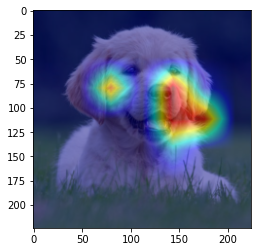

In [15]:
_ = model.interpret(x, using=GradCam(), postprocessing=postprocessing).show()


In [18]:
from glasses.interpretability.GradCam import GradCamResult

In [24]:
import torch
from torch import nn
from typing import Callable

class TorchCamAdapter(GradCam):
    
    def __init__(self, cam_def: Callable):
        self.cam_def = cam_def
        
    def __call__(
        self,
        x: torch.Tensor,
        module: nn.Module,
        layer: nn.Module = None,
        target: int = None,
        ctx: torch.Tensor = None,
        postprocessing: Callable[[torch.Tensor], torch.Tensor] = None,
    ) -> GradCamResult:
        cam_extractor = self.cam_def(module)
        out = module(x)
        activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
        return GradCamResult(x, activation_map, postprocessing)
    

In [29]:
dict(model.named_modules())

{'': ResNet(
   (encoder): ResNetEncoder(
     (stem): ResNetStem(
       (0): ConvBnAct(
         (conv): Conv2dPad(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
         (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (act): ReLU(inplace=True)
       )
       (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     )
     (layers): ModuleList(
       (0): ResNetLayer(
         (0): ResNetBasicBlock(
           (block): Sequential(
             (conv1): Conv2dPad(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
             (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
             (act1): ReLU(inplace=True)
             (conv2): Conv2dPad(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
             (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           )
     

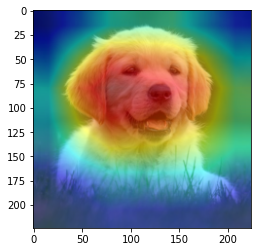

In [27]:
from torchcam.cams import ScoreCAM


_ = model.interpret(x, using=TorchCamAdapter(ScoreCAM), postprocessing=postprocessing).show()


In [32]:
from torchcam.cams import CAM

cam_extractor = CAM(model)
# Preprocess yodata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQEAAAD8CAYAAAB3lxGOAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg+JYAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOz9Xaws69bfB/3G81FV3T3nXF97n32O7Ze8jhS4AAkjofgiuQiKggAhrNxYyUUSCEpy4wukXMT4AiF8Y6GEKBJShCMiYgkISGDFsiwgihQhLkAOFhKBEGT8/fr9Ovvsvdacs7urno/BxXiqurpnz7nWPnuf18t697M0V3dXV1VXPfWMMf7jW1SVH8eP48fx+3e4v9cX8OP4cfw4/t6OH5nAj+PH8ft8/MgEfhw/jt/n40cm8OP4cfw+Hz8ygR/Hj+P3+fiRCfw4fhy/z8evjAmIyH9NRP5TEfmrIvInf1W/8+P4cfw4vt+QX0WcgIh44P8L/BPA3wH+MvBPq+r/+wf/sR/Hj+PH8b3GrwoJ/MPAX1XVv6aqE/DvAn/sV/RbP44fx4/je4zwKzrvHwT+9urz3wH+6HM7i+tU3AaQF08qT76WFz8+Oz4Z/DzdUZ/76oXf/tTLenm8dJb1xXz6r+m1idAXPj4zb3L2lQJyuornLkfWX52f4coOZ3v+MuPlR67f48ynI78zpv4Oa+iTTvaRx6n5/c9V9cvLfX5VTOCjQ0T+ReBftA8D3e0/2ohcVhcuK8IXROyzAOLmRSLzCdH57bw/K8ahtugrwKwCrWbo6vxrI5O2v663rc+zPsFyDeuLWS9yucLMTtdoL2rHi51HV8etyGt1+XV1ErnyuiLR+TdUUbX5qKv5EG27q6LYPvN3in2/fj7M22SeF0UAL27ZRZYHoUh7gPYs2z3J6RqX6ZLVU7yYUzvf+dTJ2QZdPeJzytD1f8u9nOYbkYsjzseyxq7sdPao12vj+tsrY7nDZxmgymkdnq5jflbttlTPlri2L44//4t/89qv/qqYwG8Av7b6/IfatmWo6p8F/iyAC6+W+xJbUbbgRFGdiWa+K5sgVT1bILB6MNfncP7KVpFy9UmuN6kIooqKnB7qvO2Zk18S/0zwqqsFzOWinX9vfrA/DHZ4fpxf/cd+bVnPawawUJOcvpCLg57ldp82rjGAHwhW/dJDV8xjfSmNxX2ny7u693O3ebF9XpsLZ3iBvczX9tz4VdkE/jLwD4nIHxaRDvingL/w8iHP38QlU13//RIg7KO/dzlmDn8CJXJiJvPfGTdav4j9E85QzfXfeXqO7z4+Po+XAGbNY89+9jrCXG28dpH6/HGfMq4QwZoBCBdzPX8/b5bLo+cD7e+EJuW0+cn5rv9dDn3m/S812o/Ma+W7P/+XDnj5ZL8SJKCqWUT+BPB/BDzwb6vq/+sTjmwSs8HGNfzjhBTWWufCkZvkecKdL56OnAHEK7z7DFloY7K6oLyF586c+LmDry3U53bVC9h6ZWEu+8nTaz4xwwVMwtldnqhyrQ48uRSdmesV9voi4a+HPDnhPHsvA4OTqnf1d65M7YvooD2okzp1eY02j3qJCK8hmmev+PK9rvQFOaEl+7nrSOEMPV6oROvLeO639XK/FTfX5eXF8SuzCajqXwL+0qfvb69G5DaBssb3l/u3/+Xasrl8kO3L+XnLarePDUNbcgZvF3XgbFWvRen1h33+8bRBRZ+qAJcnaPf03QDnWgee51jPkcClvvpkUtaz9Qm/PUszXT4sNoGZr4s0dLQ+TJapO/vZ73q/p8sQU68+8bLPjn1Jhz9phVdOKwvBzx/XhqprBPlEfVzePzkzILM2bEx8tqV8wkJ+iQF/RhGDl9JHr8LX09eL2Lo8BXAxj3IxTwu9nsDlVQS2GKc4RxlybWnK+YO8MmT173L75YXI5b/nVseVoXr6Oxk1m4xfL/ArxqtfjuROx54W9RqVfCJCkrMznM/Ld7yO9fG/BNt89rzX1oroSbjIzPUWjsez13Cp5pwe8fmxNCZ6/XouT/4cB3l+Fv6eeQfOxhoqNcgLglug72mFLuhtNSmqs/pwzkTWb5eFoecKwdNFOXsEOJv82QJ+4sI84U7yROpc2qxPl31u5dcrNsrLa7xqSjz97qUIXd2NrrfLWme38+ry+aRond9KkzpnEg5OnhJZUNv8WZe1Kbh5+0wfrD0DPGWqTXe/vJvVzZ7PxsW8X7OTXZ5nhdTbPJ2u/nJ9yOqYWR1df7+oaKspPvuddk3PiYenhHyNebJa8/PzmFWN1bOf1eWZjuZ7fIETfh5MABZ16rQEF0fZ+U6Xd/OMFfqqRrBCAM+Ps0d+vnnRWXgRgj353Zd3f+aoT/lmNVaM4HKRmpelfXMp8c/Q1JkMbZ8rMzO5fBZmoWa1yppaczFtp1e58u5ikV459umHH2icy5dPUg+fXsqJfTjkCjO/PPY5SX3x3VPuZ/+faTjtecuJeS+qX1Mx9WMXxGfCBJZpbBd9Unc+gY39Hg6RRgzPTu7fm+s8AwLX9B5dLZ6ZDyxfrSXbNVJY4QJZ8UJZITJZ7btGsovUb9J5Xuxy2uEMt8zPWl5yaP0AYyU918/xKUqES1xwbSwGa/2YgLl+LXBpFP3UX16fpl37c4jjhVN9FkwA5mU2w4GTB2CJHfikyV3h1Wug4RPP8tFxBsFeuIrfA56gz7x/upOevV1g6owE1oTcdrrOHFbweLWA17suUL7B5Fk9PleHVvz9E5HcDzrO+F37IDzVJS61skvV40x3/CWuYU2yl+h/tcY+yg7WD2WFAq4xu8vx2TCBeWHKlYs1DnuSRs8eL7OUOrl/nnLXl8e8OPWK8W/Zplcm9YoAnRf9WpU++6H5rZ6iHZ+eU59ZYrp6aatTn+55WqRPL/McNNjcni/qFbc4u2Bpaqmc6OcMya7A6grJzc/wmpHz2v2tQO53HzOzmYng2Sd/7TpWiOCSMO1kZ59nbxa8vC60HXxh+jyT3uuf02vGhdVnXa0BWbjrCVHPyOZjiOLzYQK/et7/ncanXMkpVuEKtzmTkL/kUl4k0yfsxnMM7wrAnVfeSiWAmWAuz3RanIvQbtxNkRUjmI2z2lyANFSwFlIrBrAggmtUdiGNv8+yWIT8Wqq+rACtietyvPw4WoTrtXPBE4O23eqaETxz8dfGNdTyzFhUhWfGZ8QE/t6P+aEs42Np1itp82SSV0/2nKSurCK5rl6YkL/mObgyruxz8ho0wn6yz1OiF5GV61BYJwvMFn0FvPNUFHGOGCKlZGa/pHlr2uFn0n9tWzhnkmeBMut38vycffJ4Bmbr6t7msQZOVzHYC89iRrKfrsl/v2EOguvoeImTaBf2khj6bJnAJ5sBlrE6QE8n+JTTzLLuUjU9yxm4cpSRkC4L9VJ9XL+ePYarxoJrcqBBO7uaZ656Jp5z9Ucv9rpCXqejV9J9VinEyaIaNEGPE8F5jxNHDIEpZ7z3bDZbvBNSSpSSGY9jO2FdmKDKzETOpdcpMHS1mBcrZovjkGuS7Mx5/N2G0BjdOZObx8s44ZkTPj24fbVGILKsk2XK9eRlWcuB86elZ1eyRqBnq2aNDlaC5WMegs+ICZyg4pwYsayJs5WtK918nsDT6wlOtgP0dBK52LTe9zmy1HXM8pVQ2zWHfRJGvIai7ff1mfUiFw90fY1ny+DKCaRd2jni0OWy5clCPL/IMxJrhNp13fI5hsA4TnjvibFjGAaCD6ScGYaB7WZDjB0pTeQ88Ytf/ILjOKI1U2peJsI5Yy61NOYwE3m7eF1u74QWnLPrqbVewHh5gpK03bCu7vfac9UV55sPP39df/dxSbRc8nLe0xdPyE9XTFHPX9HT09GzRX9ao8+qMnJ+7vVOJiDWmabn4zNiAufjO4GA73XyH9AW8UxU1ycd+sLnk+S4zqpmTn/JA/VCmlbVJ9ho7XkRcYj3dLFnd3ODcx4H7HY7SimAEEJgd7Ojix3Be4ZhIMZI33fUWikl87u/+3O+ff8t03Tkw/0HxmlCteK8QwSqN67lmkSupazAwOleVMD7QL26gHXF4GbOviZluXh3ObsX4dPzfK1x1yfCjIWQL9HJ1R9/Gv+yAq6rb58efIbaPv3yPjo+WybwKxtXJPLqS364qZ0JciWF5cr3Lx+9uqqZBTS5fVU7OF2/niAEThzee9RBqdXyzRc553DeA44QIl3Xs9vd8PbNW3bbLdE5+qFn6Ae891Sttj0GQojEEBAB732zJ1S+eveW+4cH9uPI7379c77++mumaSLEQCnF9quVUgs5J47HI0o1BpEzoNRW2MB5R0nlye0qihMHImh9Fs8/M67M3zyNes4MPmmsigw8ddA0ZqQzg5O234xk2uf2k7Y2T9t/L8ZnzQTmoKEnQYGrBJ6P2g4u6XoddvoEf1/CeVklC1072cXus1797A1dXNdaFbk87HLfS6m1PkRMitdKW9/arPIe5xzeebwPOD8TTaXUSq0WDeicZ+gH+q7n7vaWd2/e8e7dO+5ubumjQ8QRoyc0gnfOGUxHcOJQNcbinACeTbzl1W7DVOHLt2/55otvGKeREAK5lAZPlZQyx+nI+4cP3N9/IOWJaRxJ04STStVqz2mlis2GSbsG3+7hNBFPAf41SD7PoK5hFjPY1mcPfGacxPjTsTayPvluTfBPvjptOjvvijlcMIrZGCizHWnlJnxpXX42TGDtOz43Hl1Q+aJHzQrxFRh25eRPpuCCy9o5r0zUwgieOlquu7dOV/vSGvq403Ct7K6YndDcUKuH77xJ6Qo55bbV4b1J9ugC4oQYI8MwMPQ9zjtqqYwpU0rl1e0dr1/d8ermhjevXrPbbggh4L1bxfkL3hvRyzpWQB2lFGMEInjn8F2kQ9h2kVfbDbWq2QNWiV8KpJK5Pzzy8198zbfv3/P+w7d8+8031JqpWgzJ4HDOUWvBOWNk9nlGNSwqzxNU8AnTuy7Ds9DXdxDCa0F0uQ6Xr64sUL1y7HPXeL40Z8n49JwnRnBSHz621j4bJvCxcYocBC6Ca+S0w3c7J+cT/2kI7BNA/JJ09II0mvddMfWXrnRmks45Sq1IK99VSsUhxNDhfWTyE6pKCJG+H9j0G/rY0fc9u+2W29tbbnY7+i4izpFSJqXEZhjY7bZ0PhBDwLsZxhpaEOcaKjsPj52Tt5z3aK2cwJDgGjoIQ9+SlJ5AL1Thdrvlze0dHx7u+d2f/5zf7gYeHu8Zx9HuZRc47PeUWgg+UKlMeWJJOccZg6n1BB3XP/MEZV0rEfeCLeDMePD0QRkx2/pbHz+fURvDXDDBGvs/u54ubP/PaDwv4IxPHr80ExCRXwP+HPBVu5Y/q6r/hoj8D4F/AfjdtuufarUFfqmx0nBXPtEZfq0e3Mr6/9EZkfNJ/C4TKE/X8fq05zvI8w/x+5gevPNN6po0pypalNhHbrY7RBzDMLDb3nB3e8duu2W33bIZBoauo4/RJDyCUhd3mXOnxTqvTy0Z4wMecZ4l5dDpYgOYEcEpfl4bgp/RmmvPx8684BhVREzvD8OGIUZ2w4Z3r9/w4eGBh8cHVJVSK/cfPnA4HBjHI1NJ1DoRY0cmM9dCnOel1gpq3oSTtF3ZZub/F2awFv+XuPwC/V2DCI345++eMPT5Ipoaci0a9eq4sFw+5U3fYxGtxvdBAhn4l1X1r4jILfB/F5F/v333r6vqv/pdTvacQeXJ+5Mp9gwVLXteRQPner0s/3+EFs8m+Yy9X999ebhXFAJZ8fbFfysYhV3evJxJFVkuRalVCcFTi+J8YAgRUTGjno+8vn3N61evmsS/Ybfd0vcd0Xu8d+brXyzqs5ojjXjKUnS0KjgBqbVtr4g/IRDVCiv33ayUqVbOELkIbvktXbadg1TbHr3jbrfjZrvhi7evOY4T4zTyuD/w6uaWv/ubv4kq7D9MdGGg7wdqLOwPe4ahB5ScM9N4BATvPaUWaq1tDue7XTSS03xfe7ALenmZ2E5sQs4e+yyc5g9rFW5mh2tZvkrMPpuX1QFnW8+van3uc1VB2/w/N35pJqCqvwn8Znt/LyL/CVZq/Jc73xXN5TkI/azB8PLgNTR4wmBmcv00Ef0CALg4+hQGuhA7TZVpEhNZBfbM+uDFc1dkFceiLK4jtfPGGJvBrqPmQnCB3XbH29ev+cmXX3J3e8vQdXjvcfO5q/nn6woyz4ym1mp6eJkJ+vy6S2MGZhx0gFCK4ho60DpXvK3U0tCFMwOeeG+/1aIJ7baNgYhzZ8TgnODF4V2kC54xBjb9wDfynle3d4DYPYsSY+T9+/fc3US22y2P+wdqAecj3jlgZkgn8pqXxYza1tWUZ3H7VCVYs/ZztnAO/68syCUo6bT/qUAoSzyArKTZM+r+cm1Xo4V1xYxWa3+5vhcW7Q9iExCRXwf+S8D/DfhHgD8hIv8s8B9haOGbj59j/ebpHV5yzlkXPUHOlXdV9WToe8Ik5OzdDwOoXh5r3d8CcXrAkaZEVYHmHjvtJouRsgFIYwIieB/wIdB3G7zzzdA30MeOL9695d2bN9zd3tAFj2il5oq6k/xbIveAWps1XDFpXwpaMzSrvAXqACLUqlBtm9G0A1VKzrjG1HRlzddaqaVQRVDv7fk0rmcS2c4r1TwN58Rj1+dEGLqOGJS8y+iXyt3dLSDkWplSYtNviDHy4eGBo5uIQehij/dCzgk4NAIx9aDqLHP1Qjh+isRnZXmfGYCuKog9xezGSM9PPa/N2cC9IIaFh6yIl/Pj5pPOLPwUGSzn3GFGMZ+gMnxvJiAiN8D/DvjvqeoHEfk3gT/druZPA/8a8M9fOe6s70Db+LyudMGw4cQI2oeFAS512OZJWqvpF6/faSwP/rsf6pxbGJl3kbu71+SceXx8ZJwOJ4ha1wzhJK1F3MIgtpstN7tbNsPWjH/DwM12y93tLTfbDV4cJSVKs+K7EEwyNu3jFJCjC/xXVagF5jltEkybDUC1opVG9A6kQexqvQtUzeU4MwRjJKZiGHMAceaOnPMGzLJfqVUsUKn97DzHIuYVEBHubm/YbjbkYjEDKRfGaeKLN2/58PCAKvTdYAFLNTEe99zff0AA7xyKUEvhXP26zA44eV1OIP3a875kIG2rnq+rmbgX5Lr6rSXWYw4ZZhZqL6Dbs0vRFTNgMTZepXm9cgur8b2YgIhEjAH8L1X1fw+gqr+9+v7fAv7itWPXfQfEv5pX4oszsA6Y+aTru/qgOXsaT2O3nh/Lt2vofnYeOft+reOpCt6Zr927gMPzxbt3fPkFfPhgfvJSC4fDAdWCyinuvpS6EA/ANCXcjeP1q1fc3dxxe3vDdhjouw6HUvLU3GuNkGuhCjidCc+ItpSCNsKf/e44j2IooWKlohHBiTfIX5WcyxICjNi2khOlGLE7b/57ETGjJcVgbzvhTNgzga2fE4KpE1UtTwHbPwZP8I6qYUEvpQxMKRFjYLsZeDwcSSnxuH/ksH9sdg4FtWt13lFqsmt0ruVHKKU25qDL01oe4ty44/zBr79bE+LquHk3XS9tWXmg5PxYrq7UqwtwXlVPvr7QEz7VcPh9vAMC/M+B/0RV/yer7T9r9gKAfxL4j3/Z3/hlhkG29v5CG/heKOA7jYuHAfhGNCFGdtsdXeigwLsvvuDX/sCvcf/wwDff/oL3H97zzTdfM6UJUGIXkJRRFaIP7DZbbrc33G53bGLPq9tbXt3eEELAOYygJVIEg/ct0EZrocAJHmpFS6GWZISAEGJH6DrT+T1Qa1MPmpRq95NzsuAjTtmBtRGTMMcCzIzFLbYAxQjcFCAzUpoe3fzaM8GsXH21Frw0JKTVzoupD+IFJwHvtmyGnpvthmnKPGy3hK7D/zzCB2NIIcYW+mxPx3uPOHg8PHLY76ntOj45QECvvb+0BzzddNIPTp+v5x1eoOKVvWCdHXg6T2MjlyqEXj3b2fg+SOAfAf4Z4P8pIv+Ptu1PAf+0iPyRdol/A/iXvsdvfNLQFQcWEy2sg3t+VUS/ZjIvxxgopZj0DN7hnUnxV7evzT+/2fHq9paf/eQnHI4Hvv7mF/zmb/0m7+8/UEohRiGNiS5ENv2WV3ev+Mm7L3jz6jW3O8vgs2Sdk2fZrYxxqJrBb5Zq7dU5wbmuXaEdWdVi+q04aDu2SfWZEE0NKKjzi4QLITapyxLF52XOGhRUyyLtSqlIrdACkU6WsLXhcA2RzeVXZ7eDiEVHYoFJrnN0MaKbgVIqd7Vyc3vDq9sbxnHEhwAIpVRyLqSUeH//nl988zV5KjhxuBioJVPLUzl7Iixd4P11wlWeBLCcQfHnFsgFGr26aGfkoGfXc8YP9PTdebjEM2pCG9/HO/B/uXapfIdeA999vETOJ2Clq///Xo611qBaSWnk/r5AhTd3r9luem62O4a+I0SL6nt9d8tXX37JP/gP/GE+3D/w7Yf3pJRIabJkns2Gu5sbXt3esR0GnNCs+gWLpz83shkh1xMiaOQ+RwDi/CKtazV0ALTIPMyc1tQJ7zwgjTALJUMIJmFjiHSdBR85Zh+9eRBMKzA/PtKYhM6pya6pBbrYA0Tc2eSVhgBMLbFch1loz3YfEZqnwaR89/qOt7c7FCi5knKhlMrj/sDPv/mG6COv7l4TQ+Bxf8847hcX70tYYE1M17RXfYHknyPEhWCXJXtx0mcvarXKL07+ccZzGp9RxODsAtMz1fpMJVvezv7ec7/8+rtlgs70gXk2V2L7co4uCeiFcVIvVvYA7KLX17XoeyrUoozHI7/5m7/Bbthw0/d4MV3eYZLROcew3fJ6u+XXvvryZMCb/fEt8KbWQs75lAegM4GvM85tPp24hUiaQDOvQMnkrMuMqVZqVoJv+QbNhVdyRkXx4RS2W3JCnTRjoBJihyLklBaYawFEasylEfESAyFiMLzWRY1QQNx8jUKtZWFYbvYwaMWJnx0U5uWo5pGQxvQCUJ2g1ZiCF8ekE50XbjYdwg3ffluYJDDEDQIcjweqjIhWO3e9WFtnlr9m3Lwgt7M1c7F8lrL4q/lfS+wlfGNeybJaQSdcv6yx85V3KjR6dkXzJb8QkvoZMYEVI9Qn8/fiuMYoZwnxxJQo83e/dyhhXvCoSauiyjglfvO3f5uhG/jKOXbbjRFvFarY4xUxuCuusZF6cuWVcpL+0mCxQAuMOS0YwZlRbo7amxeazj79Qs4TtVazWyiUUpgwoo6hAzEorZoJfjCUoOC9I5dCjL2pEbTU32YopN33/HxmqD/H/9t5y4q4LG4AWMUPmGqxRALSkIKbFT4WhrEMkdXz1+VeRaDvO+7kxuZLIefMOB2ppeKcM9tBnhoDeIag24/qla9eXAcLclDmBrW2rWHXlzD75aVc2fckL890hOW3nhufDROYGcB3If6r51kxTD2TiI0ZzPMzN4z4PRuCC56b3S13N6/oY49HuH98YHjfoSWx2W6IIRo8l1kS0qzOJuFKsZz9krMZ4hTUuSa1T754GvyH1mZKLRpw7fIzCG6Wca2ZlOvCeFDIaaIWM06G4BmnzJQyXSPi4IPtVwo+WJqwd4EQwnK9FgMhTSWoSJUFkahqS/hpSMS5ZrCbvQdCVRabxGxgtCrGplrMBkvFXJiyFq1q9RNE1Ig+0JhnbkbPQvSe7WaLoozTAZ0qBbdc9xPCXEnqp+Njq9cIcmYEy1aVJShrXpLLc7q0NS0C8kx/WDHBdfziSpq+wGA+GybwdKwv+rsTq8KZy2aZXE7Ev35/Ou6XZQ6r33ryyUYMsfnwC5vdwBdv37LbbIgxoLVwPBzIYcJ7Izo/G/dqXSLKzDhmhOQbBNQmvVtAoN3FQvD1jCHMKGBGBJUC6CpibY7Dt6hApVKyEfnQD+23Kj54k/7OU5rBzrwCBUQXtDCH7M4GvlIx1afZB1gt2cV1KHJG9PM4lSczhsJM9DLnI2gj/HNx4hbbRkZQuuBxm6G5CT04xziN3KdMSmWGbjYvckk/l2rkOXG9xAbW/HmlmK7Q/gUEbujxkumcmMDZWdAne36aWP2smMDJr/5dj7vc0OCVnN7P0GjFMBfV4PJk3wUlCLKa6+dhnQ+B290NX33xU263lsl3u93RdQEv66aQSs2JMae2QEwXnqPqZjXB+QC+SYymGizW85kY5HR9cwrvHNSjC7RWqpZF2nofQKBUxXtH8GYMrLXifVjSgWutVM2E6BbCdG625FsQkCGMSmmMpS6BUE28tWuStUllJQm1tgxFcStYf46LZ2Y/R8etg5/WMnFWmaJ3OKKVSut6NtsdN7e3bDYD/dBz/+E943Q0xNBsLqrGKNe8dM28rhPa0+/1LAr0I2dZ1u71s54+LcrWSh04Hx9byZ8VEzgtgJX9Y95wuetiPJjx0snSsu5reHaixtYXIr8mrs8u54dTF0rKTMcjqPLq7o673Q1dDCAm5aUluliO/MV9tso/izsuxlY/oFrJMHE4Z356rTPMb9l9cwpwE/1WccitGKTifSBG135fKVWJza12HI845+m6nqIVj1+KedRSqC7jfSSnRIiReUHWai7B2hjBXOPOjI+lZSZayPBs8JuNkMt9QTMksmyfo0RnFQNmplROgnSurkJjnGILyjkIwc5XkpKnxHGcSONEcIG73S2iyjffFqZxpNTUSputmclTuXxWq7TN61XinhkUaxuVXBSuWU775K1c7nN+GS9+9xIe+LyYwHcY69bMZ9VTFqh1ysFfHbQq7PgJ0v5jPOAjSGv98EKDz19//XM6F+GLyu3NjhjFau3Vk4SuemIEcymu6sw1FkJshT1YdPzZWDgTwmxMQyxaMKulG7dNTe+fqwnPYtg1g51F2U25EEMgxmh5/UCMvTEc3/R3kWZQq+Zjd2J6v1ig0lzkY1EJ2nwswUSrlTu7KUvOrfthu/4L6b8OPprvxztBaEVGzlIYT3B+ZkLOC33oiB0Mw5ZNKuyPR1PVWqGS43hknA7kcVr91mkxnAG/1W/ZNllQybz1DDysjKAnaS8LOLpcO/P7a+jhbMgVobbWXP6+sAnI5YdL3evyw3OSXM/faTOQrH9kzRz0fPPilvkuIOBMDFxut0VQiqW4HvF8+PCeIXagma4L9DEQnG+nEByuub+Upvg2wjXoW6ZpgddlzvoTZgsBNElaSjEjWMutn2PxF+MbNBebncfi943phBCXxT/0G8YpUSRDbdJ5ji3Qgta5qEeh1NLUAqXmzDo+wWao2fRVqVQoigthIZw1gSu06EHs2jgx/8U+oLNrsM2+lnZPLSRawDmPYgwKBXVCrULOlZQK0ziRc1qQhlVVjkxphFxPBL8syfPgm5MmuBZCl2v43Dg9h7Eta27edm0JLUPONpy5v9eGhitL8aXx+TCBFR6SeWaY4WPbZQXt1+qAnqkDLNNrQSSr71j9BquPF8x5eb06ToU+z4GhPI0YnOvHNbgnzQFuuubEdAx03kFsBj89LwJataAl4UPz2YuiOVFzNgLXdsu+Gdla3r8RnkkkNxP2gpwsI7DWFhQ0S+ImvWfyS2Om63tKFYLzdDFCYxgpZwsSaqpHqaW5Bs2uTrXQ3lxPaknV2oKFGhuYmYN3S6zATGczumFW7BZbiMN5ZzYCma+82SdqObkXxdZESQnVSggd4oNNUZ0jDx21ZnMdYh6EUjIPD/f84ptfmNuwngh3HVeyGPEW1jPbJE4m53nB6uo9y+yult6Z5fFKH4HVN3PRkhklnaRcu4azEy8HfnR8HkygQdRfxVBYSj/Nn+2NLvrYE2vhs9c5c/JTQcezr8/YQnvgzQAmOHyIbHc33OxuuNntuLvd0UXPzBi05OXI3CC+k0rwDqmFfJwoKVl6MA6ct8Ieyy01ydcCgxTQUleuQavzJ1gew2KBnyP4mnQXcZScGaeJfhjIpVoVo2q+9FJyk7DO9PGmEszVjuYcAl0t7lnKz+XDVRvCUcvu05b3sBwxGzJFDX2Yn7MhnxYstaA8S9AqxQhcxOoSEiPa8idEq9VWcJ6is83BGEHOmTQljseRlNOS8zAzopfXl64XFeuPCzt/IjBWK6TZPpbM12uEfPWH25dX3Jhr9eFTqOqzYAInfXEm1E9gX586dEYQp6djoENWdQf01LjlU2ZNToxg/TvXlEUFnHcM3Yah37Db3vD27Rtev3plKEDLAoFnl16tJzed965l6U3UfKCmhFYB3wOCiuAbQc2hdrM0NbrXxaAoNHWi5Ka7NxfZCvqIGGGHGEEMNXhxC8IotRjjqeBcXCEBu84qtTGAU3GSyilg52RnM4ak9axk6mLdZ76T5R4cczK15gzU5Tw6P1qxTMjFAzJLbT2hDFr1ZQfQOUpVqk7sj0fef/jA/f0Dx/FAKXkF2U9S9iT7V+vrTNqvrv3i+6dAcRYUcrZuZPl8AsgnFWP+gRP8XwHn1W9++vgsmMBLQ5rF5JdmC1d0LOMJel7r7WNsc7EbPC0DtRghzxawDdeq/wQfiaHj9uaG292NSfe2NNVCAdGSWz68ueOCN0lVcqWWiZqO1JyAgCeACwY522qvbWHMgTZO5nRftwQMmbS2cNpSs0F3Hwgu4NwcJtyY1xyxKIYQkublPrXOVv8VEWL1AP1svDsr/DlDfFkYrYGkSq20nAdOCE2EuZTZ/H6e+5ITZTq28uVWVNWHiLj5p4zp5JTQkpFajdl3HRJCM5tafcY53Bo4GRaVZU4/lZzOhbGevZy9X62T86pCKwayMhaezr1SBdbnXPjHxXUudoaZhp6/9s+GCZj0gGW21nhGzzLOr47FYPTkvE1Irj7Pv7Ku6nJ53FnQkJwI/snJYSHEU8zAqZagE8cQe754846fffUzvnjzhiF6XJP6zYrVkoAMmoLgYjSLf4sOtIIf0oiMpiOaQU+LRQOKc7gQVzH2K8kyy0KtCxT3LiLOKhWF1pdA62y/aAFIpRBiwHlP9JGcs0n3RdrqieA5/SZNr58ZgkCrkrwqsqGOJbkJhUXPb6hmYczSpHnL4KuVXLLlKLThvGsJTobqvHNU78k5ocU6IIlUvAygQsWqNDtAmy1jGHqGoSfXqRVDKctimaVzXYlePV3gelVdGA0vxPJK5VlXKF5iHa6MJ6v+7CdXDGe9yGebmjZf0Qu87LNhAvBxNehXNlaoQNGlLNki8WcbwBVYMUvAJTlkbughji52bDdb3r56w0+//Alfvn3DEGMrvDnHBWRyKeYaaxZtH6IF2bQQV9FqBF8V5ztC6Chqemxpuq04T+w6QxgijXHMhT0EaqWUyRiLKuIDPkR8k9BjKWeq0IKWaiElRzdsmoHSGpLODGIxYpay2BRmSVxKOT3TWR1YGLoNR8tWbIFEKkaYM4OZA6AEmmcjEGLEyY5Rjo1YoeSCSMY3JljEvA4uB9J0wNWMVo/WgkhoUYTQx8h2u+E4TQyjlWXPZaKUZK7VNUXPa0RpYb5zkZCn0QPPLLSVGqGLUfAE9a+f44Q7daU6nI91iLBisRFrk8xL47NiAt+dAcgz76/t88zZFwZw0uvOjH6rwy+LlCya3krvEzHr9dANvL57xU+++Alfvv2CVze7pe6ftrh1C5qxuP2SEyUXk+JYYsuMFJycpGqtlcNxzzQlcA7nA85Hy/oLnlosX77kRHDSWohbe69aTHKK9wa1m64vrc/gXCaMZhwE6xMIUFQJXUcXO8SZmlBKaZWD5mAdYwAFPcU8AOLWPvxZ+s0iqknZVhgUlSX7bx08NWdXmjfE4WPHNnaoVnKaKCWTckERY6JWYcXu1TlSKkguSFQ8FYdHmyoWvOP29pYpZd5/eI9z5iKspVBmY9GCUs9DiWcVxbadr8Fn13NDA4tN4KnGb0JorULMe+hzeGG9Vk849gxdPzM+HyawgtZnXE1PO8h6UizD5kxXtwNY6VerbaYsn+DmSklrAWXMeph5FU96mjZJv2znqWqi7ZKiC2z7Lbe7W969ecuX777gzd0ronem9zd9c67pp2miTCMlm0ST2K2MY7r43AUlTyOH/SMpZ0oVYt/jfERCtDReVVILedVSSALVuYYiTAVw3vRnFyLOhcaMWAhTxIgjF9P/RdWs6WlaYH90nhgCTpXSIPMcHmxi2a59iVvQxhRaQZI6B9SIGRhxbS7mbWqQujY7h9ZTuLdKMRjvzGXgQ8B7T8qmHpRSUQri3aIihm5YaiHS5p1mK8EJpVqEoKV6Vx4fH1vcgD5pIHPmBpZZDaXxtpPwOCPv1dpuk32VkPXZDxd7X7Ve6/IcQZegqZNK+7xR4IcoNPo3gHvs0WdV/S+LyFvgfwP8OlZd6I+/XHFYOM3kbB9QuICO8z6yOmL9Dcu3nOtIqz2XBznryW2/0+7z8SvbxIVqMEuE0+NsRjjv6ELHdtjw9vUbfvbVV7y+uyO6xgBK0zNLQXOipJE8jZSUEfGErmvGolPK73z+kgvjfs90PFIUxHUIERGD9QqkaaKWbOs7eEoppDQt+rSPPT52hNgjYsFJ0tqK1UYcZSZ+WnPQZv0XZ0lBNUOWDNWqDNcZ4qvp9Osxz8+S/UdjgPMManPzaSNyJ41QGgsROUUAt/3nBqpmVrXvnQv44CzjsFjUpKhVSDOGplR1UDNpmpDeAQWcEpxjO3TkXNkfE9vdDcPjPQ8Pczu30zoRLtfJggWfrLP1WB/3BPbr2acnx3G+TM8Qgn1eM5Tz6MrTea6rEPP4oZDAf0VVf776/CeB/0BV/4yI/Mn2+V/52EnWlYMFOQsO+k7jjAE8/erS6DfP7vkhaxSxPn52wZ1fdwwdXdexHbZ8+fYn/OwnX/Hq5hVBHJSWsFOrJfvkiTxNTXIBEvFxaDC9RQ5qNYCuhZIS0yFxeEzsDxNZxVqI58yrPkB1hg5mBuAcFShFKMUjLtL1Pf1mS+wGy+CjhR1ToRRkVhXmHAY1NDB7AFyA2KRypZJKaaHHM/G3zMBGnKrSVCu3EDzMTEBQHLVYYpAoxgBaKLMTjzjLXZgDm7xYaLBoDzVQxeMIiPOI9wQEcUbkJSU0K84r3gkZq+pEtdJpk7e6AU7BqdK5wM12x2Gs9P2G7eaWcUyM4wGlPYdF2s+awWmNngeJrcTRql3eNZZxYgBXOMEsmFa5MSd71QlnnNzc6xXOi5L/cvyq1IE/Bvxj7f2/A/yHfIQJnAVOwQLLTxz0HMS/NC5Oc30fnZlOO7OwZg2r85zk/Ym36OqTEJyl2W6HG17dvuKLt19ys3tFcBHXjragmkJNlTIVLA4lWjqu7xA3IOINorf8ftFKSRNpHBmPcDzC8ehJNJ349g0hviJnyzxULM+/ZHPV4QJdPzBstvSbARciS+pt807UMiGuQKnkmskpM44TtUl56x8kdN6D+FOHolIa/K92zUVRL1i7MofirUipWM0kVb/Mnrkcm8SvDfIXseAnQCXgQodzltFYy0SpSvAOrRG0Q+gbo7A/cY7gKuIK2U3k6UgpCVHFhY7YBcp4RNTj3A7nYkNbZsiN0XF76/nmwwHvH4hhwzQVVPPpeYs9e2lQQxuKOa2XUxrzOk7gtCKfmv/OmcNq9S3aqnKKNpQzIpAVV5rVrrm+wjW0/Nz4IZiAAv8nsfjc/5laKfGvVhWHfwvrV3g2zvoOuA2ymr6Z6y23ME/EonM9ZQVrq/6LE9BUgROjPN9L189i3vf84GUHwQprDP2G7XDD67s3fPH2i6VoSHDNBVatZFdJSklQq0M1kovp4CFuqGoSXfGGGKoRUZkqZQqMB8d4DFQ6XOjZ3rzh5vYLwKEl46Q3t5marhy6SL/ZMGy2uNhZLT+ZU5LN6q85QVVqruSk5KmSsjKmSkURZwlLIKgEKh4nLVuxLTwtiuaMk0IIgvPSmI1HVVANxpygGc4EkdC8FixehKLWOWgh7Nqh0s7DRM4TOVWCj9TaU2tHpAc6kACtKalz0PUF50ZKOppHREYkRHw9oJrR0uG6Dc4HVMzd6ahs+sjtzZGff32P9weiL0x1BOYKTjPzn9dCXd6fr5G14FoxBIwBmjtQecIR5vU3C57l+/XnNV0sB5yd6tq6fyki94dgAv+oqv6GiPwE+PdF5P+z/lJVVUSeUK2u+g648Hr53iDWCQLMJcJmstOnp/qO4xmbwRXifw5TzO+cmG+67wbubu549+YL3rx6w3bYEX2wDkAlU3Oh5oIWRQgIVmJMxPR0xPoJijqo3txdBLR4aoGUJnLZmk9fAt3uNa9ef4FzXQvAKdZtRyD2ZvgLfUc3DPjYNS+C/YGhjFrNXWiMqVKzUDUgssH7lrlYFVWT7EhoEl0X/7nimx7emqLWgg/eFpUTRCKqcSF+k1gOT8ec2zBH91nkckdwPUpE6Sg1IBJQyYjP1JwoFXKOIBGkBwbEGyowdcQMkD4WREY0H6HuqQRUHZpH5CjUEHB+QJzHUaFmos+8vv2Cm90DDw9HcqcgnlwSpaS2LmcjhTLXZJYWkXhKDLI/Q7eVuVrEJaEqsJRbN/8oM6k8Ve0b8piJ4mJNmvBbp8rN1qSL/a6M780EVPU32uvviMifB/5h4Lfn/gMi8jPgdz52nsXowXyPDXjPjODMPvDp+s7V31kxmGW7zD/27FFXt3vnCT5ys7vj1e0rdsOOzls4bc2GAGpWKGqSrzpDApjERAKob2sqUArkAlQzghWssq9zgguZ0N+wvXtL6G5aXEELb3XQD72V1/Ye33XgI9pCaUXm+oTJXrNQslCLUKoDsSQbJwVfHKUc0JxJWugGb2pBBZWTxV8RirYKRKqkPAcimT4uzltBUDxgpcgspigaOtBTjQTxDpVI1R6RABKtzJcL1FBxsSBlRFyF4Kjiyc5hKVABkR7nWp9ENSntXML7A86b2pWmCUkZqZ4yzpWO3XKd4jq2m453b3/Kt+8fOBxGnFOCWDRlqQmt6RTcxKKpnwLPmFuxVXM1z8ZSPWFcW4Kyen9a/zNzNGZwLoTk7NP51nXw9YxeZYVif2VIQER2gFNrSLoD/qvA/wj4C8A/B/yZ9vrvvXieduHArKy396sdGixapm6ZtdNZzt20cv7a9n8aQtlg3pXGAYslYIUSlksSRx+tFfjtzQ13N7fsNluiC4YSS0VzoaZMTYYCaoGUTYKqBJx0CB6tDlWzvJcCpVjkHlWp1VNFrYNQJ/Q3d3Q3NxA8JVVUA85Fus6kvvexZRVauqw4B1Uaw8AkfDGCLsWhBKyGQEaLZSeqeoRIzgnXgqRKKbhUkSAIVvMA8Q00WRmyWq1VtWSTWiEGwKS24FvB05OxUvBNrbD2ZOo9hAjBoyGgTtDgUKmoWMckcZXqi5U1d4J6hwZHDUKNbunuRFHwHpeEUB0xVsY6kQ4jepzwEvFBW65BK1zihL5T3r39km++/cD9wyPjPiHi8K4z70hxZjBt2YcL1F8al8yLdcavJxvBkuwk567HpxDhEpauJPoKvRqhnz4tALapDnK2z69OHfgK+PONywTgf6Wq/wcR+cvA/1ZE/rvA3wT++EfPNGdDnUdiLHOyBGOsb44WRrqaCFlN2mkSZP6J5bt5KOd8Z9G/TviO2TorSAsGsrbXN7tb3r1+yxdvf8Kbu9dEH5oXwPTkOk3UlChZqUWx2BqPCz3OW1NSrQb5qxrhp1QoZfajY7n2MVGiJ/QD3ZsNbJVSpyYhe6LfEEKPdz0QqNWs8049FAs1NsEy9xNUcq5WRryUZrOwaMUpjeRsEtBccFZjsBTFqVXoda4wW80Fk8VVBXEBJVDVmWqDR+hQnY13ocUAOKAzz4Grdq4g0EHtqiH9KI0JVNRliiamdCRrxncR74Qo2aoFiVKiUoMQPQTX2e8XB1PA+45Yd3THiXw8cHz42q47DvR+C53VTvBAdHC3ueOnP/mDPOyPlKqMx3tynrD6qh6hNhVnzoWQJulXdoI1Utd5+wxrTwY9W1d1QcEn+4I+NX3J1U2rtX+iJUFOxL/YFa6P78UEVPWvAf/FK9u/Bv7x73zCxXe/8LVFCBuX09XE2esi6Ncc8izE91wrehp5cIkATpxiYSmNxYp463gjjk234fXtK75485Y3t6/ovbdElYqpAWmiTBMlFYPcBZSAixuc71D1pirUBv/bfY0pW0OQ6AidNf5UaX78AfRWKJ3ZGmKIdH1HCCZVa5P0WrxFxFVHqWJqSLEiHyVP5DS7JwuUmSkUqhZyKhzHg4XgehBnUXVdcHgJIEJEG9Nu86cmyX0YUI2mWrgBpQPsXkU6xPW4OcjLeyQ6RDKFieoLGhXtQDqQkChO0Sioq6Ry5L48gIfYK7EzVSk4h0pB/QQOJGqrrh6RAtIJLjprV5Yjfuyh9mQVpmPCx0LwgxVFKQblO+/58s2XVnQU+Prr3+awvyfnfVs5roXlnofniljEo4WYt6XcCFzUozKXWJsbK8xrrn2+QJ3naEDO1vv5ml7TD2cM4HSGXx0S+MHGCXobUZ5VYVnoVFa1GdYW/tMZFrYh6yk47XPlh0/nElnm+TSdaz+FEXmIkTetFdjr2xs20eO0WAurItRUKFMiTwmr6O3tz0UgUounJrPIl1Ip4vBRyDVRfKbbRXzn8dEZYWoi10LYKu7OU53F6XebAe+tQWdtzTcoFoVnDT8qZKGOZjgs42gls4qiGqkVq3Z0yFZTLx+oOjImq68XIwy9BRO5TYfLFr9f2vPxUpvEd63U+ABuQGsA14O0P/XgepzrmauqSie4zlkdATKIUoKisaJRICrFVWqEKpVfvP+G+/oe3wU6PxHdROcGtv2uGTxBNeNDxXXmpaAILlcktpUxCboTNHs8Do1K1owrIISmMlV8cPS+44vXb5lSMtRUrHBqrmNDAbUxgJbzMEtcmdXLed3OKkA9rdDZwCgnEl3UUvPLtO/bultyWZ7yB1mtVHtzLu7mbWc2g4vxeTCBCzX9UiNaUM2Kea5fV3ySEzM4qQFrOLFw6cuTnF3B0/fa4HToIj/54gv+M3/wD/H27o4+BFzV1tjT3Hw5m0TVavnyJYOqQySYjl8gH01HzyjSCzUWUp6QjcPfeHwfEWeQPU8ZvNB/sUFuHUqm2/ZI19xwFTMkVqDQiN8YklIpKZE4UOrYIjEdeawcjuZ6K7lQUmE8HpnSnqITU06ECKhDpCP4hPeGWizUf55QKyQieJO2YaBq8+W7HtVoCMB3SB9xASRoYwLS7IWtqIgHDVCDolGpAaqrjHXkm2+/5eAfGboOhoJESxh6YKL6HZu4oRYYfcUNkRACUjwlFVzEYhOOUIZKnSyj0fWC9EIJlshUi1Knlq/hPdt+y5tX7/jw8Mj9w30LOLJIwrmE+tKfUWCpGa0FFb+UcZ8DonQhdlplpEvCbHksZ2qxnBjL2cJdkf9KSF6ONR09Nz4PJsDcymqeqHXO/jWV5iSx11bWef/Ld8/85PU9V9bFJWkFu66+7/ny7Rd89ZOf8vrujj5EK+nVrP6oVdkpqS4MIKVKya2un3pKhpKsN54PgnpF+krxSvVK2Hh0EGQrFC2kKaGbSuw64rueOiihi4SdGQA1m/pBFVxVyJWaKuqBCTP2uSPZHckugYM8Fg6PB2opdN6Rq/JwmDgcKznTmpuMDJvA0Skw4kQJQfBelxoDZjCLiEScRLzvCKFHZTDjn/QgA853uD7gBk+NClFxg8P3DmIz/DlBvKJe0VApAapTqqvsDwcewoHJTbBVtCv4Xum7QHBKSnt8rHRDx4QShwnX9fgKOlV0aqnGR4e+r+hYSVMmhUgcBInOCrXQ6ixkk9ohdLy+fc30VWJ/eCBNB0tNVjCVoM6+gRO9trViy9jcg6IVFU9LqlituXPVtFlXziX+aWGeb1vB/VngXSi5zy33J+MzYQKcdBidc7bP87Lt21Ou+xkIOtMLVtL/hKdO2y944oIWVurD5YR579lut7y6e8Orm1t2/YYozpJeiuX5azE4micjSi0WfJMn8/lXETSbzp5KQn2BPqCuST1vTTsYoPaFFBV1yf6ouF2AW4dsPGGwV7yjHgslYfA2F+pUqQ7UNYlTEzkcSe5AlkQqhXE0ZuDxfLjf8/B4RMOOu5/8hFKOfP27f5vj8QjHjBDQmg3FO8X7iGu2EZzHhx4nHd5vCXGHj1tgwIlH6RBnDEA2DjYO14HOTGDjTWPwDnGRHArqEoWESqFIIrvEvhzgTWC3e00XC8Ep9+Oex+nA680dr+7uEF8oOqFUpu6I7zuTyw1dkAV/5/F3nnwswEQWobgDob9d1HEtFtHJ5PB4hhj56bsvQTNC5Xd//lscj4+NGeRzeApLQtG6GtEJ6eqVv+XIdvwqSEhO6u28zhfReLKdX6zbE6xeGwv/PkACsOjfc7be6i5PtULXHK5ZEeT8DDPNyxn9y+kcF7+5/MY1Xtmy5ny0cFtNhW03sO07vCiU1PICzMqfcyVPimZrPFqLQW8rCKo4B1UzhYzvHbWHSkVDhqBm4IqZHMFHh4sFQiUERx6Uuq3EG4fbONgKRSvFVcitXPeULf/GidXkcJBzIrmJkSNjGVsKsqeKcHh4IO0nnESC78mTMuVkATpqmXkhYcE3PuFcYRggeGum0g1bYtgS/Abvtji/Q9wGZNN8854aBLf1MIAMgtt4LNBPYSvI4Ih9wIeKD7nFNDhyyqR0ZJ8PPPo9dRhxccLLxCY6gsDhWPmdh0dGPfDTL7+ic721H48jZUgI3oyEHlx2uBvB3Qg8gJMKTFS/p/pDM9YKmgxNlQIkhxPoY+Crdz+htLyKX3zzc/b7B2vkKnN5+FWtwIZozz3dFYuXOAUbnSIQDTGc1IrLFboqWLPasgi6+f8VGjipx/Nafrq85/H5MAFZptE+zhmEl2GSnO5n5opPoM+y4aRSLN8tFR1P+8nSH24p+LUEsPhWrhoVbndb3r2+Y9d1UBO1ZOu6VS3jLo9KSgLVg3q0mq9eawt6cZaBpxG0d9RoufcuVtvmlTpUpKuwcdAJUj11hBwS4U6QG6X0im6KeRxEkSLmkfBiUm9SZBKUTA0TyR041gP7MprXrCbuPzyik7LtO8iF4/6BUjMiBS3g/UDsBCcGYXPK5AwpKbvNHCm5QfyGEHaNCWxQtVBeCT3qPNkX3CDI1kEv+F2A3lyBbmtMQTaC9OYtcN7Sg2up7O8fKd/uCdwzlF/gP+zxHHGdo/Md280dX48Hvv3wgdAn3nzxU4Z+oIZE3RSqKIQKR6uBSKqUrqCdoTcRMUOkz0gouM5TO0dNFVdnVCAEJ/Q+8JM37yxCEsdhmqykeU1Iy9lQLYtqulTAZh0x2FbXWnfgJJ0ssGgORT4RhjB7Fdp/8xpeIYWztX5mcFzCmS4pbhmfBRM4QXttkn19U9fsmtdv6Mz9J2f2wCcBE3Lxuh4WseXwPrLbbLm7veXLL77kZ+/eset6pFX8sa6+imaD/Wmq5NzKYqkFlpRs/nNxzoicCr2QfEE9VF8XXVmDkLtK3ILszHpdCiSpxJsefyvUTUEGqH2lFpDgcVXQBDopjBgEdlaaLIeRUUYOeuRI4pAz949HjuNEpxHNlXIs1EkIBLyDNEHf3yKSEEa809a9JxB8ZHdzS4ydlSWLPSEMTf/vEe1RDaYGDILrPbLBpP7G4bcBNmLxABuQjeC2DtkItQv4GPAx47USNxtCKmymI4fxEfK3hPJAUKHfvUKr8pgfqCN8+N0Ryp4vfvIHiLc9ZZNwkhv9FUiVmjKlq5S+ANlsOtGhsUKoVnQ1CXXEsimLoMUjySIehtDzs3c/WepD/vbPf5vj8cFUQmb9X1fBQO5U5BY4oQF7f0qKZ4Xi52gXK6Q6JwmdqwXzur4E+08Rw5zt+AIP+DyYAKwMG4q5XhYq1gv9/oKUdfW+jRPfm6sGnXZ7yUAyh3s48QQX2fY7vvriJ/zBn/2Uu9sbqw6cW0OPWqhpIk1mhU+pkhKGAHRWB0BpEWwOqitUp+CVLBWc4AcjAAusc2RfkK7QbcxKLgouOoZ3W+pWSTExbMHrZME0/RYtUMfSjGuAszj+EicmNzJK4sDEQxk55kySAp0wTZk8FTQrWhy+gK8W3a/OSpO54Nhut2y3ntu7wNu3O169uSOGDh83xG4LdHi3MVVAB6p2EBrx92oMbVBk5/E3Abf1aK+wUdgaIzB1AXzv6KUSCrh+4C133Idf8L4kshwpD+9NUk+J/f49ccy8jjsD1x8yetMR7gac76kxGvPVgnqhTJnSJXJvFZyKt7gE7Ux1UicwCdpZuTJrauIhWWqz947eKV+9esPmP/uf5+bmjr/1d/82Dw/fUtKxuQr92Zqy9WbEb2uwmH7S1vkJuM9qwipo7mJpr9f9pfFwQbgrRoGyFDN9aXwmTGDt85dFxzplUMrF3pcfVgxAz5HDysbyCcP27GLHq7vXfPXlV/z0yy+4u9m2ykDZYsfLRM0Tx8MjpQhSO8ZjopSA90IpSsmWISjSUUXAKxrUEuS8UnyFIPjBYwha8BsLEc6xUDeK6yw3wU0ebh25T/RRGUiE+gjiyQ6S61Hf2W+MpmPWksnjCAPEu45uGohZLQ+/gzoouldaZi4yCT57uhrwZLQeiUHovHB7s2V343n7bsebtzv6wdHFDYhVNnIy4FxncQCypdaAbkC6SumyJfr1Aj3I1uF2DjYCG0UH0KGiGwiD0vtMpxN9SPQh474aOIQdv5M8KTqkDzw8PnDkA30YuHu9Q6Knek8NgVebzMbtcfU9BUcddhTvqPvKtJ8oQ4GtWBASoLHihrY6HEhyyNE1V6FAMW+LE7Eciip4hde7G/7wH/p1cJG/9Xf+Oh/efw2a5kXIWglfGIHM9RPqat3ODGC1Ws+IXpcQ4LNlfyn8ZKXezqt5rXG8MD4PJrAiZFkHCvF0Km1cuasnlth5s64YwYqDygktAEsii/eBzbDh3du3vHtjhUHrlEiiZkwqmZomxsM9x/3eIuGAlAtOIuBILaY/BkuUKU5xETQCnYXCFlfwXUA7RXtBZr0ZQbtKCol+Z4k/RJBuwpWJXYAuTQxyBAJTVUZ6JrchDx25Sb6aC7J1dL5HuojEjmF3y/E+Mz0W8kOmPFb0aPCXUYklEicPDeEEL2yHyBdffMGwFe5e9XSdR8SCBcTNRVB8k4BW6ch1ZvyT3pn+HysMJu21U3RQYwJbYwRshNBlBj+x5cAgB7Yc2Pgj0U2ELzq+KHd8/bd+i9gp0y7yITuOeGpwuL5H+h0y3CJ9wO8qNY4c9QOTFlLccdg4pnCk9hm58ciIRXc2NCBmxoHscL2jHts6qUo6HpFRLdQ7BECpJbPtBv7wr/06znn+2l+vPD5+a4KixQ+s7QG2NAu6fJ7zCQRTEcrKjjAvyKduQVlzCD376mKbPrvv5fg8mEAbS34Ap2KOSwutjx68fnnqejm5XJ7w1OW3xXm6rsN7xzQeebh/Tx0PDDGw3fSIVyiZNB44PN6TpokQHTULWj0SnEUAFvAuIC5S1GIB1NNeFY1QRQkbZ4FCncIg6GDVfmTjKENGbgI1FzomfJrYhkyfKxsZ6fSAhIDUEedv6F3mKD2H0JF2gRACbtPD0dHvYHujlDcwPVTGh0y6T9THiu4h7Qt6qMQc8aOQ74+o9jg5cLtzbG92bHeergPVtHQjdu15yRxTPxdF6QQ60N7sHWwdmOcQ7SraOWRojGGjhL4wyJEde7bs2XJgKyNb2bMJBwaX+OrLjq/ylvJ4gAoPJXDUntrtCLtXaHdD9ltG9Uwuk0PmURMH3XMAkgSOciD7ERlAvINk0YglFAuMQpFOWcoUgEVE+kqaEn6yeoZFW51EVTyOn375U3LO/M2//dd5fPiFhQe3UmhGjG61FucqRR5puQdL5aCWT3BO0MKSUbiEBbftwOyHXLxk191gL47PhglcMoBzo+e5fnSlOsFqn3Mo9nQ2ruhasy6lkMaJEUFvb/Aeui6w223pvKeWkWk6Mo0H0ni0PHiXKEVs8QMpFeZCGhWhuiZtXEVdhaCUUM02MAi1V6RXtFdksDZdfhNwW4ffOvr7PV4f6WplWwubPNLrnq1PuBrpQiV7RwKkTqj2SNiRwwZiaJV5hTgE3BgoN1D2pgroo1IfK3Wv1KNSHws8Vmq/w9WED4ntRukGJXagOqJalyKcUTdESkugscQgFUEsOhrtBTYOvwEG83zUTs0z0Dtko/i+MMiBnezZ8siOPTfyyI4jNxzYugMbOdDvKl/9dMP0rYcMk++Y/I7kN5TgSVE4Iuwr7EviyBFfwZeE1EzRSKz3HMMIG28OHGfl1WosZhxURRsTkM5iPyQIoffkKZOnERc3II5UE+OUmRJMOTF0Aze7G/b7DzidZbyFGi8GwfUSlcYAcEsukUNPi1sF1lGF8xpdrdW1sftUuORsUdvbvy/UAWCm+CWHiHO4/mTfp4YBLne/REHX7AJydqjSdz2vX7/i7ZvXvH3zmpvNQBBHSdYYpORsJa5zBjED4FI0o8418dolqpJdscAdqVQphOAhmrFPQ0WjeQE0Ki4qeKFuKv1NZMueoo8UeWQjhS0JP95z1yk7V/A+k0LH6B55zBNVe3A3BPGkEEmxo0aPHAU/elwI+OAtNNdXe/oNmTBA9hn1FaIiSelCIsSJ4BM5HyhYkA1MdJ1l/eZcKCXhfcWHSgjWGFQ8pvp0p6QgekEGha5CD75TNnJgyyM3+siOR7Yyvz+w48CN7NmxZ+P3SBQeuSFNI9tBcd2RKUaS7zj6wEGFnoG+wL4eCUXxGqwIrCo72XMoD7jNa3z0uIhVc3KV4jMSPdoiGqUTNFWoEIcOHSeLxEyZMATUDUDm/uE9v/O7v8vXH37O4/jYiqMYcZ+kt7Dqv4bONQ/EGIXOnafndXRhxVoKjQjMMS9L/YvZiybXaeCltT+Pz4gJrHyoc/VaYIZDOjNJhXrBAM5sAE8iDRtzWT6erANWarz5UdsOITh+8u4dP/viC242WwQoaaLk0dpW5YzmCWgFNer8ANyJIYiFoZZaqMHi4l0wQqixQKy4TtFgVnoGC4WtEegU11duu8KmPlDdiLqJXke6dCDWR+5C4CYqPjomn7hnojrMxM2IU4erDnVCigMi0ZjL2NxORZAe26fMZb2h23aoKN6BTw7P1MqBT0vTUXFCiD2+lfG25qTZOig7BVct+9CLqbotYk87DGYPwFBxfSW6xKB7dnJgJ0du2LPhkaF+YMMjN3Lg1u25kQNuX6mPjs1hgKNap6RaGW72bEJlcEqvCZcnnGyIvrf78I5QEqVkBt3TlUe8bGF3i3aCy1ZivZBwODRIc9dmi25UQegIA5YVWjJoxFXHTewIX7ymlomHw577/RHqKWfA1u1aks8dlozol9D4WaKfVWueU5JPCWxuFumnABdOQGFWAWYkcclInmcDnxETsDG7Cs1FeLINLPYSzqX3Nbh/umGdt6z2ezoxgnUMurnZ8Yf/gV/nD3z1E3abAS2VnDNaEjlNSwOPUvJSXca5dp1Iiww01UCcN7jpzAtAFNxghjLXC6Uz6c/g0E6pwSSw+sRtdGz0ga0+4vyE+j2+jMT8nlcbeNsVdp3iA+zxiEIXoZdAr4k9gX09IHic90zOUyjWRLQINSuSzWVWXbW05Y1V/jHrt8Mj1MmSkrS2wBqVpd2Y9Rk4FdYoWsBVVCdqFsiK5NrqCDYJ54w5SBSiJLr0wCCPDO7AwJ6Ne+TWPXLj9tzoI7fywE4PyCPIg4P3Snzsqce5z2AjgpzY3X5L190iWpCUcYwoGe+F4D1jqmzlyC5kiu7xvqOGDVJcY5pNWERwHSRfcQEoHlTwQ0APBVWryHQ8HAlBCJuOn/70D1EkMpaCEyysuBzPKhDZulsFAj0RZCcX4WIfWNbvan8BmXFyI4YzRvOcS+AFu9ovzQRE5D+H9RaYxz8I/A+A18C/APxu2/6nVPUvfcL5AFY31CDQ6mae6D3z+ws1f2aI8mTvk760MNP2pu97/sBXP+Wrd+/oQ+Dw8IjWSvDeOvdYoQBKmowAcsaFDu+EWtyCBuZS2z56aoQi5m/3wRJoZIDSFfzg0EGgN4t5Com+77j1hRs3stHE1k1EdyDrHi8TQxh52zluXWFLReqEcxXnHcEF+tDTacbVCbJgIS6e6jypsz4EeTJpru2fD96YIAJJCTWYW2zKlGqhrd55UEfOiW4IeFfIUzYic4p4sdLqUkEzRS1OgVJNNQgeDa4xQwhScNMDnnu8PBLkgU4e6N2BTTiyc4/cyD3besAfBB4FeQC595T3Spd7C7Muth5qrdRSibf3vOpGnOsJOoA4gu9APTunbDiydROJA9Se2gWIQ6vv2Nbe0SoWqyuoc7hg5/edxw0BPVrG4ZQLv/j2A/12oBs2vH71lj/w1chf/RvmurXqyroiyKeS+Bydrv/WdCzn65Um1NY6/6w4r+1oS9GSE294bvzSTEBV/1PgjwCI+Yl+A/jzwH8H+NdV9V/9Zc99phbN9QWeQoCz3ZfruvJuPRvnDNg+xRCsZdi7dwzec3x4RFBiCFCLVdgtiTxZV2DrwWcRdA6sIIU6nAuWRacdznvzBIhSneJ8tV5+m2hwszu5zdhYpdxBjmb5ryM7r+z0gGdPYc/gExs38jo6tpK5kYy4iBeHiCd4zwHrYpxqbjn/HtVAVkdSJbsO1wWkClIdTiF4hz9aDQI6QYvig/Xysy42wpQSKR8YhoBzyjQdURzeCz5GYtiYe1TqUimoSkWDBS/5zuEGbwFDXcbrnpDe0/GewD2+fkD0HheOdHFkCEc69ma4PATcIcA9yL3DvVcoSuyjqVulwgiSTCK67ZHbvrUuF+HQ1s/BeV4PSuoqKVRGP5HrAQ09Em4sBTsUqivgCtKBZiPKmgsueAgOcWbtv7t9TSmZD/cf6LKSK8TQ8fr1Ow77PUukq0pzo67L4j035jVbVvueVFlZrd91uJCe0cvpdeEDv0eGwX8c+P+p6t98Sff45KGrgMjZGrqqwvqxXzjvMNT0s7XVdLa/YEUyYoy8e/OGLkQeHx6I3hJHUCswUcZEHo+UabRoQRFCbDnr2ENWdYhacE/RVjUnNujs1FxRUvFBkd4hncAglFBxvWfQRFePdHKkqxN33jOkB8gf6PtCKCNbmdiK8soXbqPdV5AjwXWMYSKspI+r3ioX46h4qgRqDORakSK4XnBVkCoWxFYEApZ7H7H3wZOOlZQmYh8JHZR6wPr3eULwOBdRxdqWBdBs9QerqDGp4MFbXETRjJ8O9PVbXP2G4D7QcY/Pv0DKtyB7pBsJPZAiZe/Qh4TcF9w+4B888uCRJPittzThJMjUqgJVgQzupnC7ecQ5ITqHqCfFyOuucAgTKWb6mDnUicwRugIV6ljJbkKk4DogWfs08WY7kT5QxwRUnO948+YLEMfXH+5xIfLt+w/kVNhsNjw8TCxdjZnXW7MY0wQbeio/vrJLLUZFnZHqbBCThbK1LfTFriUXKHhWU+fDXqCXH4oJ/FPA/3r1+U+IyD8L/EfAv/xyC7Lzse5CZBtYvAXrz88ezwn6nDT++cNF0qVzhBh4+/o1N7sbHj58oPOC76N1+A2Oks0eYNGC5g4T5wnOOvRqsTwDwVugjAsoHhccdODFU0IiS1mYUegCbnBoL2Sfib7Q14muHuj0ga3PbKQj1j29PxL1iJcDt3LgziuvYsQfOhDHq9vCECf2soeq4Fp+uwSKCilXslaig04c9AEnrXLwVM1WoQ5XrMBG0ADZLP3FWXu0rt/QDRVxEyITIWwIPqLqDZI70/2rZkMAAnhBOkECZBLTNJJ0T/f4LVHf0+sHjnxLx7f4/DWxfkP1e1JM7NlCvaMfB8qHgr5PyH3CHyLh0eoH+uzQTaCmZGHHGUvXr1jvwqLcvXrEi6cSSC5z12U+uEziSHYD3mWSb38d6FGbIXeyhKMgkKyKkxU+9mbAVW2FTyu3u1ccK/yNv/MbhOBIKXM4jktR0oUKWyN0KzFmqhosQJfzxKE53r8FHK3k1rKWzzRjPcP7p+JCC/G8OH6IXoQd8N8C/vtt078J/Ol2mX8a+NeAf/7KcUvzEee38zbmnnXrTirnSRgrqb6MlRKw1Cdse87egHNogdkdK845drsbpnGkppFutyFEc6WVYu5ArVaQs6TJuKvziPOtnbbFAyCmDlT1eBdx0Zn+6wMlFGqsZLIBk+jQCMVlC1QRCwAaOLQYABhqotc9NyEh6YCU99z0hVdug9979JGWhw/d9kANhVRGiiayZApYglLrBKSSwCVwShJFJ0Mk5okRwjYSnLdipw+JTEYchG7AewEZUckt5XYi5YJQ7LxarHhJm8/qBRc91QnHNPL4sOcwHknunmH8Hab6NUk/UNw91X2g1F8g8p5NN3JfPdMEd8VxW5R+jPChou8L9UGpj4oPHT45QgnUrhrxF2siotUKoiIgoXJz+4GiSmLDnZ+49ROPOKKMiAQml/ByRENmHBw1VDQUfOeQJMiE1XiUasFi0dlvoRQplCmz3d6wvbnlN//u3zXXaDPdOeetKjOOVocZzgKH1ivYPdl2Dqo/Is7PBN/qVGdBN9fHD4EE/uvAX1HV3waYX+335d8C/uK1g9bNR0L3dm7VPh9nr6e97dOsClzeqa4Z48VEnsv+07dqqsAwbEg58e3xyOvdlqHvCd4b0Tf9n6pM02R2gBithgAwpUQMobkYzTgomD+e5iLzvSN0ntKLZf450ztrVJLPRBIDmcjE1k3sNLEVZSuw9Ue2OqL5APWBGza4o0f3gu7FpK6CqDJsRzTUVrUYsgoJxy50mMGuWLgvEw8i1N7jq8NpILiOMAZISnGFjBF0jBGHSTPnWxCUjhSrXU7JCXTEydHmtleLvVfzWBz2Ix/GRx7igTxMdOGRUA/kOpL1QPEj4kcCiSiF8qgcjkLaZ/LDA0Urr3RHdwzIB8jvMx+84MTzei/ECuHGGrfUYvUOvViylshcqCWzGR44lMSgmY08Akqlx6ojRrROTJqQEGEAN1iFIUlma2CCOmWr3tzapnsPaaxkLRwOmRg6Sq0cD48458nFDMSCB8nYRdnCkxkNaEs2WsKDT0xClipEc4zrymC+qrp9XdCvGEZTjV8KGPohmMA/zUoVmJuOtI//JPAff/qplGsmhdM0zJZTPTd4rFWIVSWHs1PNdoL5Qah1EMo58ztf/5zX2y1ONgQHmhMpJSsoIpCLQUBxgVLBB8/+8ZGcC75VqjUdzfoHOO/QoBYk5CH2gbCFPBRybwyghgo+04slzHS6J9ZHNn7iVipbKjd+pKsJ5YCn0qVIHRU5tIg/Z4zMB6tk222ObJxSRKitmYbQU6WnkKg6kmpgiIHsOoRADANh7BBtDKAkUk24KFAcmgzZ0KIF0UrwRnSIdRU2ppNw6gjek0pl/3jPN/sHHsOR/ApCrwx1MqbnCzdeuHWVHZkbLQxZqfdw/JBxHyrjh8nSs2vmLbf0x457Fd6L4kqminA3RgYVgkZqrUyaqLSah17AWzNVXyY2fqQviVgOJBShbzEpEdUjWSf2Ii1QyKGTWnxDC6jCZdQFJERqLnhx9Jue4zghWXGYWliWFuzWgxFpmYjLElznE8yqwWwDWBcVaUJPZnvBLPDWONjW+xlQPukCjWIuivRcGT9E85F/AviXVpv/xyLyR9qv/o2L766fp/33bOGDK4hmXW3ofNe1DeDiN2ial8wuocp+v6fvI6BsN4OV/8rJSmo5Z+29pyO1ZFKpbDdbai2M40ipSuy0NR01BCMi9kxFV5Zxh/ZKjRXpZYkQjJLY+IlBRno9MsjIRkY2Uhm0sHUToeypZU89eFLJSPKwF9zoiF1EOgfemp06rexujlhTkEAue0b1dM7TIXQqbFykusLBgXORMFn10KyFKY+M+Wilx2KEZKnEqLNqxoiVXHcRyAQJ5Oyp2VFFyFo4jpUxFH5xfM+9P1Bfg5dATyHoSC8TG5nYcGQnR+5C4ZZKlxx1Cuge9F5Jvyh8uD8wPk5UV9m8e8uhj3wQQVZBNemQua2e/rYHhbEm5gAbe+Dmrgz9xFaPDHVPLgVKR3GFKgNFRkLZE9Q6J9EDIy3hi8bQzcDrmq2j1ILzgc3Nhvv9t+Sa6Loe9uatqdWShZby4swJRXLx/omC34byPOGehN060/6pH3ClDv+q1AFVfQTeXWz7Z36Zc63cmle+m+HPbOyfyzZLCyaaMwWFdeul00W18zCjiBlxtNJQ6q2ZRQyUbGnCQYSaM2karQdeTlZfzzvG8UhpvfpyznisSEXwp0Aa6+N3qjNXda5V4FqkXbHQYSxMRLzH6VzUVFqbblswVSHlRKgRsqcTs1n44KjSfPItRr1WJdVMIpke26zEVa2YJ87abkXfIznCsZLGRHo8kg4TtSid73Gtv4K2fooiVmvRO1vgVkNvjo0HxNqhjznzzYcP/Lx+i7wJxNDbvZSM0wnvEo6EY2roYk+tI2mf0b0io8AkuOLREdIBvs57dpsBulsmta5FPXBoDUMO+4ltF+hiZ93fD8kkegS8lXArecKne7q0ZyNQ6976O7iE+sS+7gmpEF1H7iN1AClYrYXB1AJFm9fEWc+IUog+0N1ExvuRsAtw79ASDAGcsno4TxfOnJNeaNt09bdiFot9TBtAWK3xE7h9IvhU1zs8Pz6PiEETo+1an/o0zrR6aSBn7ROZOcjF/a4nynQnPTHRRpzOObxzvLq7s2pBecJRqbWQJgsM0ppxKD6EliVoXoLgW9puyYB1yRHJaI6QlZqqRd1NUHyhSLGY9Mn0+RQiR4V9qQS35SiZoJW9Vo6quHqklx3H8oGweSSVTDdsiDXCvlJ8QjdYKa1NpnTCQxl4qB0H1zO5LUcGDtoxyobJ7ZjcjhJvkNqhx0p+SEz3R9LDhI4VVwJObZFrrpAU5wrOW6HRUhJK62ZcCxS7/9JKre8PB75NH6g7pfeekjM1KcUnEhPJT9Y63E0UlyhkSk2grZS3mtSaextV9aRcOBxGupst2VspL/wcf+/QmpgOE92mowuR4rFirtXqPeIxQ/uUifVA9j1aj00VGBncRF+PdCWTpaCdoLvOrqPqQp/qrXmrV48vVs0pl0r/piP9fCLHxPCmZ3//iCaHWPYYdoJZDUicGwqvMYXGCM6Kjlx4vYSLnjknNXh+86Tk/jPj82ACsLrX66m+6/cL3Nfz15Nu1Dyvqk+QgaGF074CliUYI+PxyOBBqORppKSECGYcFKwaTQsZFhFitLbduRRCsH5+SEZSRkfILkNUmMT85FIMvsdWNa5zTLFjpHDQTOe2BDJ7lAetaN1QVXkoA7GObG8sNqG2ngXqxETiplIG4SAdj3XgIBsO7LgvA4/Sc5CBo9uS/BbtbhE2lKOS7yfSh5G8n6hjMf87rlXbBTcqnfeIE0pJ1JqZw1tzyaTxSEmeVALZVUZfuHcPTG7C3wULXEoFl2ByRyYOTPLIKI+Mfs8YjhzzgUEPhDGhh0p9VNyjwL3Cg8c9BHwO5AeP3u2YfEVqpThHdb41MhXyaN2G/RDoth14YSqT9V/wbd1kJWIVnFM9Qu2AIyITPSO9TuRayN6Th9Y6rWJh1iIWBp5aHks2pCDJGFf/uuO3vv0dss9WJcmDFEGzoDUgLfDK0N2aAcxU26pNz6rDkj58UXx0ea9LaPFSI3P2FOrZjmvCuDo+GyYgFxf9MoK5ovAvjgI97XGpbrXikrNe4Z2zWnnOmwHJe5xTiwqsFgduDTrr4rIspVjcuioxRMbJ4LL6ljLaGnvWJFRvhCXJpEgVy1eXiBmukpCK5+gHfE0MfkPnCpOr7DUBO4rCg27pyaS+J/uKmo8KcY66saIkR9/zoBv2csOeHQ91w56egx+Y/A2lu4X+NdXdkA9CehjJ9yNlP1EPiXqsyOjIU8IlgQROg0VKjo9mnAwjTgo5HRnHES0OkR21Cvtp4lGPfHCPyCvT2Y+HR2qnuATUex7yt3TyLZ2/Z/Af2PgPbP0HQr0n3Cf0vqL3lfqLCr+oyHsH7wOhboi1oDc70nbAoaQQqCGiTb0pU0UPI2GoMPXETUS8Iznr2lwmJe8nXEr0fUL1iNSI6IgwsXUjjyhZC6UGkguwiZgxAGuSMgvwak1KXEMEToT4KiA3Qn5oXaKDWMRhwYR/EcixUelJup8W6Gw3mP/W6sPlYr4oHbqKCDrVJTkX/y+V5Ph8mMCzVH9NNTiN9a3OVYIX18G61fhiS7GGIojSxQ7vLfAnhkAXPFomaznVdN45RHhGASVncinmPvOeWidUZ4twpaq1FtZkEl+qs9Tx1H43gU4g0XzQ9aikEDnQ0ytEV5m88lAPhkIEpnCHiuNBBScTu6GY7dEraRCOdNynjkcZ2DOwlw2PbDm4G1K4o/ZvoH9DdjumUUj3E+nBGEB+HMkPE/Wx4kezOZCqqTCpksY9tR7wsSC1UnWypCoFnLPiGs7Kok25MJLRpLhJ2OsjMoA7QvF7fD5wkAOln6hMVJ1I5cCYHynHCT0qHJV8SOih4CePpEg6TBxUCY9v8dvBnkutFFWKntLPp+NoAT8HJQwRv41EsQAdXz1pn0jHkWF7ZPAdWUd8PSB1z4Bng9UXUAJZPSn26G5griYMWAWxCsVZQhYacApu59CNNuRhFaDJTcuZmYdTm99ihD6X0XtKA8pJfajGfVoOyrXVf0bua16xpqK/P9SB01V+xI6xOubKvjMkWiyJsJ4VMwBGog/0XWToOt69fmXRgVogmxGMqpRWP0C8Fa+36MFkqkDXUYr1JlRturIkag2mEgSLbJPSmECuuOAMTk7YzEeLqNMhksLAQYWgwkahA6II1Qmpm0iHyrelIsGDT+xuJlQcBzbsdcuj9jyyYfRbDrJjZEcKr0jxHVN4xUE37I8wPYyNASTKYSI9HEgPCd0LZE9QQbKt1+l4QGsiRo9z7mSEdQ7nLV9iLqwq3luMglg/hMPhSNLRynKNgsZiOQguM7mJqU4kn8iuNLvBaM1RS+V4HCmHTH+MbCqQlGn/wOP+kU2+w4VIUZqLT6lO8C6wT49wLJRDpnSZrq84byqD14BOjnzIyDQydFaEVeoeyge24tiqGf9KdSQF8ZHUh+ZibUboyToSqyuUrEarFeJdxO2M8CUCqcLUbBGzKUBgMedXK8fWzMBYrMBM+K1pRPM7nVrnzRbutfVs/r/to9eIgquMYR6fDxO4GGec7YnZ83JvPTV9kEurwgoRqFpbcefo+o5h6K3uPsrD4wO992xjwJdCFmvHVbUSW9Ug6zpTCdEjzpFGYwhzbnt1FjcvVJwKombxp4KUYgukOCRVZBJzQ3msDt/NwIgjSmCvmQ3gqrBxgexGUn0kViWUDN56Gqo4HnXDQ408as/Rbxm1FehyO7LbkWTDsUQexspxf6TcT5QPmfqQmWZ14FjRyTIOpVqnpDwmqJXYBWJUBMuZsHJiYkFENZCLhSareItaDgHfRWqoHApIroQiJJlIOXGUiYe8ZxcPHOPI5BOpZiQnXGt4MpVikX/VQnq8eHzoQIWUCqGz+ITTYrHakDoq4+FI6KtFEj5ayza8zbsxYEWmQsQ4sbBHyj2b0LNtcSCloXhXOxw94xCojVQ0VrSIRRFOSk1KLgobxe+8EfvM5D2nz7Mf2bW1OYmlKRNXi3r+K7Cgj7XqML89yf4nzsVVncK14fClqsOfCRNY+TGvMLInIOjJ/Uir937dG6rtf0FQrUxpotRCShOHg8Op0sfAJkS6169wbfJzKXgfcM5Tam1xAA7vrTlGXazTlULGzcHrrQOtaLMQlzme3yrWiHdWeHQ0O0HtKl0fSK5ndNH6A+DQWlAXSXrkWLa4lMFHShoZBXCBfY08aM/odxx1x6EMHN2G5LcUN3CsjvsxcTgk8n2ifEjUh0J5yJSHAkeDuK46K42ehZosFLfrO7qu4rzVTdRqLlVVS68txVyS4Iihx5fA3Ka8iwOuRIoqU854Keac1Wq1dNRSHaxenxqkFkfwkeAqSZIFIrnA9uYNdXuHushcsU+ssKFFDCv03kq7pzTBlNEj6N6YgTiHYp4OXz2+ClEVz0TQESl7sj+wcR1ZCqUWy+PTgKs94gLHfkslNuK1GJAaKmVUjlNiz4EpTDDoCv5zIn5/ZWFODkrgBP/nv5VtQNxJHXkRIp/bCS5l5686YvCHGVdsfc/ueino2wGrQitnZzoFTMzWQ/PTH2rheFTQwnYYiDd+KeFUW3K296H9pkNrNinoHKWaIbEW0yNLyQQKzpl9QIsV7tCkpwKjqjCq+ZkTZjwaM2VfzAglMMbIowa6CqWMSHAcy8A+d+AsMKjgGH1AC+x14OC2THVgX3uOMpDjFnVbDjVyf8zs9yPpQ6Y8ZupDNSbwWHBHh4wekiMQ8dWZMWuCKB1d73FuAsxCnYqVEjsxA7sn5wS8ZxM37PVI1YLg2O5uOcRHsjtak5La4TUSfUeMHbBvrb0UqUqtynazY3iz4zAdoQibcsdt94776igiiHPNgGu2n1qVTEWdMaJjeoSp4JJDk1COGQ1CkYRk8Opw2eEzxJAJTNRypOiBwVWyi6ScqQKeyLF21m6eTB7u0N7Cq31wVJ+pAY6HIwe3p3TFqii3ZrBndr7ptDgVTvSuhqho9ghZoQBZGMFLHrN2xhZ3r8s6n3XhWbh+7t4BuSTsU0ml64aOC3i04gJntpWrx5+KkKuVAiKGQOx7+s2GXCuOQlGLC7AW3IIXIWMBM7Oh0C5VW3RYpdSMUlBNIIlYImRZjEkg6Gg1/bQV45AqFpF2AFUhSeXROaLryXWA6tjXDfdjQHwk4KCOJCaqCkfZcNQtx2pxAKO7I8uOVDoejpWHx4npw0R9VOQIda/owXLwdQImIdRIqBFXrcuxU493gVIyYzqgdY+IpVHXWlm30RLAtSIlw9AzaM+ePSLQDwNu56g3PdvthrsKu1zYuGpwPEHNVrjUWi3Z83n39gtcjOiNEB47/CGgo5Xy9uKsX2Fb6lWVXCtZHF0c8Nm6KmlWpLhmnVeqmqvSJfDZ4ZIQohL8SNEDyoFJLPw54XEI0XU4oiE6LWQvpMGTgofOakCUfWGKEwd3tFLqYExgjQKe0KyeoX9t+RYW6WkZqXMZcjk7wUmQnYUXX3mrzHT/AgRo4/NgAs8NuXj9yG6zgeRs41yAYK0f6dwCyohZRCi5ME4Te624zlswUAhYqKynqhKCIYVarZimFdksqHqcxwKHtAUOlQmXO3wKVGfqgfeOPBXz8wuoayXHRqgHXSr+JFGOPpAZ0AxH3XBft3Tq6FSASNIRxHFgWBjAxJbElkl7DkfYP05MjxkOipucGaqSItlBEaQ4PJHeDVZRqLUyCxJAlZRHUj5aI5Ku4IPDVU+tjlJMJUi5BQ8Fc2mFEAjOMWFl2GrJltwjQowdgYimQta0xFsoiuUhFPaPDwyy4YY3IMJ+/4B78EgcCO6kJxvztXgBRSgKnYsMw46RAyUpbir4ySERaxW3nyBXqx40WbFX8ZU+JqoeGbSS1FGkIzhHJFg3KnEEUSbxjOo5SiSHzhgclWOYmKK1kD+T/i1I6dx3r+by0ZNRkSLNY+Axkiw85SKfQASN6Gc0cNnS77nxmTCBmS2exlNOd+H/Xx2ql1Dn6j3bQtMrkykItRQeHh/pbm9IWelErDpQUbx3aLaFXGpBxVmHn5SotRJCZC7XNee11mqhxiSzBVj9UWM49dgIXsxQiRP0qPhoqbzilBKUHAIFocoNU3zNXpSoSqkTg3hwniMDR7ZMumWqGxKRMQvTsVAeM24UXI4GaZP57KU4RB1BAsF3+GplvMtYkGwhyUht/QcdtYpFB+opXLgUa1I6jiPKiGrkKAl3a54TjYoGJTOS04GH+wPRfSCwN+aiiewqqZptpU0DqoXH/QeOD0f0vRAOkSFtcXGD4iipoKU2j0w1u4G3prFOAptua6qLTNQMLlV0gukwsf/mEXyhHgocFek84pVuyJS6pysTWyIilSNCwOMJRHEElMl5YwzVM2oAv+WxU/ayZ/KjIYGZXmf6PV9otgznuouzBTJjFmKdw4fXnOQTGcDq/JeO8xeIAvhsmMCFlXO5qXUS5dot8vxYMz99MgHzOVrNAizQo9bKlAyiHaeEq2LFN50/JXbWYvkCqnixNOKUJpyLJuFLywgXbRVlitUmTPYgK3XRy2otFmMw69QSFqKRaPedW2DRVD0abyj9Gx5khFKY1LP1AcFxkA0jG6a6YaodU7UCojKCGwVJAZK3ElwjuOTwNRAkWoMUBR2LWbpHpaNHEFKeqLRwXrVoyFJHYMIakLhmobe2a+PhwJGEH6zrcAjBynV1kRJMYqY8kTQxh28bHALr/OSXNT+lETdlOh3wrif4ACGQnSz1BGtRilOKVIoKWYVaTVVwBLxVObE28WPh8dtH9t88cPvaI5PCWJGxxYD0SidHNtVhztmCaCWoEHBEFZwWeoTOmarkJ/BS+LZUcn2wdmtbrKiLlzP6tdCVZryuAtUKuFKtnBvB3kuZOzmdjIKzsc/gvX6UH1wKyNPbz947cOXeVr7QX2a8dJwwe1KMCHMF7xypFt4/PJI7z/Dq1lJHxUJkpzRa8o0YakjTBECI4ZTBLJjRsWacy1RNaLLSY6qtwKcq1VUrAV6sDoELIFGoHiRa+e9chdC3+P1dx6QDh6JMZHbekVsI20EGkgyMGskJNGVkFHzyLfBHTLgcQUYhFI8v3qICJ0XHShkzZV/RyYGHxEguI1WPwGT5EDWb7UMtDl4xdUlkg6SOoo6+BdhlrJiKdSlydN0APlmHo+qJ0hHpWj0DU7fE1Va9x+GiJ3YdMXX0DESNFCcE5xjVIjgtSatQm6pWarFg3GLvExNUs+uoazUKDgl25iqsY4GDQXPtQWqmC5VKptaEaCaIMfzoHI5MqkIn1nNRyHgt9FXp6z3BT0wbb6443xbEEgbcjNYqSFV0bmJcMOPxHFlYZnvAOQp4IvhktcIXp8EVIn+GIVyOz4YJfOr4GCO83G9BEWeug5O7Za5uXGqhpErxDihMIkjO7GK07jNlwktEcIzjSM6J2PdmHMrVgkJ0zqyzWldaM5UJrb65ziyD0FqHV1BBgliZ6+RgFMiWpFIyFk+QwYuQHpV9VfI2UoeO3IKYJhlIOVCSoi3+n0more5eqB5XBEbrJUCCOhU0WQEQPVQLHNoXJEd0qFYxpzaJXyeqHhGx8Ldas/VkxOG92QZEYOh7XO8YJeGa2uOcI/iA7wYkJrZ1x7Yc6HTEZyt4Oj8S5zy+84Q+4HuPnwIxd1YP0VsPhawFajXXKXWVZWmRg1UcrqkpUz5SU6YPG2LYsIk7hrCDVKhHqPuKeisVxxFqytAVYshUHfGSzI2oQqmO4DLHquTa4UhWoCWPhKTc+IlB92Tfk4aO6hYoevqrl3/2rC1ojMYEpMUOzIxArvz9kmLxBcL5+4IJPO2u8jE5PxsDzT24pFSuuOe6ipHW2k6rFGfBXoeUSbUuqbMWGpwpVSh5alZxZ0U1tZo+O7N3gOYlKBVUQ7P+2m8QTG2QWWoEoOO02McEWXFJcZM1NCsfrMFHIXDEU7qAU0/OzgyNIzAJkh2SPZKlNcIIZggc1TwTo1nhJTmLUzhU6sGi24IIInavVROq9ps5J7zPOEcjcLN21VLI+VSCff+4p/iK7KxYi/eeoR/I8YjvB7ayoZsGfPIEAl6DGSjFEbuA77ylSEfr6+i8VePJJa9ko4LO+RpgFZWVXNUCr4oFOqVpQkohHzzSdXR+Q3ADOu0hQTkqJSqxc+avF8z/HzOBTOgKKkLEogejFqJUpuoJcotK5ZBh/HZPyIVXUSEre2DsO8uCrHrOBNqrZLHqxhnziMyBRY4lpPg7Gwa/x/gkJiAi/zbw3wR+R1X/C23bW6zvwK9jxUP+uKp+I0ax/wbw3wD2wH9bVf/Kp17QZXz0k3jpjzJDfeFT27KKNlp6wbeqr7X5WvfHiSggHBjaD891ApiTjbBuxDKvPi1WWUgMTZgkrUb4uWUOVtBQjU85aV6Cam3LnRkMKaYG1FzQyeOkUD8UYwJaSAl0Y79Zx2zSfwSys+YhxeGlIzLgsofJXIJln1u6sEOnYpGCI8gkJnGj4pyCr62egUMJxNgZwqFQq1siJHOeSFOk1JGUK7UvdLGzyjyuNtXIvAYxmkHNeY+rniCRSEesHcH3+KKtoKe0sGRjCF3XUTA3rHka5ldPKWYjIERDYm2t5ONEThPRCZKUcmzPITuOh4l+E+n7znoIbMxmIjjIamHBkghaCRGCh6RKqoWoha4KQZSCEEshP36D7guDbKl+MHTi4Nj3p85js71YMV2pawyg9WyULEaJTpo74VIlOF/PsnrlhSC5Tx2figT+F8D/FPhzq21/EvgPVPXPiMifbJ//Fazm4D/U/v4oVnj0j36Xi7pm25zHqT3Zx09yAg3rY65PqhkUWwiwwv44EkTIWaAPdCGawU9a7LxzzUhlefYWQFNAzZhDq/VH86mrCqRoPUyKuQwriqgFuqivFC24YJ7iqkKdKtKZUTG9zxRpLrljoQzmLvPFW6RekpPrTx0hdgSJ1KPCKNRjIT8mUxmya/sbYtCpGswOQtWpzXEFMkIBaZ2Y6oTqBGrl1qzQKlbURALDpif0kVEnEEgpUXM2TawquVn1vVjAjyfSyZbeJdxxarawFhwjzaImze7ixFAIp+SuuWiLqloyExhKmDLTYcSHnjIV3HEiTwd8hpSE8WFis2kt25OHyUqKI2q9GanUXK1L9VaIUUkuMZVMHwSvSsXT5UTI7+mSlVRPktloT9VKEWEa4gkFFAwZmAfZUsxnFBCx4KInaGDtavi4UfyjBPHM+CQmoKr/ZxH59YvNfwz4x9r7fwf4DzEm8MeAP6embP9fReT1Rd3Bq9e3EsjAirtdEH2z5/3yY6Wunf0v8zVYzACqZlOrVjjk9WagE4+UgotWniyXijJX30mLz8GQhnWdNa3XoZpMKCRvsFOkqQ9YGepIyxoslnJcLH9dkjEHfTSRUlJBx0roPaEzC78vEZc9UswW4CUQsM/OCvigx0o9FOoxWxZjCfhq/Qk1m54vLuPGgu98QzFHShmp9YjqhJCpdWpiLDB3KM45UTXgVDgeDxwYzT0YstVkmAquz4s3pGq1MGzn6UKH1+YZaGrcjJByyZAdPldK9cTbHTUEnColF2pQSmMurlYSyrS/p4wTQTx5rOAT5Inx+IGyP9LFjnLMTA8JHXrc5KleKFNdVDOtlZqV4jNeBT8IvksEJqjOmtEQGXSyPooz6tGK/QMVhzpIfVzFA2AMILGgADpONUUCZsi9phLMC/+kx57TxQVNyIpIZkfMc+P72AS+WhH2bwFftfd/EPjbq/3+Ttv2PBMAnnCqM5jzMYj/XcZcmkyvnMh+rdRqbiznyJopxazdd320rjsuWDWhFvBRaqYUK7etOtfAm/GfMYH11UvxSHZL2K06s9x75yl1rrDTLi9aMI07tOSdbPDR10Cskc53ePom3aFOECSgyRCHTgpTYwD7Qj5kNAm+CiXVVkuxUrWQkuA7oDhKnSjlSM1HMwxqMkamCdfi69N0YJyEWjtUA4zZWq0PbWqKZQhSKjJlspiHoZRiDVSFFv7rDAE4m4+iBY8jl0wZlV4Hak5MxyMMnSGwpmrkUqjiKSKMaeTrr3/O8Zuvubvd4cQzHTLj/T0P+685To8Mtz1SYbyfmPrEdqu4YJ2bq1QkamtiolQp1qswJXxr0e7De/CVXDu6MjHoAzc+WLmxxvINq1jdRQ2O3PulLPrCBObXS5uAmyX/uS1gEX4zP3iyri9oZE31H4EPP4hhUFVV5LvJ57O+A2ELrOOelxM/8W9+Fzi0ih88nVWtv95TrUJY2p1hbkNnVgImEd4fEzhP72DXBZwoQZVaYJoMGiO1Vd9xjSFYEIu4zBz+KSrmKy4gainKLgVkcpZBms1AKFpwOHSyEtduL7gCrhN8dgQNBO0JfsATLDx5wsqBqRnLainU5gJMh8T0mMjHhJRWIakWYmhVF522xinNsFlbL4GaqK38lzaPAbQ4gVrw3llSVd+RfbXUaFcYpyOls3iIohYVXNRQjvOeGDuij3jXbAM5Qwc5WJ2AWhJegkFzzYTQU7SiuViZL6+tvoOQxOFD4DhNvP/2F+T9A4FKz44aKtPhyP79A1mPJFHCTcf4kBi7I2k3MnRbQu2YxiN4KyZDNmqrqVCzR1JtxVEOxG1Bakfd74nTnkF7sgyGcLQJfpVW9Vko3fZkBOzUYjZmNSBgNB+AoKdSaK2j1al03gm1ziqxIdgZwj5ZzZ88vg8T+O0Z5ovIz4Dfadt/A/i11X5/qG07G+u+A7F/2+5Kr6cCX3ySl7DNas+Z0C9tA5fFHM5/amYcs95pnpv9aGGuuz7gvWO79CFUYrMAzYgAFK+KEsyGgFW/ESpoAedQsTr+TgNu8nCwMFyt1rhD5vp4wdl1PZoPfJEgKhblJxZhKK3mnStt/2o1DstUSMeJdEikx0wezdKuNeOlkqr1Hox9R4hihkEyIoYQxHlUIzVXqnPNBuKoElDpyDngNCLegygpWanw7Eoz1jlELMkouEDnzVLfx0LQgxkyxRG9t25IPdReyS5RtdKF3mIpnMPHQHbmQYnB0vJyreRaqOrJ08RhPOJK5nA8mNfAZapmNn7D/eFIfsyIBNQnDn5k2o50Q8ERqUfTFbXFDJVckMkKkuRJkdGTpsp0mBh9Yfz2A12GoW4olJZDKo0BOAqBIp5MYOw6SFZvclEB5pTj9qczA5iryawJ/KzPWKOD5m1aQq+fpZqXVejvwwT+AvDPAX+mvf57q+1/QkT+Xcwg+P5Fe0AbSyKk0oooyNl381jnSF3/vm3T/z91fxdq27r1+UG/9nz0PsaYc629z3nPW1WvlQpWxBIsLwoq6JUxGEENSqFImdxIRS8siHcBTWFACQQUDZKrQEmCClImUBBEvLAUhFxYiEm8UMvCqhilino/zjl7rTXnHKP3/nw0L1p7eh9zrrX3Pu97yrDevpl7zTm+R+/P0z7+7d/+7e6+sbn17hm/YtwyhDRUletaqK1ZqHs+cc4TMXSydEQaa1Go1ZDz3hExCqoKJB9OoirEYCFvVyGGZpTexUt7QfYQUZsiyUHFm1huvzY0B7R1SiqGnMeJSDKtuWrlu1o7fWu0rVHXzeYpLhu1rDaRSBspmgFAInOInvN3pCnafa7XLqTaHQg08c3uakq1VFTNaGzbysKKzIGckhGgQickIU2BKU3keIL2zPV2oy8f6Hziclo5qQm+xBxoyYa29KzkaSIm+75BTMtAgpAEJheHkRipvfP09InaKlGU2ivregNtLOXGfMo8TO9Z6kJ52QgZVlbWh5XLY0NygjXQO4bFVLUxbFlommhLtylSL7BelF/WT7T1ExcuLiMarHxMwPSnzQh0jNhVcqLN8joVuDMA3NMDguEC6pHAILaNKHanueiRLn+26X8lKr0dv2qJ8K9gIODPROTvAP89bPP/6yLy3wD+P8Cf94f/b7Hy4N/CSoT/1K/yHveb/62ff/197iG9VzfZr/Lmji8YgB/8EHf370xAADGe3FY7n662yb95uHBONpgzSmIKChTq1r15plvloAnE5Ki3OmnI0gdL8iralagTsWdKqfSlW1yZhV47+qz02glrgFmtDh46MTYXoulWgsMkubVC2ywnb2Wj1dWQfSnUttjYtV44nyfy9A6o1NaJQC2N2lZixBmCxhTsvRDo1LYhTJSy0appc2uttNqI54CkYKPWgmXIIUVCNLHSl/WFvnxkWb7joXwiyhNPmw1XOW8nUpts1Ppk05uDGF9ARNjKipaJmE3EtLeIxkRTZXl54ePTJ1rvBIlUVXRbCb0TFG4vN8IUmNPMul6hw9YK5cNKf7cRz4GwqBk1sanEBEVnYym+9IrOmTort6fCJ11oUjmdrlTUjIAITSOVaH9jUcAkG7MmrtPJooCVnRvySoBkGASBAxAMb2qC90v0WKCfxca/j+T8V60O/JPfc9c/9oXHKvBP/+of4UtvuP/vi8f42oeXv7OFQ5/x9+X5R5rw+kEH0QgO4pFSmkUFKgtlnjmlRA6RkE2rRkJDtkbZGq2vHpYGYuxISOZtfJS5agdJhAA5R594tEErsFWoibY1+rPV9yWCFivnERoaAt2HnXbtRFFi7B5S2pgwWFA2QjB0qoVGKTdutyutZy6PmVrV2pQxqbTWq5ffTEOxd9MVqN2m7QqGK4RofP2ClUlNps2Vl7vlr61WlpcXKM/U8pG2PaN1IWtlZeNTeUHrxlYWLuXCVGZSA6sZNpsunDMNWFqhb8HmKTZL15IIn375c5blZpEUkVqrEZZ65zRl6lrZtoV8iiQCWoyHsT0tlI9XpiZwLVAqksxwa4x0TbxcbUxdeoA2K8/hhVveaLMSpHCehaqR6lFAJ+wRQCXbv5IoMVOnhE762hiMn+Bg+BtFod0ZqUfM4jM7h4f6MlL4eoX/wAb4ahiDikkn6y4Acn/n/RcQb83UY+N/Fvrvfx33+Wu85R59HiG8jQTuzK8eY9JKq7TFmJ8vbFymmTkaXhBjIKeIhErZlN42I/hoRUJGQwOJpHhCqfQmyDQMUUT7QpBKU2Pj1QJtXazxJESvKSsqjR6EFt1hBCHkBBIhWE1KpBDCZkM2rCcRCY3aFvupnefnj8CZ0zmbxmBQpklovVA3EwnpvRBEqWUlpUBMwjzbZOLueoy1biZScgFtnbZ1+ta5PV1Z+UTXZ0JfmXplVousqsImylor/anQtspDuZCuG6lMyBYI9cQcTlbei4HSO+u6WroQI7fbwu32TBQ15aVWcEKGVWrSBKXCutLaSpoTYcqUrdKXRvu0Unuir43eBc2GffQUuC3Kh2WjhMjttrFwo54r5dzQRwvNU9i4pFEAEDqBlYmJjUlXJvL+X5nigQE4EPgqHYiKOu3awAkzBrrPH3wd/L8urd/vkl/9+GqMAByG4G2O8/YL7VZNeWUI3hqFL0UDn9dT3wKF+oX77m7wf7oqvVWWzYCtrTTmaWKKgTkmTpOpF6etsy2VVk2lVyRCmglxAjX+SO9iAGQ3xqHqCngU0TdqN48MinbzNKPGpimgzbQKQhQqNoIsxuB5VCNEwy1aa864WxAp5KTEDB8//ZxSJ34q7+GUSSlQKz5HwQQwYzC+RMqJeUqIJMrWeXl5pjalpws6G32YKmy3wtpXGspSV3RqnGzUCCbKragKKjZopKm9z7otTFswYLUrrQixwfUFG3eeE9N0QlzZqWwrTx9/iZaNmAKkxFoWpC4EOilnNGdCO9OuN1hNGSnlM9CdSNXZKJTWWZqyXhtFlJ4T11a4looGYesrLXXqVq0JCHXGp5IvC6c4vH9kI1M1USW6QbD/L2GmTWKVgTcGwItFbuC9ejSMwP3avHN6I0L4fC+9Ob5+jUFexTxvKx765q+jdvomHfhs899bzC+HQ7s90S+AKfv7AQh9ALWq+7+tmvBn7Y2tdXIMTCnQ5plLnohzJAchblC3aorF1ZZKDY3aOrjApbQCasQioSGs1BZoHePyM2Ik70wEUzIOwZ8nBi9LZgxGDY7aE0y6amsrrV9RXZjmABTW7UZrN2JovOeBeTb1JESJQfbrIqjpK3altY1luXG9GZU4nScnD1Xz/mHhpd7QLLTYiJl9wx/X08umAupDXWvtLNvGQ5gR6YRoQKqWSlsX2jQRSyUk42pcX15Y15VLCnuNXQWa2LUgJnpM5HPm+vxEqStalXhrxBCJNdIXqLXyvG18t7zwUis9BFoQerDOyto3U6OeDbBV8cUQMWnmCJeHK02HEZgw8bLMiYWN7IZg5jbNByZwVxo0QyB7heDoebFrsRsCGf+MqoD8IPpvONlXnw6oRwHsJUJ9c//3PG33/scmvztZ45ZXtcIf+BR3udUYNnKfRtwv3/3dnDUnRvZl7cLWLGRdWucyzYbAqzi7r9nknl6hbjQ1PsFWOhIz0gO9rnbR+2rhNh0RH6tF9MvuMuD+GTogGuktgCYj74SJhOkOGJGx0NsVkYV5ss7H23qjdfOC4VmouvGT9w9Mk5BiNKFUugOE7BOYak3UUkAnQhDrNmydbS1cP67UVqgPxrwDCHTQvqPb9o+VUqMbmO7geagNMjycZ/rayS6CehOltsK6XonFhsXWdSWIgitA91JpCoRs7M9gqkTTNJOXZ17KDZWA9EpqlXeX97QSWLbOh08bv3je2Oh0UYMkUiTN2Ri/XelLcy1QOYyADA8Op3n1zT+xMXHShU0mJk5MbGTZWNKEzsACZI7Jx1E8Chi4wBvSkKfAO3i+L1g7pz/kwn6IMviVGAFsQ4vjAm98/2cP1S9scPwL61uj8OZxP2IIfui4j6gGOKOOE6j32Fv9sLOURqmFdVuY00QgcIqZy2ki5khdFlRX1NdUjYVZz+bR++Lod0WNOYLI6g7ZG2wkHVwyNcPXG3SNxJiQODO6VCREF0/ZEFnJqVmFoWz0vtogVQm8XJ9oLRDY+Pb9I2HOhGDMPYG93Im6xBqdeY6gkUWh1sZLXVj6Rp9dQEPZwVoVA8zsBI5GGWdCaiAoDI2H68uVS5qY00yakgF1NFpdua4LrVj1ZZ5n5pz2S6sheCuv8TtyjEjOyDxz/vanfHr6iKiyaWdrlRUIKfLd88LPr4Xr5tGdqlUlAvRrM50D8TIt/jkD6F0XKAmmtHCKlgJsexKwcWKhkJl1Y6WyxWxfP2JAZBJLd4RdllyGRhnOROUoGd6DgsfAnbv1/jZ4/tojgXtsbpQJf5W9ekfr4cgGvpwi2O8/Dpf8SoCKvPkX9jougnXKBSPtbLVSmxJjRkPi8fzAu2++Zfn0kdvTR2g36B3RhjTYNsurtRcT9gjRv2cBFAkmzS1Ev/jt0JSXQAyJEIyfYF2NmSDZBVNXJCyEsBJCJUZlngWpwvXlaqH8NPHx43do3/j22/dMk+kNEtgbhoZXEumIj2m/roVbWdnmiszCKFAMNCshe+QcPKoKd2OzE2rAnkCOAq1xW15Yn1em5UQqZ2pIvCyFT+tKjoF5molBCIIThg7FqI5SMYS/iVAU0uWR/P5b1o/fEXolxWCDXyVQp8kGxIYNTcnax7sStBG7oFs1pSl30DqAvZ3oYzLkTDA/Lu73J1YZxiCTmfdoYJvykQ68bRXYmwd/NXhvOLjPN74nz/IZ1P7q+CqMAAzr+jn6+aVjN3zuAZX7FOAOL3j96uz5xnidz154pCPHydvvEMbZvHsn2S+WYKn53vXehRgzU544TTOn84nz6cz5/I53l3c8vvsp3/3O3+H54+9Ryo0gEKSzbFcPsxulbTBN3rWoqHrZzsuQYPnjKCmJaxTsctytkRLEYJc5iJKCmHBKioRgCP31eqXVShSjNd/WAlwppfL4OHOaJ1KyvgZrk4ZthWUVShGuL4WlzKQQOF+M8BSSXydRAxdDZJLMrJFJInPITGFilolJMyeJTA1CFYIE8i1Ra6f1wscPNx7KxktRbiGQTzOXPDPFwDnadGjBuRMSCL0RFaYYrR28FbQm8pT5o3/kt/gIrNcnIs2ipBCZspBDYAqR4gZAsI5O1W7SYM3ky/dQ/J6+e2TnViKUQCO4iLjQ70qHSjiait6uxT0d/XzN/1rHH4YSoZ/ZfRt/Pnft7tDjsWOzC6+xgP3vN9ZxR1S/FG24hzog12OA6T7d+LOLYzeEEIz+miebhuNG4OHySE4ZodngyvnC6d1PmWMkeh/808efE3AxjFKMZIRx6FNMpHhMrjBqsSH9MYT9M47NL2KPCdIJrv5jbc/m8XLO7jkKbbUwf2B/MSaa6/+X2lk/Pluef2pMs3HrU0r02rlebVJQ64FeEjGcmEPglDP5HI0jfxZ0VgPTpkqSwtRPTPGRcxYec+R9mnhsifMKE1ej0+fE0qBMkRI7eoo8L1fkpXM+n5jDzCUn5pRM/gvDRUqvNlzWVY1yCMwCk3aTD+uJ0+O3/Na7b3l++sjy8glplVCFiyR+9vBA6JXbUmkxIDGY6KsLxxBcA/KdwjcQ3gf0vcKjoo8g7wQe4SY2En7lZJLwnFk4UZjtRydr5S5q7MEmjLk13g+NpYB7D/Jna3Vn2A6j8fb+77n9S8dXYQRs0x9fU34Qzfzck6s/SfQ+JtDPX+KLm/n1g3bjczj5PQg4bj/ks0IM/reF6TGZmk5O8wiAjdASE1M6kaLl6JImHt7/hFY3OsL28oH15RkEpjmx3TZCTKTpxEB9RILN7RPvxOvd0w5rdDK2YLfP3a2ZZ5xL2+QGQqaUjN0XhClnppxZFpMFUwUJkVKbawAInz7dSLmy3K7kGGm1sZVAmGZ/XzjPM7/1R35CO23kh4RcoE6dlk0TgbMNXZlq4yEn3k0n5m76/lEaUQtpKuRa+en5HUueuWWlSEdmqGkh50bSwDwl5pRJ0ejOqNK2jZP6mG4guvT5FMQNcGfKgctlZjpfOP30PdfbC8vywvP1mef1xtqVlCbeSaL0SuuV2iu9FYvyRGECeRT0vdIfFB6BRzMIPMJLeODKA1cuXOXCyplVzAAsnFj0RG0JqaDHHmfXod0xFHWuh/JZ2PD5Vvj8rrv7BobxfcdXYQQQw4nu/uRXsWH65lH73/L2j/vX9d9HWH+fHsjxHLkzEuZp2clD4n0AInJHazWPG0I0+m2E0zQhEpjyxMP5kYeHRx4u7zhN2XLLlDk9fMNjKXzabiz9E/MpIyjrosznMzHP1qFIN68Rx2cN9NYcF9S9x+E4Ew6u9oY6aSYEIUahdyGlaK3GNOY5My0JlUDrNnqttgISbBpPVxRLRey7JbJGUs5mAqrw+Hjmj/2xP8pz/4CchPQwsc4rW1r3NGs6RR56JyEmKhoqWZTYGzEUzqlxmZ55x8Q8n8lRee4rp8sDL02YkvJtO5Gnmel0IqVsBk0Lt2bhez4larXmpZgjMguSlDQH8rtEepdJU6J04wG0KdNzJtTOuUAskefbE3WrSBSmNBG60Lr9HWboj0o/N3ho8B70AXgHS76wyCM3Hll4YJUHbjywcrEfOVsU4FqS0uTQGRh7fVxCAQnDKowNsi/QV2v6SxDV51HuHwJM4FfOeRx8u8/8vwQj/lA68SVjcH/jq6fKgALcGHgeHgwAoKNoa4Rgm86KYKbLx3zmcjlzms+c5wfm6URKkYApCiEQ88R0fmA6P5KmJx4fZ56en4nzmXx+oLmnCyG6pp59pt6aY5HqQ1BdakuE6ENMjO7rRiD69xjRkDfiCJBiZMrW7KLVdBVH3htCICejCMcoTDlZM08KzLNVIfo2k1IkpZlZZ0rbOE0nLg8nttNKnbyrUBr5AqlbM9AUA5mA1EakkXpjDo2ZBItQV6WllbUG8vtMTsosD8ySydOETMkQ+uLzH6MQHyO92ISiMCc0B8KUiedMfEyERyGdIu9iZtKJeZmYt5nrcuW7j7/g+dMGSbnkC3nOlGazI87zhZQDVQrbvFLPIA9Cf2j0B2HNE1d58FTgwo0Hbr7xN86snChM1J6QlUNLwPu0eOP0BfByCcMpva6ZvXaVw++9vlc/c5RfOr4eIxDe3vK25uH/iO6CG+a0D4Dm9weevD5lb0FAGS/oYb4nAf4+QsqJKc8mad3V5Kl8s8aYyfnENJ04nx6YUjY0HazMJDZDb0QWMU1cvvkNal3pdSFMJ84PZzRmtKzeFGOqu53gObyYClGzXH+HMdRR/Naou/IvRJ1QxHJ+haF5kFJk1o5eZrZquoFCIEerNJzmiRA7L9dimywKrTUDGVPgcp7QcEY0U1dhmidygNwgaeA0X9Cz0E6dMm2EJGRpTMEiJJpCKnZeWycl5TLPxCdYXz4RHzpLuZKnxE8f3zH3idQieU7IPNNR2rISMuQpEU7BJNVjRHIkTjPpdCLMM3IO8CBwsQYlkYgUQW+dlw/PgHA6nTmHEzFHMwBdOKczpW0WIchGeBTkQdCLohdYp4lneeCFB//3zNU3/iqnHR9Y9WStxLuyMJ9FAQODIrwND/TVtr/HA8Zq/twgOJ3oR0ptX4cRkC8ZgTfHvvHtK+5ag58hJt9fXvySjbiPGO6xiHG7hdE2mThI3PNvEYsGLvMDl8t7ApFeTX8758lC1jQx54l5Ou0AXQhx36imYmzeNqSZ6fKO7Qan6UJD2MqoBpiKTgzB8/lKByJCirLr/e1yZYO55wBiqY1ptklJI1KQFBDT0kJbYM6JlIRaG1utHkVU1lU5nbONYYsWTuwVlN65nC4IE60Lt48vTA+Vb37zTHBkPGo0I5WEfprRPHGSzBwzMSaSKKkJodtYdOkz+RFu23c27vukyMnGwz+8vzBtM1ICJEFmUyaKcyCXTIqJcIpkJtNYyIk0T8Q5E0+JMCfiQySehTCJaSBohvJA+DbwWN6x1Y1lW7guL0hdiCSW7YWX6xPMncvDhToX1mmFB2FLJ67ywJVHrjxww9KBlQu3kQ7ImVXP6BYIVV97f5NyfI0NuNbhaxxA7n4+X81v13aQ1wWBHzIEX4UREPDur+8/BqPwuOGeVPTGJH7PF/4S1nDggPLq/BrYZ2OhRWw4SQxGxInR/k1xZsoXHk7veXx4Two2wisG2ywx2u85JkfoG703k82q/lOKeWdAQyZMF0OjqynqWD1dqN1SiOhKvEGCyWFhvQsDKOzadkMJRuopZdtTgWEIJIjpVqDEAGHKSDRm3IdPnyitIdroUplmG4/WUGsvRmy8ehBSUFKOiGSW54UW4KHMTK3bFGISUY0z0VXRfKbnQO1KlU6PncpGY4PUmfLMFm+0yzPpmxk+BmRpzJdMvNgwUa3RRoNLp2mlSyfMEZkicQ5Wq40QcrafORFOifwwkc8ZmUCyyYqFkAlq0cPcZta2kddEXAJxDTzfnpA18PiTd4Qs3PqVnjvpYeIaJhY9cdUL137mhQdu8sDCIwvnwwBwprTJDMBIAe5/7ucR6EgFhgG4Awm+gAl8tpDfPELxDPoPQ4nQQBA7vvRxR45699cro/CqG/DVWXgb9r+pBtyH/5b5O9JvJbfgBJyUMilkUprI04l5unCaHzjPD5znC+8e3zFPlhvHGHfgUJwD3mqllE6rnVo2NwKFWqo39nRiynRtaLGOPx+I7CUvm38gYvx9lb7zA1AhRCFEpxV3H49O3ycv11qtm1Bs3PqooYQQiXNGxOrXc+2klKjFWXPm8knRdA5aDJ4m2b+tN54+/oIQBTl9S5fGM1cuW+BUA6c+cdKZOc6kaSI/TuQc0VbZemFpK6HPbH3m2jc+RWVrN+LpwnZeaOfE6TfO/OzxZ6RNiD0gbUJptF4pZUEnwyvCFJFJkDG3IFm3YMiJeE7kdxPxnAg5GD032iSoKJEJgQpl3eDWkamTW+ShnQlFuW0vXNcXVhbaCa7hxLOeuHLmSR64xgs3Lh4NXLiNygBnFj0TNiwVKHKHBch9tH8cwZgFryOBL5S6vm+fuBPYI2f9QxAJIBCOUvgPfmDDBe9ctt6BH6pOQb17gVdc3/1/X7xJRt7vg0JfAWnYRsx55jQ/cp4euVweef/4nvPpxPlkra4xBgu3HcixmnujtE4thVo3erVhpb21nR7c+xj7DfZMZ9SF4J2F0LA5fIYPxH22RQjxTndObY5BNzFQpO+NTmtrtFJIeSZG2/jTKRPE2oF7h2nKvH/3yMNp9guhTPNMafD8fKPUDdSadLQLpQnX2mBbSKHBKfJyW/jwXWFCkEWZnhPfrA980x95DCcuRNIUKfHE1k5EORE4oX2jdzjLmVhXUx1+NxPmiembC/FaCEWIRHqIlKXQ10pMRv0Nc0CyIDkgU4IYIQfCHEmXTHqfCVOAKC7t3w1YDIY1hQ5TzzzUB2SFeq3cnm58LB+5yZV2atQ0sYYLz3riuc+8cOHK2f6VCzc1cPDGhUUurHomLL7xN14BgmMIyavUYCzdvTJwOL7XK/fLRuFemnd/vN53vXx+/KgR+J7BI/8j4L/oX+tvA/+Uqn5wWfK/AfxNf/pfV9W/+GPvYa/55d9fHfqFO+/pAGp8/lf8yR8DC90KDGOwwwKD0iqRFCemfGHOJ1KayXEm54kpT8zTxPl0Ys7ZEPLB//ajIjtK313lp5SV3us+xAPVfbae1fmNoSbucSVE44trQO+UjWNKXubTHfG3I9B7QHq8G9ph6UcthVgap/MD83whpOw9EJ0Y4DRncnqA3q0CAeT5xIdPV07zmXk+YcNWBZHEsla2Br1V0nUhnCamhxP58oicJ+rcuGple4GPP39hWp94XBI/+UnkMa2cauHSlVMPnEg8auVRAtPWuTBx/ul7eG5cw8rPvr3Ai9hMyCTIJIQ1ELOBppLFKLwZKw1OgZAD8RRJDxG5gMxGAtKISb1HTKhFlVo7W2kspfHSKs+hcc2RZZ65BqGospFZmbnFR64y89Jn2/xyZuHCohcWebDxcP0MNRI3YNMj/G98YfOPTkA9DIB8bgi+d0HvvQWfL3z9gRQZfrVI4H/G54NH/hrwl1S1isj/EPhL2MwBgL+tqn/mV3jd/TDU/M0N8AVj9yb3v3vsOH/qk273B4h89nJ69/+3wOCAFYOYZFhOZy6n91zO7zlNF8BYgefTiXmafONHz/9tyvGrd1Asn65txwF6M40/ugOcapFHDKZxZw0ibpq8XBdUgeiqPY3WOlM2L956O77untKIdxke/4HNJ+w+SSkmQ9HbkEHrSjLlb0otBFXS5PoCpdCqqQenaOXEUjtQaJptFPv6jDxnSojkkInxRM4z8TyhMbCJUnrl6Wnl90rhkhYu7Yn34cZjWJnajXc88xt54X1otBCQnDlfAre2weOjAZOw9+PHORCS+kxHsYnAWZDZIoAwR+IpER+8cnCKqE9A7t4tWBW2Kiyt87EFPtyU6zaxxW9Z5jObvmONha011q7cdOKpTVw5cQ3GCrwO768nFnlg1ZleA2HFFIQ28Ujgzhj0L0QCohCHPInyZrXuC/5zU3BUrz4/5NdLB740eERV/3d3f/514L/yY6/zg4dgF+/4ky/v8vswx0+O2mPEPpd3IR5HENk3+kDa774JezumiDe22Jz7FOcd+Lucv+H94094OD8aAu3lrWky9D/um+34fAOQ0d59wKhJdnV1z9+stdYus9e4JZmwSOiHcehKd4KSjQiLtl66T/MJ0anCd99M74xbGEbWDIrhBi5rLuOru/EKGEjZLGJIKRFTtlAyQKkrVKHFCJLpPcMAC/1U9mZqQvWloPpig0dvAb0FeAnEbwJcOnqqPM8rj1LYQmWRyiMmLKpTIp0ytXzkxkbKJu2Vvp2NjlyFFpopNHWFBCGbHHtIAaaIeBoQTzPhNMMp06aE5kgPE10iVYXShUpglc5NCs9h4Vkyn3RlU2ULje3U0Kysy8JL3XiqgWvIXOXstGDDBhanCa99pm+BsAEL6KZIAVNrF6iCjFmE7c7hj+Ue7imE+0rmcyNwt2fun6+v7/s8lXh9/P3ABP7r2EzCcfxJEfl3gE/AP6eq/+aXnnQ/dyBNZ5e6vrv/zeOHJbvPc+x17s6fihvTw/eH4B5RbIZe9/FVY/Orkw52MDBGkkzkdDIDcHrPw+U95/MjD+dHpjyRciInlxILcccAXn1qjwB6657zN+f9G+VXvS/frr962B+878C46qLWbrK/nuMhNkS10bpiU7uCNy8ZAs9eG7bXtYZGa4vdv7uYt49Y1BOS7eTebG5fzhPzfCJNMyqB8/nEthV685NOIMTkeI7JiUNCUybOgRYakozUFJrSt0pflJ69VJqg50TNJ3rymYwCi175xe3GlDLvp2/prGg68/CbmXyZ6GmjrZVabvRTMbEUD/tJAc0RUoZpQqcTbX5E85kSJ4SZ3jLaIxoSXUz7ryJsAW6xccuF9vAtkgrrdeG6bdSgbEFZdeXKwnNXbmFikZlVTlz7zJXZiEFtsglPC0YK2hTdBNlAByhYwIc8mxFovp6lm2H7AloY9tV/h4fd/falyOD7d9Pr49cyAiLy38UCm/+l3/T3gH9QVX8hIn8W+DdE5E+r6qe3z72fO3B6/Im+NgLDmx9RwOHN9XN8zy3fIBIhfbcaEtSmBkXXwhuDN/C1vGu3ydGmGwIikRgy59OFh8sjj5dHzqczOWcP/23waHDWnYw0QH1BY8NNazP2YHND0LxMqDomIWPTd9zSx4jjA9Yo1MWn9ADa/eOKR447l+FIQYJYOmAzFQ/lmXGixvw+UGq1WQrW9JStkoC1Qk9pImWn5QKn04wCZa1sxUautd5prRDCyac3C6qRKHHHVwRIIVG1mtcuWEi8AVOi5sCtd1Ko5HAiB2GJiasol9SoYSG/i+RvT/R4RevCsj1R0+r5/YSmSM2ZLhPECU0XSBdSPiPpEcKMkug9o5rQEGmaaZLoEulEikSKjXSkZ2CqkFba7cZtXbnVypIqK5VVGrcGLz2ykFnCmVVnas/IqsgNSwEW+1dWtYnRm6LFAcFqhkD2dMCvcVTGJFN5Ywi8V/V+Z9xvmVe3vg7/5VXa+/b4AxsBEfkLGGD4j7nCMGrieKv//m+JyN8G/hTwf/mx17trlHNG210ecxD9feMe3/CYUPA64783mBLE8t8+UggbEGHn7UAWRWwU2JRnTtMD5+mRKZ85TWfmaSYnjwDCIP7siQi2wZy74C/ZfWR3rXWv4+sI28VVgbz/oI9sXhQJySYRS7SSpoxpSK6TOL6ee/S9Z0Bk33gaXPTEP9+eWSrWaKVmpGg2QhyXIQspcI4n1yWIxlLsnZyNH7GljakmSlG2Yjm7hEzvgXW1TsnQBe3BMY+A9IC0AKWhBZuUlDDpsRQp85ktBG4i5BjR84V+FvRcOZ0q528m+jlwrYKE77jqgiQhzSc0nugy0UOmhwnSDOkM6YGULmi8wAj/iSimIDxkwJokOhYVFIQSAkUiK8rWN4oubLJQamONG0uprFJ5XisvAqtGap9oWyAUsb6A1Y3cpsfI+A2LCCpIwSYcjajfRhZ52ffLkcAdX/XLG2jHBI/U934j/BCb9g9kBETkPwf8t4H/lKpe727/TeCXqtpE5B/CJhP/uz/+evo6HfC8/kiJfDEPWZt7fEB1v/m1MTy85GDqSbBXanvH1ogq/LHBQtycT5xOj1xO75ins7fz2ibYS4eWWfs7Da6+jmDAQuvejRjU675RgwQYUuPggiCjA9I/t0c++2Rec/sWMXQdwgWWbvS+K83Ya44qwZfCQeNJjPcRR6BHhBLEGotiiN5YJeAaBSkHWlVOcyZGCKEzzWd6nwhhYisRkYTilF3XOahUGziKGV+brxANAG8QNCLTGfIJCRPp1EkXCBchXhrpQZHHwCIbtV+hn6j5EZXIJhcIFzROVJnROKFpRtIJSRdCuEA40eNsQKb6PIAeaUSKZDMKYqKgRYWlwlJh68rSEi+auZK5amWhcg1YdyMmbdY2hUWJq9iI+E0dB2D/19ICjlFkHgW8AgWxgbCf1wvvDMFdxPfZHvoSBvAKVvs1IoHvGTzyl4AZ+GseZoxS4D8C/PMiUvxb/EVV/eWPvQcw9pO95xunPr6CfuH2sfnfop/7she84ccR825h/5j7cW8skhuAaTpzPj1wOb3jPJ+tR2DU/rUzRD7xiTwE2fVK1I3LqAhU5wNYGmMbOewe3QA/MG/eezsyIN/04oq8dF8SMkpBB57RtRMk+Gt0p566cZG3NeJBYuJVNcSUkNlBzsP3BGs0EsFWr8lkJBcx7SS3eoIQ6WoR3BQTVTuJROyBFEyCXYMPFBF73RQiOWXC6UyaLpzfCaczTHMnnCpruvGiSl0L0xahzoTw3kJ/OaHhTA8nepjROCPxBPGEhBMaTojMNDn5IBChdqF0GwxiAGGik2kkNoRr7zyXwq12msys0njWzHNfubXC2oTaLcpLNaPLRr9Wunt+KWPjWxQgG3eRgN5hAnKUC7Vbr4DcG4B70sDbVf35rYd9+NJjfk1M4HsGj/wr3/PYvwr81R97zS8dr5h8wiECdPfFBggod5HCHgV4WHzP/7dnDuit7xtmpAj39nOAcilmcjJG4Pn8wHk+MeeJnKz33b/oHl4rgvNvvTxpYXarljuXrVAdD9jxe79qe/AugqjNIRxfVPwxNti0u6Lw6yjIHmqz/g4fYWDkiAhEAq8bM+z2UTUZ56eP8Ei7lS8J3k0YGB5JBGM0areIIZn2Ti2d4MltkEZvgaDWhzC8nbRAHMNYqyK1E3tikkTSSIiJeLkQzgE5Ky0WlrgRUGLdSDclr0JuMzkEVCZ6PNF9s2s87QbA+MUTjRmYMLHzZOP/VKgqVBJdrcLRxfCBQuAWlOdQeKGy1s5aK0uDtQZuq1C2Qt8aujVYlbgILIJs3QfCYqnAXVlQxm2bHKnAHgWoeaTwljygdz/DJN/l/G/3z7FN+HzT/5pG4N+XQ4bn2v88DMDYd3C4+7v79nHNO3io3O0IC3/FePiWBxfzZmInNoREwELZFM/keGHOZ+Y8c/ISYE7RPOQOxLF/qD787IgA9jTAeQFD679XD9fvYzTZc7muSncFGQmCdAMduw5lIHsTQ/gDgWbQkeouJMqofIz0pGNqODo0EYYB8O8iIwKxzx28Bm+zBssOXho3AOhWfTFqdCKMsm6HUhoi1VqqVejFvJk06JvSQ7NzFQSijU2QDLpGYjV9gpgvaE5sUlmIxCaoGMEqb8LUMhd5ZAuKRsv/e7RwX8MM4QSeAqjMNJlQJppObgSEjUAVmy9YNNPJqGS6zBQJrKGzSmHTlXVbWW6dskXaGpAlouuNdltpS0VLN3WgpduwUd/gVgmwKEAGQ/AVW/AuCpCGRB/19sYAyL0hkNdG4Muh7/1mufv7s99fH1+HEWCQhRzUuIvv9dWO1gMSELnH9N4AH8M6DKdrkYB6Dize+y8SiCEzx8tuAB5O3/L+8SdcTg/k6CDg/a6/g18MBLybCLtrOtm/3Zl4Bhr2HQfYYxC/sANPMKPkMwSCK82qYw+qu2Z/cO+uwViG0p3m7ESp3kdXIYhaGdFwkSNFsM+rThzqe6/Eji2of/5WiNp9spJANnVhwXr2JVq00TFvrgQDDbdiRqIpWh0VTxCK2PjyZJtGCqQqzJrIfWzGzq1Dq4WlKSeUuQXOcoKUmZNQQ0bjjMYTGiaaTHSx8F9lpmGGQMnUnilYzl+67DMCGxllRjQjPdM6tKXSrgq3itwEXhQ2pS8dXTu6dPrS6WsnVEXHpOGNw8M7ALhv/GYGYWACUrAW6nGHGHtIeJsOvDYIr9b4W9HcV400fwgjAduQd5GAmPb6Hv2qbbgd694jgdFZKF/AS+TNv3YMoUwjyCRynJinR+b8jvP8jsfzt7x7eM9pOpNjtkk+3AUhI/TwDzI+n5svf6zubbxdjw2+f5YB+qn9bqU5JwQJdIKH+V6uVNO6C/eEIDeCMlKdETB6u7E089ohjGam8bSBbRwGQPb0iP27DtEUYYiT2KcPwScsKJbLaiNF4TQncs6UEtCmTGqdlN3HuytDJdkhVYEcM6dw4hIunDmRa6TdOs+tca0LobxwpvBuSlzkDCFbVpQyNSS6WFlQw0yTmR4yEmYq/rfOaI9UmSia2FRoKvQxn6FHhEyUTNBoMx4X0Cu0l0Z52dieb2zbjV4roSnzdiGske12RbcNqis+LQLNSEDGChT7t430B3Tz3/tARd1C0MwAyJuUwNr/xg55nQ58Jhcmr38dJLgv3f/m+CqMAOBdhMPLeqiKgPoobO7SBN91ojsY8CYpusuQx32eNxMgqG2E6FoBMUyc50feXb7l8fIN59OFHCejAQOD0gP3/wxpdD3SAl/svfd9IKZJg/H5NXADML6vbXZ18F9Qtc1v1YSIjFhmjGlz6zPkxtV3aXDET1LaAcE9q3QDYOG/fa5js48owB99x0GwTMM7E7sFra12H0hqen4hZWIyAxGJnJhsZFdudB+sEVK0UevBBpdOaWIOM2edSDXSnjeW28YWFrrcmGJFT5nQAsRoqYaolwTN+7cwcnoP7XWmc6LpTPdRYE0yrQl91/UbG9awCwGrtGydci2Ul412LZTnhfJyY7k+0eqGdCH2mdgCaYnUVfbQXorsG95u06MK4PRgqYa5iHv+IwLYEUJe4QFvNDbk7v+f0YBf99l/5hT/UHQRHoDeWHzuNRw0G/DU68fI3Z/yamPBnW0YJ9e9J2IeMkoiSWKKE+f5wvn0YO3AMe3a+AMQOzgL7Bv/tfE9wvrWGtV5AXtao/fRxPjOQ9jTrmHvxwa0zR9QIrbZo9s296yqO9fc2vVtk4rLjXsaye5BRvreh0G7jw6OCMm+r5cjVXfAdujw996gd0pp1GasyaQTk8zE1MhZyNGmcVTptKnTk8IkhGyNPxo7MUYSkdQCbJ3y6cbKwsaVlgvxJKRvzqwhE3Qz9WQ35pWMctqNQQ8zhUSTRGNCdUZ1gh7RFulNUN+UOkg6XQgEK1H2YKH6quhVaU+V7XmlXQu6NPRWacuK1kbrxaZDK6SSaFt1563m+fthAMbvQvOL34ZVABnh/7htpAJfkBt6vdSONfS9h9w9QT4PCt4cX4cRgLuw56D/7JtvLNb9/3cnZgAm/rhXGML4TTw/xqm5EslpJscLp/Sey/yeOT+QQnaAbWAIx9vt04XugrKDpOOPUaW1Y/DnYOcZaUd30G6U70bfwxGaH885zst4x+Gp/Rx5aTL47D0V6M0MVghOkYaDa8Dd814dng54WiLgjMn9S1kU0But1J1laDoFwVMFa5EOoRCj6RkGUaIkNCqa8ek69pmtN0KQKujSKL1TZGXRKzWuhDNEnYmXTK0Tt2kyIFQt8inBsIOqGTjZ7xjCLxqREpEeoQWoaht8d77qlYpI0GglY+uDQjYh3SLpmpGnANeArJFwjYQ10kpH60rrQuiJoJFUso1Ir90MgXp0oB3UGsWEY+PfywntkuJi6YC+MgLDEMCOCbzeMHe/f5+bf+UCv/f4aoyAvNq46htXjo14F5LvQf9dej7+98pEjA3obliCkONMDJkYZnK4MKVHTvMjUzqRUyb6lJnXG/0urB6EHBl4wEESGjjAEAp5vflxevD9phy5ue69BdyBiLqj/R6WHyGTe3pT0FEC2k1qvN9xF6IbmvEVZGgR+vmR/cSNzwcmWsbe54COOQeVUlZaLX45xLp2PIVovVKb1cZiSNasJKaFwDBiamFxb9AXr6DcGj13atjYuBFOSoiZ3CdizbBGiJltjr5pMK9PZusBbTOR2TZ8j4QevNqmSFNowWr3g6LroXrvPhCti7VoF6XflHbryE3IS6ZeM/UaibeEbplQoG+bTSR2PgbdGZFuLA8tcdcNk4IMWuCr261l/DACPqfxC6Dgl/bI54d8/+/yJlt4c3w1RuC1mRu8ep8EPCi23J+IsYjvJcbuWXfK3ZPYPbCYsk4KMzkNUpD1BZgoiG+2ftfc4wZlL9kce5idyqv9MAK10vrrDXyE2wcdWjHewugs3DeoDOBH98+s7u73qoKM4RPBzteIYLya0Fq9e2zYy4M7iWg/52Z0dlMwypzN+AD0RvOuwloKvVVvUR6Gx2TLe6+0ZrUw7ZEuJt5Bz3u0FoJRk0up1FhpsVFDhdzR3NDgHY6zEEpESiCmTCoToWR6jKwhsiH0qlyfF3IoPMwnR+aVXjv0QOjdc/SGFkGalV1pUNdGrIGQhKiB0M1QtFtDPzXWpxtt2ZCtE29CuAosIFWI3UaUWXhx5HjiY+B5A/AdUYDymgw0WoW9lCpj099v/s8NwX58hgl8aSPJF377/PgqjIAwTqIt9MN7emJ7h5DeP+c+NB8nxQNt3xR2h4wf379JZs75PefpG875HXM+e0+At9SqmyHFL3I/EHb3+EfePTyhSYTVOroE297ue//5xhNVR/uvYmCRvdbABYIEiDYH0BiDDlJ6aUnFSElBXm9o/HVEhFarVxh0rzIc53ScO8/5m6KejgzCkGqnt0LZNosGfFDnPiZb8EhBUbHGKKgQG52CtECvIJrQDhFFt04JhRYqNRR6aoSTYTUhBmIKpG0ml5m0zUjIEBMSozcL2XDSXjfWp8VmAfQANaJF95KcNtDWvG03QItoC1Ch33zkWnTj3k27MC+Z03KmXDcDBa/WsRiKEspG71eUSpARXFsf8L6ZxfN/D/11IPx4FCBeYuGICiwC8NveGgB5jQu8PY5a0RsOwd0j7nfF9x1fhRE4vrge4e64GX0Vy7yyc/vGP+L3cWJsOl2kyyDCQE6Z03ThlB+Z0oUUZtcNmLwv/wAfPs+d7/J5GQi7OqJvsl+tjclAjTZyfG8LHuj6eN0DoNu/qOfaRxqwh/9jg/eAYmW31i2HFBWiGCovIRDck4cYDBBzAZEuBhqGELwcqHtuv1cwwGXKTJ+wt8a2rrRqMwiHtJnqMCLjdRoifTcCIQzPVg2nwJ7Tu6K5U6XSY6WHhuaOSftAnCLTPDHriVxnwppA7sqlIqb4LAI1wIuiQW2/NDnEOlY50uqKlVibQBH61ui3bgIkQXbnLBXiFsi3zLydWLeIbIW6fQQWYrih/QnVzUP5sTbFw3pldP8dUQDu/WGPbvfsvL/5/S7SfJUWjHj0c0PwQ979M8PxAw/+SozACFM9BN498Kts/MACxv9FP7OAo7FHnAUYVOhaCA4GzumRFM+keGLKZ6ZpJkYfbe3DO3YjIBjC62HffRwSo7froshOG+6HboCH+F3dMLQKeEnOH+tmZf+GY/O/apceueZd5cC+pUmC24tE7zwUCKY8LCI2N7D13SD1dhib8VrjfSxc9+/RsRboslJr9TZhjxLGDIaRkuzkou7nr9F7QSQhYoInrRaCTv6ZmzEjo9pGZJCYLPrJLRNLglWQbJv+ADftcyogNSBXcQYlyGbErcHYo4hH5mJS5lXQCm3psAppTghmHKSBNCU2E1TJoTDnSk4rsj5R+zMihRgX6DcUl4F7hamMTXeP7N/DceP3t8b/frPe3/6Fxx88eu5xpVdP/cLxw8biqzEC43iVxL+59T4aOPLreyNhhzHtbPFERpNOlEyUGWEihRPn+ZGHyyOn6eyDPUdobi9n03mEvTYpxwXYjZEMrMAuSNfXoiW7UWh1jwJMMXgPWyy09ohnB/CQffObHFhlz+TFOiJDD3eEnWgYhhuPUfu3v4MbGN07FfcORcSrCQdm0T2NGS3QIVhn4bZaVEOMe7BmYi0e3QxtRFF6L4SQGctLtdCbgKZd1LNLh+ZVghiJKZDJTHom1gnZIqzR9BV9MhL7eVXba1e/GqP013T3+NLEa/fBOMpFoHT6rRFqINRoEQCKWQ1r401pY+oLYb2R4so0r7TlE01vICsSVk+X7qO1A/w91qJv4h1Y7nfL+n693q/1t69x9/tbHv33PPN7j68/EgBrQ8UvNJhLguGqjs3+GRpw9yIe+rmXUnUF345NmJWJFCZimKw92L3nHnEj+4W998j30uGvAMfxnm4gzAiYMRkDQXrrO/CGjpFhMFB17l4/BGFE5ra/laZWY94HlwBDR9HeN+w4RasGBoYYSDGiQNVKisH0C/077fzFcFQLxqTjI5VRbI5iMB2BdeANeE+DlyMHICnCqHUHAe0VDY5JiKcMPezVConBiFstIEWIOTOHC3M4EXok9myThIpFHq1aGS2oDXjRajV9i1wUakdVCMUNgVcCpHkq0ARdoT4XZjm5I60u5TXAPCPupNSZMogpDhBjpTVXCNHiEdCggTvXQzjWzEjfOLJbj8F2UHis3vto8PPjB7a2vrl3X5P69oY7A/Xl4ysxAoJNwzm84iDfCLaxdaj/WhDH6/hgWEsYWvvirT3DM1qrcGbO1hocJDqgZ3IeoxNvHHYxP8cF7qOFcZ4Vi9aNGzRq+RylSVxxWNvdBXHjsw83tdtCEHPu7m2CCMGlzMHJOqoEFQIZVA5RCrxu37pz+g3obNr23011CI84xmeE5gKkI7gATDzVRVQsgrDOwhCTs1qtLVgZWgZ2WxyNi9p3o2HnpRtpRwwEDAT7/BpJYWKKJ5LMrtuQCT0hzXgQZgQgpGQSbCP/F6WHTnANf23eyLNX2sTeo1n61kolTMHZpnZNwiDsqNXuUwg8nh/p/Se0/sRantD+bENJfZ2M6G8HsO/WyPh3GHvGUrnbpAdx7MeC9ftDXv36+plfQg3u7v2BO78uI+CbSqQjarnV7omB4cNG6Kqeq+vb15JhKuLuLS0dsNBS1OnCMdltu27/8NJfts5WqrwDaXZzPoC/O5Pk5bz7CEL7eJw9N8YI6oIeMbnHHO+FqSG55DhgnYgyvI1Lm3UzkBINN6h1gFTjUzuwpFYhMCaifaau3kKsY5GMz4x1CQYDUwFiyE74SbsmYWuHsbQRCUd+HHw4ibU9CTb/wAGHDhqAGEgkpjRzTg82uj1kZ/IZGUfUxrsFTKAkTQ1ytHJdNQGT0MKh1DNScj2iAOnOPnVCj+khKmM2uA7ygrjlkE4KwsP5HaX9Jl0LXTduZUX7yjHuTV+fX3m7LXm1+354m3KEDcezfx/HfXj6ffd/+fixCYCIyL8qIr8rIv+3u9v++yLyd0Xk/+o///jdfX9JRP6WiPxNEfnP/orfAAjG9pKhtxf238V/gkT/GUjx5+Rq8zyRGCdCmEFNWHKAhTHOTJMRg4JEnzE4gC57gVFt2HEf4LDs4yavp2uneWmwj2kgd1b+OPWvm4gED8FdeLS1stfmFX2FiIscVYHuC9DOQyLKUDwyNmQIkSlnUsp3nYHsPzaePO7aiGEHQo+0RMSakExNyX4eHh65XC5uHExiPfkw1kGcGhvBopjqaZZPQlKv27nEmqgw55nL+YHTdLbUrEf70XRQeRtmFHogtIiuSr91E+hoYumEVwakOhYw0gA3xEGMHdiqT3oSGBZD9x//nJ7SmNRc4jw/cprec57fM+eLVSe4qxINQth+2eXu50gRdtWpncvx+93kb5f6m/e5u+ceWRif6Ycijj/o3AGA/4mq/o9ffTCR/yjwTwB/GvgPAP97EflTaioVP3AcufiQ5zGvf/TBH8MZxMU2xfJMu+lu48rdBCLz7kFsXp/pBb7jPD8YMSiYZ5f72vf9U2XEH76595qkN7J0WwQ2YcjJNWNxaaX34niAgrixCTDai7t2p/s26BBSRmL0Dc+e9lgVotF0s0WqYgYtRESaOdcgJi+eLHIIQPMLP2YjDkHTXXH4rr15tBmP/DYEIcVAbzbuC1G6mOaBqGkBSgi0Zqh+CsHnH9gI8t4LEpIbMhNMGXCKfYpg36+qCXTkjpZGi9ZGHV2BiGhGPTBZ3b9nw016R0tA1c7XaAqixyMN6IJ4ZaUWZb2tBMUbkaysCUed35apGQWhEQJMKXKeTlxviSmeIVdKWyhtse/reeG4VgeT1NePHM1aR1Bwz2PBph/dPefw6XL3PP3eCBWPT0ckscNqw+HcvdeXjj/Q3IEfOP4c8L9ywdH/t4j8LeA/DvyffuRdvPzU33zWt1YVwMPJI8m6c9aWVoiYt+o+oy+S93ZhmzAcdrFQ0SN3R1430uyf6+497jEIkQOQ85h/b88dbcT3r9kF45ljxsN2r7r6sac+vZshUNAgJtChSu2bLVI5UqLg8mOdhngNHycJNVVikH1h2JyB4IIhB7NSJOzKyTIMkn/HFAN1yJ+LePriWI2YIIvhGJZe9eIL3jdCLdUMG/EYMxctbO+1sS2FlCfnaZhMmXrN38RJBS2KCuRso8Rjj6621Mzbu0yZtOB8geEIzAjgpKHeOnUrzDG4dsVBzx3n/u0VHlFRjIkpn9iqA7P9YHgOaGh/9t0Nu97F/YPGRvX/H45tpLHuzHaYa0RX7M5xGIovHV8CAW0Z/nqRwPcd/y0R+a9hSsL/jKp+B/xxbBjJOP6O3/bZIXdzB6bTBbPEYErAI7/WfUHdfaVXefMRXB+WOIiJXthuE+vA0+QphTB0/Q7jOa7aFz4nvMYd7h6jyitW4CDejOYh+4wDgT9IMzSLdkQN8Ipu+0vZCCGSmLwb0DZc683zUgunY8h7umBIfN/BPMv5cYHTTkxpJwmpClor0pt9H9cGCMMgirhxlP0LVik2tzAIIp0gNtwUgjcq2UWIIRFGOqOGcdRSoVVw3cIgEFOgq/UUTGlmihNR456/R42kYNeqF6/sOEaRk1rERHBZvrRfS62Odnb1CECMS9DV2IO10mshTWde8fOd7lvbSqsrOQsp22Vunt7lNJHTjEjCwi3/GSed4Btz37kgvMKsxNb8nj6MdTviENkjh9dr0QzJG1OzR6mvj1d9LnfG4IcMgH/6P9DxLwP/IeDPYLMG/sXf7wuo6l9W1X9YVf/hNM30PS9rr3/UQmulotJQ6TZDboxt8U08QDjo9L7RWiOQyPnszUHpLi9S1+U/pLXuPhn3wdTIqe+JPMa0M6pt81mAY/EPgHAMFz1yehztx+YgBFtEMYir9gwFQyOsqBOMai3UutLVoo0RBcieyJtCckzJb8eFRbIBiiYrZEiCeKUkGjgYYjjwBAwfiC4dlpJFUylNBMcB7O+8k6sQNyBi8xJScsOgSgyBFANoQ3tBpJGiqUrnFHh4uPD+8T2n6YEUZ4RIK9bTr5vSlo4W6EVpa4eihgtU6ymQOliA0LdOL+odg3r08iuIurZhqWgvpDF5SUeYbj+1bmzbso90G/cNPsU8n8lp9rTG0jFrtnLSkakhjviRPePa1zv7GrAocUeZ2EEZ3v7w6vaRJh5JjN/G0Y8y3uuz1/mBrf4HigRU9XfG7yLyPwX+N/7n3wX+xN1D/wG/7cdekb3Y5xtO9k0+7OY9OzCMN9/zzKE/MG63/oFmXHsFTSbbtSvd+sJnbGpxkOzOCw6A7rC6R7QC7CPF90Eh/WAMiozJR4eFHunHYO6FEBmiJ32PJhz6076rx3SvlKjiXnJ8RlsEFrJa33zTblORUkRJGJTYoB+GyXLtcHgk9SjGS499lPZiIM8TVKyCoabIbFhA9fJlZqy5KWdaDNSmKJ0YM702j5iEacpuRE6kPJFT8pTCrmeMgmigrc16JSYXO21CL0pQJcwWRfXRJ2AZClGCMTfrWB8KvVvTkAq9G505p4TnHHhNEcQIWV0HTnAvrmrNVLU0Y5xOZ0KHphu1bfs5xatLn6ezhx8f0W3vfed8mAEIdxWtN+n77t11X3e7JD8HILs/1Nf/K6twH2F84fgDRQIi8lt3f/6XgFE5+F8D/4SIzCLyJ7G5A//nX+EV2cGNu5xs/03Gb4OI43z8nastbj0CQiKIM9VaMWqtBFI6Med3TNNMukPH5c6bAQz+PnebUvtREhr4wdDx29H9flBJBwIvcrTRBhlkH7fOYh45pOhSakdEMkC2Wqt/V4s4bCpSOoxZuAtNh4f38zQiABXLN7sbmmF0JDgc1u/DRvYhKeP7+knivgsxp8Q05T0VimIL2iY9eerR664EBOaF1/WFbbsRQnMS0ohAAgHjBPRi3rxvnbY1QoOowdh+pdPWRl0qba30rUO1BiIbbiJIi9CEXjvbslino0LvjRiElFyd2Qk/uAhtrZsxHT0vP/r3D/JP741SKutqdOrauuM+vn53b3+sX93X9oEFDKMphP25r1La/YGvo4Bj7YwI4O599qjjbQRx3P99xx907sA/KiJ/xl//3wP+m75o/u8i8q8D/w/MJv/TP14Z8MPLbfahxxfox5e6z4tGO+BdrnN8ZW8yCbYJY5iY83vO86ON2xqCGeqsgzf5/lsEYoSHd5kErXeCxJ1g8zb2e1uO8SKDk4A8RRjtuAKhNUYXpUUqAmMzxlENCaSYHe84BqqM11NVqA6SOVuwqVKHsVQ7q9bspHuKsm/8ZlOG5N4YuteqtYBgKVWHUi3Wtu+/Qo7EYCcpxuQGTPe249ZsnkLrHTahTjM6P5iRiG6kWjeOQ/BIRU3/YZD5eld6rSbwKdE899p39eQoPv9AQXqg1sJ3v/w57y/veLx8Q2vVB6uI6ybonrf3XillAdq+4e26GQYSRNFeKWVjDGvpvSBxGNF+txyHM/vCyhX2NJRXj8erQYPF9faZbzGBI17Yl50ed+2JpQcE8ubpb4+/r3MH/PH/AvAv/NjrfunYefV3HtR2z/2j3IOr7JH72Pw7rz4mApkukSATUaY7ivD92TjKf4OoMwy7wh5Cm2O1z9LVEHRJ8Y6Gq68/n+yfyL3tkTLYHeICoIOJZ95rb5ZBmcJEdCKQaSIGL2la2jNQcfvsDlKJyYPHlA3zVg+rxQpylo9uxiAcqY6fheoDUnPOFjJ7c1CIoJvubA0FSlkN5Goj2N0sCktKzoLIBFR67YToRCIRm3eosG43wvKMhETylKiZrSXEgBY/50mMyBfsnHUajU6aEqKZ2BOxRwMBCUQvPtIFwXofPr38ktNpprWNnGFv9x0RDtbktdWFHMWN8dG+O2jAKacdK8l9ojSjJYYotk6497Z3IKH/day7zmu3rLuv63hgd/fMIw0YPv8goJkBOPbHnjALljIMpWvepAdvjq+GMXjkTyOHulPBEb3LjfB7A7429o0QQyLEjEjCtPl9wnCYXVFor057oPGauKGKzycdufIhrmnkpbuT6Rp1qoMwMnI7u1t92MgADW1Ve9oy3l99S4sgaYCO3ScKmYdsvRFFjNmo2MZ2vcHuUYBhI8F7pwRCRNXHn6EGX0mkh0BPnS59f6/mjEF2Ayk01b2KItjGTBJcFcgqH6PsWWqxSkAtNCtekPLJgE/fk3POxDARdKZsDmsFUBqtbRAMGxhCJX3rpv4bQUeZMxoYl4MRf9BAZiaTnVkI2oWgtjpyiMynE08vv82yvaPVhdM8cfTxH+lm1UajcIoZpLuu5YgGLHqq1RyUgXOW/iF1rxgcufnA+w+RmEFYQsSMrXQk2PmX3W+zv8a9AA13n3REiuY8jLeh3bEjDR7deqVoj3bHcd/R+Pr4SozAMMzeIzByUUZkJPePurOy40ERCTYY04xCJzARw5k5v+M0vWfONlNwhM47zXcYAeU45+CfYzQA+UV15NvCt77jAChH1YCR1hweZYh1ah899+ZZjxFK44sOvKPZz8AZCA42hl2iTNV6KQdzzEqGEZVCx54/UoABbobo0Ya6KpAEck5mn/KBi1iEM9IMXHTUUqOOWtlRsZy+dlrthGTRVK2bkYRCJKdADwEZFQfJoNWMRTNdwmkyerKRr5TanGYc8DZfy/m1D/KQ2qQfVWIPRKJjAuL4jYDn+vOU+PBp5bZ+R+sFYaK11c5/HKViS3d6r8RwQfCKxu51LfJqvVDajdYXum7oUBZyI+9Xfge177N8vGwLZvjGc6xk7GkpZiRMG/J1E5J6vC8yiGDBM4IBIisjSlVt6Kt1MvbKVx8JwCh33QspOLF1975HmDRKZMOJDW84LKnNFEhxJsaT8d5F9pC8KR7m+wa2XTwiRGTHHIZ3tlzOpLEKiqHWQ0JsSIsNQZDhBewCt/3+1o6mIAkDADoQZV9SZgj6UOpxUZDWDBfIJoW+P8FPjDg4aOMMh2ilHqmDG1jtHHk0iRiyc/PDjkc0He8tO+FJ73PdGOh19DxEv3wOtgVQLX4ObE4AEQiW46ecCFHJOTBNiZTNGNp/psYjkixi607/rd4O5tUVcVKRFkU39e8aPKpShs7flBIhdj4+/zaX/I4YTFuCNprLAkKh1iu9b96kdXR9yp4SBULolHJl255oo39AYTACD9rxgWMd7srZiGJGYKSWe3epg7uCfU8DVQ/M/ojkPcoQN/53aQAjstNi+o497vvjB1FBviIjoHdI6O6d73sDPGQ1VqALc7i3VSr04hcmulCN0lqh6I0kia3M5vEYXHfllXHREbqP9z6ikGFkWle2UoCApnDk+ncn2R46+PNWemq90eoA50bpUEZG4KGn7Hnq2MAhmFZ+a9Wej+kRpDQZKLhjD9EWUUhHr/4oUTJYdWFfrJ2jNTlJpnWnEntCKhgjz0aj6Z4q6MAgCIxRbuAAYew+LnFIkw0vZzMLQ4CYhBwyISRSnolpLFQvsw3DFWzTBcyp05xroexbVxXrHCxKpxFHKoRRgkMQJgnkFPnFh9/m9NOZmIzwNNIgqwIUtvpEaU90/da6Cp1CPgLFAQSqVLrrlwmeq48o0BuPjkm3r5G4rhXF0ru9BZyRAB+pyYgG0WFEXuMHvRvt2Z4/oo5hRBtK9TZvZ2DuzvT7kcGvxAgMaz6+sll2W2NOpbz3ag5RqTY6JthhElt5p7LWtlHVFmcMiameiJLoMR6jw3T0JrADcqMpiG63hSBWygvRykLeyivBPfRd/X2c567Dp6svopEjjhB0lJNG/sj+3vs0oWCesKO0utFapXd1FWNj0O2dhDhmEaIDgv1oLBpGYOAZAdQHllojkNGse2v7UommBuj2WJ17kO5mEWCzEnHdwDHKLARrPY7ZuALdVI2SZFIU5hyt/XmExzLq9cc6MES+I8HuE+lIV6JTqaWrdwo6eUhBgnP4VYbVQDSRApxPZ5pPBRXvaLTyqK2f2laW9SO39QOl/AztDz4CbhT1jPNRm3M/xAifwPASe9R3rNEDX9mBRnV31Sop3lUy9qDO14FjVbtqNGNhmRNpMqKNsEeOQ9RkNEJ1VURH9+bxHt93fBVGwKzuGMhom2dH/ofHdMs4QnZ73uiq823g5ByTvy6gtnBSPPs04sGsGp5eXl+Eu7h85IQ2Itzku5puvqk7cScH3dGGPZ8fC2gYrRCC5Wlyx/breryvVyY6Q8ILb3e2949S6FL3BaZqLcAtWMgu6m27Ir62rF02yTFJWQW01b30PJqwQrQBIrU0tHtDVlCiZDp978ATEWtBvqtwiCg5J7RXYrQafM6ZEDMhQmmVBKjaoA3xqK11O+8B6wewEz6698w0dvWKBsW+c1fL950CTTMdAKG6obPPZVGVpWCBzmk+k3Kia6G1zTovPbxXlNIr63al1W1fezquoZ+jFDMpZo+QZKeHi1OsVaMDwXIAqjIMAAww0obSVHLKvp792g+nNxyRO4Swr1eXJx9r9bNZgxzXZKzjAVbDj1qBr8II2HauezQgdxvUlzC4VzWL0O6sr4ds4nawb17GE4JkonT3eHYRx/sNg2LPN938+79HN5jp5AUfN+6qNtzpCLqxGGAenueF6GVOMQ8g/WjCMZEUwyQMb+gefnc3gM5FVyPf5GlGt44GL7O5cbGAxbQExBF/goF+1iI92IWjQuHnUg5vJcEISEKktTEcw12UVrrKPsY9RMcy1HoeFGsyMibgRErWXhzTZB47ihtpJaBmZEKwz6yAzOa595C6OSHpkOxWLaiK4w2mBxHoNGmEMDqG+u4k7CK6MaNaS3SKrOWF2lbDKEQs2hBMo6FXpjwz5RN4KVV87oWBp5n3777luv6cl20i9EqXe7wFukvCW3u6HJEX3cVuu1VrdKRRbwhZe0Hflo2tiXCkmnfdSMoAm481LGAKyhI5hG18xf9hiATs29mmOKoBfUdOj4xJPEw3GMhudjPRrdV2r0s56JXiyRSFJe0XZ0caPOnrvfOyfiLGSA4TgpFebPEHaiumF1Adqfex3ezAkIN5NHuulytVrbJtH1N9wnFg4PqKee6GehlyqCf4OPKme44Z4+Q9AROK9bqHYP38FsorStnPaBRbkMeZO0QvTFMwvuoJCNk8kS1Uy1vNWBn3gD4KX1ZiJHQLxUXI0+TaAxYNhJToCrFBoCAYBmA4hlUG0EaXE0mivaanVNE1DK1i0EGrXfOofpu9Z9cGUT1t8Ms5DHfvEMRKob0QtFHLQteVECeLNtSij9ZXoPFw+oZpmnenc/B57Lqdp0fen/8IW73xogFhoamBn703Z6k2rKJ5F9r78u50ahv9HxxX5Q6E3KvVvi6t/OcvMCJY7lAEfx/RI0IWosVcB9AwwujvPb4qI7Cr18IOYu2P8A1v/4XdeKqR/gFcF0+dUjuR0mQSWcFDs5Hvjw1sz6L1ztPLR/KUeJy/IYbkg7dt0T5ff06vkMKZEJ0uG0c5sNFUHfhpCLapBO8Y0yGo0QEPz0eY50AnqPMT/IL67eptripCzLMJoXhuPMQtNFgUQys0KXfniiNnBWCIsox+fVdUGh2EfnapJrk2IhGEXXjFADV/v+CaAH76rTHKehgkBhKWn9dWnWRjeM0YktIdLSeY5FdtBRBTgPJwXaT5zIQjIjQVY2GM9Bpr3bCWAex2ukaaVmq5kUOk9itrfeZBLjvdWrVS20II8HB6Z5Rsjt0zOB5B4DSd+I1v/ygxBT48/4Lb9sRabqgoVW3+Qe8b7JUZXz+6qxVQWzs28Fi/7hI6jlGN+3X0MMjh68Ze3g3DXq8xZ9SrlZUHpoMyZN3+EACDeL4IPl3Tml52GqcHT2p+MspIbL2e3Q0UM+mr5GXB2UOjgdJbWGY1YCdphBFQKVvZUKnU9IBgnswuYuXD028zpQce55OF932EsEcpr/diYWYUDw/1Tk6s7xd3z9T2AEd3Q61YOcp4AYYEI4E0ZRudlkzaa0QNo7OxU0yZSDycDkKjkYJhC+LfN8Zo6jxdLUUasxb8A0kQQgpojzZWrze6qI9mC7SmNiVoqAm5R04hk6K3IDtCn2JAYqKXZulBjPtzEKtyDN5+66tFVx1CaMY/ELHrM0BND6Et6fNSH4p2UzAWFSuBjvy5R7Z6Y7l94GE+8VKuPK+/5Jv6npBPBInU3ljrM4IyT6cjTB+h9ygPi+FNjw/vmKeZd5ef8HT9yMvyRGkry/pE7VdKfabrajMeHPupzdZt79YSbhhCv9vN1gNgpc/RHXvn+MfhxsSifFswln7a66iYKG1txQm3ySJpGSIn9y/2+vhqjAAMPx8s53aVlyDHvTBwALP6Q9iTYFY3hkSME8npqdqb3SeW844cfZx8e9lRl6+UCrWZ5Q+9IjpRtivLeuU0vTeL3iq11Z0stIOQdKKrB9niHANG+/7dunvAe/ryYP1JSASUFJPnc5aTGoOtedjbTeQzhF1FufduHq8XoxgHm6TUuk0piiJmWAWCKjFkwx2CiXOMfH9fYP43HSs3oiQffNqjg5JiLET7qnLUvQVCMgZdEF/cIZKypTLifQEhBfDPLDRa3wDr4iu1uKaB0wt2KrUj4qO/pK+Gi6hxH+yUDWamnbvabqzLE5fLmVuPPN1+zvrwU1KMdBG2duNl+c6qKTE5FnTU4nUPzWE0mp3nE6dp5uH8yLotLGXl+fqB55fvuDJR+9UNMbRW0L6awKz3GJjYTSN6uVj35FT2dWJ1fzv/I/YF7ozhiCaOSoEZrMaoOI3077PqwxeOr8YIHJtUXpnB+9Lb6IRQxWWx/SSqed5ReW198zpwJocHgmQYKDRHedA8sEcJOkZvmzUu9UbVym37ABIJYaZ1A3es9l9ovVLqRh+6AO5ZB9mnuaWO/t46Pqd0D0f90njVILpCjy06W9mtb/59mmEbew/7iCv6njoZf97m/bUR8cheU9k3v+jQyXORFdhxjXv03/CKBmJGNYRg+bs2o+7ahTMPHNRk3UMwQFIArTa6PE2k6HMgvOW3b8VCcZJpJUgHqRjdORG74TGDfacMufLg53glSuIwYYKqGWfRUV7bkNiYcuTMhefr7/KyfMdpviCiXNcPvCzf8Th/u6sV6d4GLvum27Mr2FPW8zwzTzMPrXGZL5znB27LN9Ru62HZXljWJ4ijEnAjqF2fkfLp/uJhT61EuieB+Dpgv4YiundmjirGLss3EgN//Eg79+/Qv3ojIMDEkecM9p6z0dyD934HquhhIKym2uhSDWTzzRVHMqkWfnbnWMuw7sChHz+omp2UAltp3F4+sJSPnKYLqFnw4tzv5uO4q3PnbdLxBBjivEuDu2EYzMFhk3eChxsjW3R35CivL3cKW1uwElugUojjog5RDMFAQzH15E5HtdBaZUozg5sQiCav1k2ncABR6pELo+zpIfHOhBOPkEVd0KUbUNiGtF9zARO/lgIazKDEnKz5xmmszT1W05XaAymcQBQJShjdjlIRCtqFjpVnneZlnzcIva2kOPlaMG9oxtJKijFA7wtNCiHAJV+IIfK8/IL3Dz9FdOPp9jvcto98e/mZ5eW9MFSRhpGUsZm+sGaDQEiREC7M00RtP6H1xm3deLl+5BYvbG3ltn2k9kqNMPvQWyRQfehtJPg8DO9Q9BxeHSMYMzLHuhHHKtRZnbbPA1GiGWORnQHqbuIHd99XZAQyBuhs7o3EjcChKty9ZmwXJuzW1LAmX7CuyQc+BstBkt6a99Ur0tVaiL0/oLUKYsh0TjM5TkDnw9Pfo7QXLqffcAWi4r32nVIXSi0WBUgwdWNJDs64Z3ZQbZQYDyBnIMG6W+oQD0JPVwvxm27OV9/2FujR99Bao1FRLWZsvCIRSSg2UcfGlKkHWJZq2eeJ3HMO1CXR7H1d4cnTJEV3HbzRNRl8hp96DtslUnUjy5nuA196b5S2kdLFJyTjZc2R6hQrq0ne1YhE1ce1VegrtRQHLr3ByDsOe4VaN3LSPXqLKWGzD1eQiGizdGC7UdvGFCZO84nr9pGlvBCa8unld2m6kFKituLVCUG60FQIQb1aMWBJc0+vTILiEdzElDNdYUqdeZpZlgu1N17Wb2ldiTxwOk3UvrCUm7Vhiz0/R+tyrWzQvQyiO+znRsDZmHDnBdmFcqzjVIe5J0gwJs0fhurAqLda88zorHTQREGb9XRbGGX5vQywqlv4tIdMfgKQRJDsBsQe01WJwxt7haD3TqkFVSVHU46REEmciLETNZHCiVLqq0281ZXazANFSY4sj4YN/5GDsDm04oyTcGAEYGrAURL35camG1u7UtoGQA4zUSbEquR0Kk0tSuioSajFiUA0b4bTXVWJQ94Mx1AGsOrEFpVO8zp2a9WrrAPBN8/dgS6DG5CQJjSf0GuF0MrE5sZko0qhdyWGRqursQtj9qjFcI4uxdh+fUzntZ/eFqraENQQh6KwXU8LWJRab3ZNvRM0eMOUWSf73rUudrbaSo4TU5p4uS28LN8RBJb12TQaELZtMzEYSajYFKbQ465B0LXTSmfKmVeRwWuUlyggORLkRI5G534oj/TaqaeFmCPX7ZkpPLMm0zBIQfZSKWopWJPqAKMypPTEwcEhTKtqhtVCARNmCdoZ2pNjeKzhiN+vH/SriIr8q8B/AfhdVf2P+W3/GvAf8Yd8C3xQ1T/jqsR/A/ibft9fV9W/+GPvARbsdQdKVAMqzW5z0Q4N9igwTzbCy26AAJ5BWj4aLAqIEg+evohPGxrtR0JrltMXrYAw5bNJZ3ne39VENq0MuNg8PbCOslpQjeRoMllR4p1ugJeqBj3VFXsHnbh5XmmRwOjeu4sCeqX2ldoW48VLIsiESLLUxz2w0qla9txvcCCiBGK3ykhTZQhZ7dTs+yTXzyM+4Uibf36U2k1MpGHluCYDbLTz2oIBuNI3NinkPjGHb0zWjUKME1OO9tL+ea2RaqP11Qw71fGRTgwDyDS+RXBxU+4+t6qZ9NavlNIJ2WXaMN0+YzY3qpO3zlOmt0JnI4hVnT5df5ucTGEqxegzHwopznaWHPthF/5R1mW1NZfyDrYdJ/E47NTa5p1yJoRIjpGfPPyM6X1Eo1C1sa0LL9sLa3mmbi+0tpmidFS//ptd13AYbWWoWVcHHy2iM1DXAWDEhFAMGjLdjZ2N+OXjDzR3QFX/q/spEPkXgY93j//bqvpnfoXX/ewQlwdT3cwjBh9wqZ3WXXHGT0bzhqHm47dGyBuDDRpRHTldYLTr9t6pXckxo6pmANpiObcIEoPVtSWylieWshAkc9t+wbKsxHBCMCPRejMP7hz+wfzrO7ho36nrwSwLYmWd0fM9wB51oYt7A1DaQm0bSHS8wcNm2NugrZW5+dQeLBUJQ1U5WWgvg1fvzxuI8kC+dwNiZVYD57zxqRU0WBkPAk2tWhPwIaVFqF4hWeSF1CLvpp9h6dLKHDNDyhwqzctkTVc6m6cX1aKgaMDjkF9KQVwy3SIokeYez+rhSmHdKiFETvHkBsIbtKLQqoXO8zShTRkzIJTKx+Xv8S7/lMv8yFYKrRdrWNr3iYO4Xm1YtoV1W3g8P3xhM+ndc8xKje5SA4ptXeY88XC5WIEzBDjDZb3y6fpLnlqnbMUIVsFZl802/lCSUtiBW0sPnBS394VYmiUyHI4zUwl71+j3Hb/W3AGxM/Lngf/0j73ODx9ioJpa2c9mB1jPfR+MO8W/sCHtzT1162BKNjhGYBtRuyBk78s3oC4glOr5cmts5cbWrqgUJFr4WENBW+Vl+QWtKZKUjy+/A5qIoYCPMNuxCoFWq7PkOkMizZMAJFi6IJK8ArGa3Jaql7/uusm8hNi68dx77054mkDEgSC73t3PAdpNslwNRLSLbQBg87o6e2XJqLt4XjkiA2Q0GQ21YMvpx6yDHi0XNgXnQ6ko5Uit0ENj05WtPVP1SgeaGknI9P0qiPj16rS+0dU8XQiWrhiT0pqlOs3EYYKfmb2uXj0yKEiozsVPHj0OmnfwDkmLG+dpom5m+JKrPC9lQWLgnN+hbWGaz1bSbMXwkpDNaEpnLSsvt2emnI109np3+Dq0Hgv189v1dXmutebKSonr8kxAeXd+T4wPxKhEAjHOLNtHSr8S+uIOwhe+iuf2RuLKcSbFTNdAvwNMR/OUGfBgkYGXWO+Vjt4evy4m8J8EfkdV/193t/1JEfl3gE/AP6eq/+aPvYjp552sj1qalVFCIAZMrtoeRAgZ1EI/cMt4WAjbHB412OXqnh/awg8xW/mmvKDa2OpGaYU0qeWxbUG1UErntnwgpZkpzzy9/ILT9A1bvaIqnKf3CEMNx6i2UYcAiJWzRMY8P+fmS4S+QV8ZDC7xyUDjK3T37lZ+NMn0FCykHPoHRrhRy8+1WedeiGjvrFogQAxn0wmQYZQGt2LUJIaghZcXd/DQxSi6bYDWTEevdlMW7lqIYp8HtRkCSTJFLJErfWGtL4BxHUIwrb+q3Vba3kFZ3aBZaTUPUVbtoIFeC7qnCVY52MtiVJSNEDq1F0p5Qc8TQjJDnzJIwsaMB6aYkNyoWohROE0nbtXyfkF4OL3j3cO3xJ7ozYwUCLWbvuCnJ8NcHs5nQnhtAmqvPL98ovfO5fRg3603X6vRU0HYtnUvr3749HO0FR5PF3JMXOYHhExKJ56ukaersurVrnkz424gra3jFIPNQMArJh7lyhjCKBYNWLZpBtSwnV8jEviR458E/srd338P+AdV9Rci8meBf0NE/rSqfnr7RLkfPnJ+JIYJjcGqAzqRYqCpGYAoHlaRGOO8VLsN0fC8GhhG8xVYc68iJJ53L9sLISilm1BlaRtbWTlPFycCrdR+Y0rf0tqov2ZKe0EYAp3mEQf5Z/Q6WEUgODnGqbnRZiiakpeTf8Rac3e02Y15Z5To0t69FkanmRhm0tS8dKeSYyLHTFOlrCaEeZ4yIWRyMObjqJoYzdmAvIADsb3s6ZTHmXve3WkkL9MOMBLJ3qnYIaoDWpmoiaaFpb4QOJHSxZWAxFpjtXkUFfEoH8EkzHMyo6Edgs+gaDTjU4At7BDNSHRnkgbrJah1cVWg6JUJEy5ROjllcppAGmVdEIU5zUQJPC/fEXXmZ9/8CaZ0pleLQuq2IkHpAUpdWW4r377/DSdxjYjNDPZaVn754ef7XMaARalH67Z1tF5vVy6XB2rfeFl+wXq78cd/808w5YyqMKUZztC0sJaNdbuRworB0NUxKlek8gYKE6iRfZ0PI7kDPk5uqr27QOpAhj4//sBGQExc7b8M/Nlxm9r4sdV//7dE5G8DfwqbUvTqUNW/DPxlgIdvf1ObKjHOUK7kmOyilkaUbKU8sdLHwbLKWIGwmZd1cstRzBk1+aOmWmuh9sJWrhCqtQk7SmzQpHEBtnqltIUgDVUjfxCCE33CXtePEWqthIF6C45FWBpw31eu2umYKEXtG9E77ESPrrpj4AqkOJHzjGqltdV6BdRFObVQ2oKxFIeugHnm2hZaP91VLGw7BwmG4XcbZhJCJGmmdpclQ/aSoLoBUNg17ZoWmlY0dmpvxOjUbsX4/prY2sLSrswhcIrv6UB0A9a0eTjtQJWj1SFYiN67oi6RPuYa7Ew750GMXNueFwh54lZfqL0C0UqpKe0VmpxsHakIrBa6J8nkMPG0fOQUXzjlbDGjVNa60krhdDnR2Pjw/Huc44XzfDL7o8MjQ+2dta68LM+cTydTZO7Nh73a5xsSb7UUQhCer8+UuvBy/cS6LaRkz8tp4nw6ofITarNIUKVDEXpfUTZv5AIIlOoyaoDNVITRCdtpezkYv6atm7P4vuPXiQT+M8D/U1X/zrhBRH4T+KWqNhH5h7C5A//uj76Sn6icDQQznfqx6XEv6SGNE32szTK5dxx+xYEjJ9ZYGOk97G2j1UJrC4TK1q5IVMq60FojxwdUbaM83z6x1ZWcG6Xd6NJYy4IipDwb0BLFQbSChGlkJLwiPA6+t3Zqr2xlYdleKHUhq0IXl8q20ejGDTBUOqWZFCdqLQy+vBmTMWKskIZsOVZuDCnSykrvhR6M1ScYWq4jWsFENXtvbCWirRNCRqLnwdwBWzF4KgNbbWYE1NiIYCxBItb1S6BpZ9OVxNk2nyqVRvXvFcPdnAGvjuxsR89/mw9Bab0gzTgBMsgy6purdgiRGA0DarW4KGv1So6BrFYZCkSxMe9ta8SQmdOF5/AC3tXZWmEtV27blTnOTFPm+fqJ6/LET37jJ0wpU6rl+q01ale2Vlm3hdI2ppZYy0ZgSLYrqsHHtVkVKoRAq0qtylIWnq6fmE8XbuszwiN5OjHlmcvpHVu5WTqEUltGZLV0xTd4dwDacDNL8sYcDjMA1mTWxjBZbJTa9x1/oLkDqvqvYNOH/8qbh/8jwD8vIkamh7+oqr/8sfcADFBpZhVLHQtj6NcNL+01YRzFdrAk+qkA3AsMAMfIQL01qljFwcJq608o7cpaNnK4+POsq+xl+YBKRKks25WqhVY+QRdytDFcSmetV5RKJ9HFw0Xpu7fzkoHnrhvL9omX7fdoWqj9PTOVFCd6PCHSqH210lkwmXRTI7bv3dTbY0NHWzOtAQdJnQWBYENGVl0IzCSExkrTjaCzCYVKp0tzkrbSaqHoRpom6ytw2rSKkOLMFE4UsdRjpwxLofoMQlV7TemWi1WtdK82IJ2td2pf3XCbVw+4h+6VVjc0nn0NWDfm1he2eiVVIfTMPF1241+7jXGP3jDWKaz1mSQX8pQtQgriJT5X8g9CTtk4DDSWekOBoivX9kRdlevyjGolTRcTLlH45vQtj5dvLE3z0m9VKL2wlcq6GnlsK5VtK8xTogJJLc2sDUq78Xz7wE/KN8RooGttN3758Xe4nL7h46dfsJ6e+Om3/wDqbNbo5W3xLTrowjFYKbD3G2ghYGlyF8M8DGK0c9k71G6fb0yN/r7jDzp3AFX9C1+47a8Cf/XHXvN73snVZ63B5X5klpXgRt7dvEe/WI46QC9Ph0ZMYF7ZgKSuiwE9ISHoLru1Ljdq70x5IP6wbTcEYZ7eUcrKUl7odJJUI+J4uLy1G7VsTPFsBJu7hpZDESZQq9LayrbdWNYn1vqCBpOqNn0L2+D2Oa3sOUVT5e06CtXGa6+9WEhKJabB/rvvhbCS39Y3km5oU0qzzx/lRFfY6o3SqvECRFxVaKVWRbwKEAJIF5vV4OPJu1QjKFGtxZiAVryjEETSMSjVNQ9rL6zVIpMpTijmnRPRU4C2I//qbMWtXlm2J9b1xhQzs48330pxLKJR2oLkSCNTtfN0+47HkxAReg+0dTkauZx0lHMmpMh1+8jWnun9xrIpv/jw93iYf2apQky+Sc1zv3v8CVO6UFqhto3QLOrc2kYphVJMubg3F2YVtRp+tJbxVqtFCDHx9PyR0+VMTAFC5+PTL/jJu2dqaby0Fy6nF3K2DZzCxJzfUWoDuaLlya9LMHn0XjFhHUP/hwRfjMkJdFbC7i57LyIWYX7P8VUwBoFdvjv6LLyurge3b4JB4lArNeniuW7aS7ViSay/oi2AzkJVJfrmHF1vvXVK2zxcrzbLTsSGVMTEOT3w3dPvGBgYZle8GXXujbV+R2udFGa2Uklx2ReRNb40erfyYa2j7l8YfQwtbHRmmlYkNErf6L0ypQxSqe3GIBINkK736rTe5hyfI4w23MMMYNdC7QuNylpudAopbrTeudUbihLJVN+UIQVq3dDenH5rHYchBPN6bfU81XgHjUE7jl4mVQKZKBNB5l3dufSNtd4QOvNk4aiNXjAcQpx8VHvxVK1w2z6ZClCvrk1gVO9xgVtvbH1FWkTjTBdlLVdOvKO2zmV+YFkX+t6kU2nd6umdzvPyyVINMVC01IX8bmLiYpFGU+rtiWV95jK/p7VOaYtNU6qmIFSqAcmlLNbz2oqDd8WMoAu/tLZStpXL5ZFPnz4QJ6+qxMCtfGItn8jzxLo+8fHpd/jm/R+zcxQic34AEnN74eWmNE8H1vWZ3qxyMWjvIEQyUWx6tK1Bq6CN9GSt2/fuva/CCFgeWt1iNUYf1UBCd2Bt5ItaaZQdXGIYi70MYl6xtGInHZBgYiAxRhBnhHn9tLXmsxtMVjons66lLjRWp+uO3KtQe2crK1M6oYKTehoilZEPtmbNINoPToMQSeGyW+gBhK3lytKuFgZGJXT1DR0JYcJUaXwjarepQKpeOZmOch/qHILG1m6IJDbdUC1UXam9sfVKCJkmnYqBWb1buTQozPFsLExPL0pb0aH/FzEcwPKew0gLRKf1JvFQXxulrdS+7KlZ9DKZEWlsMGipBZGrqzetrOVqykM47VmwVMg75kbbdGwF2kLRjUZlKysPp5/6lGc8hzchl96hquXia12wZhvjJUgyNSS6SdR3rTzdfsnzyweCRNbywFZvGC8k0rpS6kopNxtdJkJvzcVgJ1KcGENWTWvgyvv33/Dhw42n54+0qvSm1PbMzz/8Hb5998e4rh9Yt4+kdCbGs13XEDhNJ2JVevuW1jfW+kIMm02cHrobao4giRkBBDQ2Qm8E9YoBPk7ve46vwggMQArUeNF91NvVGXf2b++e/0rfK1riveuvwmJ/ra4+TSe4gQiBLp3iG0q4K5uIWqisV4JktnJFKYxxXKquYagb1kYQTMC0m6JQ4kQdir0SDdDzFATn7seYbV5BKTsCb57WWItTmigdbPgeQCI4HlDaYoxAOlOKjJFtPXacZsOYrtuadRDGZOU2RKlaKH2jqaVPXStVN1oXWrUadACkLdQ7vkNrhiyrTDtYBeZhrJdj1GAwrMaVbLZyo3QbqT5o2jhYZXoDZojWtu5RTu1WgTBpNdfkw+W+3XBWF3tVlK2+sJUXw0h8VkGpK01XtmpgrgSQMLNsK7f1xcPj6OxUZa0vPN9+ycP0G8Q4s20rL7cPLNsnbuvMvEyUulrJk4nWC1tZ2YqBgmPtbWUlbzPT+byrPi/rla28UOpEac9M03sfhptobeHT83ec5p+wbRtTDnx8+l3ePfwmBvcZTwOF8/SOrd1YyxXRTvLBtoNSvzeHOTg7+AFGkzYAll8HE/j37RhljjYaQUae3/dUwJpD+n7ihYioj69S58TLCIc8PcDyfYkBSZjE9PaM9kaOs83LCwFCZdk+UvWKVqG3YHxzIkEBrFbdtaJNSfGMSKZ245SrzIzWT9MBGHJpQyehkLOV7bZ+Y+svVN2gF0pfPeDpxtMfQ1D1jjatm0VLwTrcVI3L39QUhDUYAWcw2MbgUcuQ5Dg/sIN03VH52gvaTGatUmhiC82EWoQQI60l88hegbHrYClU9ajUwMpAb5Wi6y6KkUI0gLMrMXRCSjYco8FWF0rz9uKREhIIolStlL5ZJUZNT79qoTlAebt9pNWNFDMW8t4IQantRld4Wb+jcialBz4+/4Jl+URKkWm6sK5G4d62lU/P3zG9f+R0ek+phXW7gUCpG8/Xj3RtnMgEXazEXFfWemMrC1OekQC39YV5uuziKVstPN+eUDZ+/svf5sPTL5AQqb1zOj0AxStKgRhPzPOJ6/oJCcJp/gnaO8vyzDxfOJ0u9GXzcqAZ6K6jKmaOUDxtbK04SGh7YDQRhf9/8AT+fh/j6+Ab129woKbvNWzzT8bIMs8zxn2PRs8h4OFlNe+yUiqlG6Jf+g20Wh6bJkIQmi6UdmNrL7Ra/UR3C7c9rxKM0IIKMUWfuqvECNqLYxR+4sXLVON5I4cOk4F0/YXOYmG1QA4ZvFzmsvreADLq7MW/fzym/HrlwfQTjQPftLowqOse+kIDkxcPKiYqomIhpQ/SQK07r7WGpu4RREYkH9eGIeHV3Bs7CDgMjI7yVHeDFXaasejQSxg8eONgNF1otTFmL3at1pIdlLJt3Moz0AhqGEvRSukrsSnL9mTt3/nEbXtGMUyj90JAeLo+8+kmnE4/4ePT79H6C+fwjuhcAQOYldoXjnFvSsoz1tputf5aCzVsiJ/vtWw7lwSBFAOlFYumYqDqyncfP1DrynX5gBIhBl6uT8ynGSc+oFotwkOZ8oWtbXy6/hK8MqBSOJ8emaeLtWXHM1FmP/cNqOYYRSFAVSvHVtdFcDleI1r1rz4SuAsxASTsC+8Y42VfVoK33kYQTaiPW9qL9IBVC1yeS23BlbbQa2et1p+vvZJCIqfJyTfWtVe1Wo5Pd9puchQWjJs9hEQ7tS34fgMKnZXWFZFCqTYnIMXZFoEbgSimgKybUHshhMiUsvEEevXNPSoezbj3Wn2SsIV2rY9uue6ofbeeBK/ji5NVRi6PFQ3IIaMEtHn46HkxMdKby6FhXXsmpmroszWuqGuiqqkNMzayO7TB3+h917tLIoxRMcKhvFTbRm0OlvaV2pp78yGuaga/UbmVF0LspG4ebRi+tdo5iZJJKXG7vqBSSTqjrZFTpPaVta5sbeNl/Q7VG8iZUowVKi6LhmzUdqO21Uug3ngj1pfQFdayGFeiN0orbO3FNz6Wx4txMCTA9fbEbXmGYI7k8vDA1l8IAtOU+cWnX1LbSgqB6/JLX+u/wXl+ZFmfeL79giDC4/kd83wihJkpP3I+/RToLOXZeSs3VKs7CQw0721XhzK4xsqjrYy98fnxlRgB9pwRvDTl5baOEJOwVSPc2GLKpDBb/imgPiHYBG+aA1teWkS9EcYWZtNRahpqtgXpg057AF7VDKnD2Q7CeEtOEitN4cM/em9I2Ojt5q97QsjkeDEeQDMaqkqjuzIQGmmi1rcvQvSe8TH/wNIgryT04uQkA9P2iCQEa2t2CvFuTL2GbzmhbdagiUhk12sQ8KZcqhYqjR4rRPscpqJrwz10UIaHCrGnOJVqkY6DrxYkedOSd9OFaISuLra5eq8s5RNbfbGGLV0pvRoAG4axNHwhiFD0hbVVVE8EnQiioJW1NK9CRO/M9HPXrR06hRMSohn48oG1PSPhxrVUopwQEVKYEBV6r1y3J9LygXV7opTFUP4oppugHXR1nGOjaWWrC0O1uvVsFRQWWq98/PiJPAkfnp5IMVPWjd4qiy7M+khtFgF0nfl4+zmnkGl1YZ4fSWniefk5KSQeTt/YHvAUyJqbJpfSL6gmA8n7ts9BmEJkkkfD0Fz2rQNtULC/cHw1RmDU1039RvaNYEMngivZqG30bvlu9GGY1jgEcC9BDeZZ1JWDBpodPDSyrz7knEZTT3BRiYAyhncM8MtNFYODP0qGQoTuQE5QYiykGJ1xF1112HjkdKP9huiBhXRaX0EOnUAFU/ZV9TRC3DtZ5cSGXNjY0dadZTgk1ceQk+TkJT1ame3kjPkDndqKRRl76bFbCnIn/V77GAIyvr8DTeNsOGAbxGYhDGxHPF0Zyjy1bPRQnba9UPpqFQv3vkhAup3vXQ5LMIJOKwQSWdIe9YWQyGkGArX5M4JhMaiRgrpXiGpbUDZEE1EujFl/wVWXW1de1o/2+GKeHpwmjIGttXnred+oulHaaiPjQ2LdrmzbwlqvPF0/0PrGstz48PR7zHnmcvqG8+WBj59+l9oWUoLSbQRaqR3yzFY35pM1znXd9ny/tQ4u9qLOBWmt+Ti60RymBw4WnYOhQmnNKdjj+n35+GqMQJCj5/n1lBal1epA1AhxjL/f+0AJxAkrsmMJwRnq6vLgIVpUYJvAp8QEweqpQ2zEu9lEkNj2Us8+TUaG0IVnBw5OWgkzENKEyoYRmQJDG39Ifal694B7bqtVe79AsE1m/QHeHiq2JYJYO3Ltqy8QUAyTsL3pi8GbhIKH8P5195B8aBBYumUknSErtmMww4x6RWOXG0MZI9TkePgdFmAAIjLwD1M8rm2FYGO6AkZaWdsLVW3zNyx92Pv0dXxolzHzdE6lQdBd/nuez1bC21x7QhRjAhgPysqkBpw22QhROadHHk4/4WX5uPP/Iw3tidKeKWUlhBN4DwkC2hqtbTtZzRSdLDpiBwFXQoJPz7+AFpmnCx8//QKVFVWbmrSumxnGVog5IptYf4D3i5RqqUvpliIFwSKPutjgGbXGpOgya4bf+KwLMW7B+Hzam4vwOuP0B8qD8FUZgXAIH/gXTsFAsKYmPR0DTtoxdLzWEZ6Ojr1DPHOs0r2E1ZuzplyoQSLuSz3ExohH4hJTwSKD7l7tiC4cGCMgaqIiqFlsEXHdv4qKYwR6Mwk0XR2oq0atVQNvOivBR14Z9mHpRwgZwV47BpunEFite4xR+uHAKtRR4jAYlsq+n52cc7Q6WyOMgU+2o418FDzf96bdfRLREQWMMSUjqlAH/nSUaP0YOX0tKzlGEonYTBqtYSi7RWr+oyMa9AEp9N249d5psdKkWl8D1rrc3OObclOldk8EY7ayat9MbKfbJ0/RejxsOE2i9dV1GO3cEDsShnPp1L7RtNC7gZWd7qxN23zN08gYJ06nieenD5zzC2hwSfIPXE7v+M2f/RZ/93cWytZY87qDpfhKMsN4hfXnvCy/NE5A6zzdfsFp/obz/K1pZPbmRt2UqWuzqFiCg+IeJY0rGHxk3Q8EAcBXYgSsLdfR8OFtGIo3EEaWL24E7p+s9r9dMtsprXtLoZftBo0yOqtvtHuOjrPgnXR2u4WlplxkOMAY+qAYb7+rS2yPDcdRgrP9Vyn1Bbq6Z6/UIVWu1ZHpIbXdbVk7yDM8ee/NxFaCeJ0cCxe9tKcy0hOPSoaS0gBY/bzs1mA3GsfJkz2BwtOOcUoHHXhcjWN8Gmqh8ji3/uT9Goz0JUQxBp5uiCilr+zAnwya8+h59/eQ0fnW9gm81oZkfAqb4gOlmTJRrdveZWpjvwOKDVNVrb7pJ0RtQKrqsxmamK2U2Bvag0eiY/CqfTfztJYejUrBGHZqXaFi1YQYOc0XXp4+0Vvl8d07lm1lTu/55vFnnOIj3777GRI2nq5PqFSXDodWrfJzK9+x6SdKfSGnGe3CVl+4LR8JMhvnpVV6HTMMRvcl3kw0kuGR+0ev5H4/FjCOr8IIAE7eEDcEsK+tPQ81AxF0VBDG8h1hNP79RwiAh/DYo3TIbI1nqTck2YPHnB5b/Mnlyu1DqI4Bl4KJPIx0xQZmDq72yOvts3VTCm7G0Otu8Ytr49sEYk8X/DOOj96dIWd8AwOR6C6uEawccRj3o23Ux3Vw3Kl+atxA4inTEfsDY+CG7IbFyCqHErKdNjcrxylEtRNUDED1fLX7IrTIylIu9W0s6phIH0MzlBEO62HlbXP3apsRIzKVvlrq4KVGo1mbuIq4cxjajs2FNIyoZFGidjV+RS9M6bJjF2a0OoRsOXRf6IIbJhd/wTAnYzseQixB7Ny1trGsL0An57jLm53nR6Z8ordGlIl3jz/l6fZknaziUWyA3jdelp97SA9TPEMM1LZxLR9J6cH7MnQfFjPKsiZWY302zZu/xOdLDkGZvWj2PcfXYQTEZwT4hhxezKcteaQQnHzCbrGHktBos92BKzkWuTUjHao/eBVA9M7jIaiXi4RR0z4AORubbRHGmHWHNFrr9L6h3ZsmR3gcHBHHGn5Eu8lp79TeoRl/zJBXLA+3MWNYuuGdeLUvlhNq2sEhXH5t4CN4FBMGlXqARqOkp6Pc4SfmzkGMcdqDHenmwva/t60GPc6xvYIb3z2VP5iaNtUJFwC50ybwEua+OIMnA8oeGfQB7oqBWb1XupjS82DJO5+OPhZ3cLOug93pw2m1k0ImRmHrFZVAFzxMNgVl04wphA5o9aUTdr+CibeZw9hP2vA4iupmZKHFdBNv2zPbz/+/TNMDjZVl+2SnuxckJubpDGWx4aR9pGpQ6s2ET9M0bDO1b1zXD8Q4c8rvCGLqx1sd6YRfc6+Q9N4J0YRsmsvISxiitt9vCb4KIzA2+f7X3ecNuFKPHt9jDFbonqvaHvAF6uGrHerO0NpuzYJj3vxu0cjQKfCXGco33A0HvVvv/okdG+hjjHb31xhkJfW0oCP9Tq7cUXwG4zGIO9J2KMvKOA/2nVT77hWP/G6Qo4bugg/K2F23eW//Vl4WvDuJ43VEuF8eBp52txP+Hj4NyFicY0Hp/lFVDpk3CeJj4iuiDZXu1O9G0W2fvj1yYrmLRAxmGGGgdUsOo9A5PO+rYbXizxnGUTs96B6RGU5kb9qbkXlKqy486hdcfUbDHkWGvVNyDFcH2c+NulydKnRdrCsTSDHycnsipwqxs64r9Io8BMcrlICNlBcHXocOIIIDhWrVIqd2L+UZrkKbN+b8znoTPIKwypOlKabbeFS0LDqtFhv6ANbvO74KIwDs+SCquzdTD2ejh9f2uCNF2KEo3zTDEBzDIgZR5vCWfoNv3oN3Pcpx9/m0/ePvpUPx9uhb2L3hXYQgY3JQB4+TGX30RywtLtZxfI8h/6T7ktcjmxmGbng6/1xjYR6S0nfmT6xiAcYMPLzBeMR45WgbSw5VoeNzHtcmEHem4XFuBkh6nLuR2hiz0M+f2oLvOnQQkqcew3CqGaw7h7WH4+Pacp/+DbkyYO//GHMcmqVOd6mVqqUL4gNiTUvyTnV5XxdHdWqU6IKjwqJ2i2ENDcSYlrXbDODARO32KZsWSr0BUGq1tvM6qiC6nz72GDbuOoJNFdHN02NQGmt7QdfO0BRszedD+BXvWui6mdR+sGahPohiBDfCvwZPQET+BCY3/kf96v9lVf2XROSnwL8G/AeBfw/486r6nSsQ/0vAPw5cgb+gqv/2D74HQyADP/F33YBuCPQuPBA9TEDAZcXuPOjh2nyr7mmGATxBoO/DHu5ed4T/d+91t2/3UHxUDEfUojsWMTw3++PGxxhg/T4iylH8w6CYURrkaFsgI6pRT1v2Pbav2/F9dxNgrtme7577FQ4wfpP7iOtuYR5W9c7gjoLrXTowYtb72/xz7mnBeM+76OPgD45rEgioS70d1aFhDPd14GDuYTS4u88jH/8Sx1zK0Ucifr7duPTiwOtwLFaNsQrAoaAkOlD3EQUcRmgQ1YIPczGMwBwWvblatL3fdT1OsQ5Oh7/OvmpkOBN2jYZxtbQ3qsvSSVspzcbfIUOHwidoBZvdWJs1XIU9pN3dyBePXyUSqMA/o6r/toi8A/4tEflrwF8A/g+q+j8QkX8W+GeB/w7wn8dkxf7DwH8C+Jf93x887nXRRz36QJBfl59sOwsWhh+VhPvjeLwcJ2DnIgR30sOrhkMc1I3JQP2HhLjI8Wr4YjqOcSm9vu+h8m6U9k3pIJ4MA+DYg7+GIe5W0w2MlOEIj8fCduEExwDGthrAqkVNAyx8awD219y/zwjKOQyAHjGFvPov7Jthf/YdN2N8zv1XN0gicd8sYWAd/jgT//Bxc2Fc9+O8iVizDLgR3t96t8y+udzw+jLqbhjEU4L7dTFG1XuI4Hm1jW4XOPgXI/ZQf7thjGU3Mci98wphj8pyzqzbZhWRzVWiVV1zYLcIu3G3a2WcglF5GYtuPK+Uq93fTSvTBq6sqMuOGRZj5Wf7wHGPJuXXSQdU9e9hKsKo6pOI/A3gjwN/DvhH/WH/c+D/iBmBPwf8L9Ti478uIt+KyG/563zxsMU7vOIB7o3wyxjuh3cZUcGIEkalYKB9I3R7tV7Ha///2ruakOuu6vysm/gDNWitEoKGNooTRzWIBBQnhVadpJ05qUGETizooINUJw7bQh0USqGioEUqhSpmoNAfCqWDprUlJrEhmrYWDZq0FLR0YPzeuzrY61nrWfuc+35vGuy5b9+zPr733nt+9ll77bWetfbaPycNK4YEvSKAXCOAmEYsnn+gPUKxpeBQ2OzjQTxygk8+fRgrN+PIMB7gpKJyyFqagohEIemhu7FymrPKsoSgXrvqQOMzL9kPkVoCCp+ao69RXi2wQgxbWvTTRxnM4VSUEWXxlekpH4WRYRQ1t2GUBHBBGBIAKiCJXAyHl7LqsRSdayDEKSRI5MKoizJMs2gXFsTo7JDYV0lkBEBQujFJzG/hhVu34sUqDr58RkMvCwcy6iERVwjao5yxnd3YqOYi5itc+JhtanZnJlLhFUFROIdLhgheVE4gXkLyNgCPArhbDPv7GN0FYADEd+S278axkyAAcL2TRASB/gfHGAfOpjMcA1WNISJlNm6Mv3G1l44gP6sxM2HOxvPIbAfwMFkD1PlUU+qaMSREAoZRIeXJzN4fjC9RMenjh2cBw+JjeSBL1ZOyCgSqPuE9BSQSZCQgGE5o8tpSLuWmlPkJVpqFnlAuRnLk0pjDyAQs79XFYvS8Hu3PiIHXyFwFtjDLE94b9FsBnkO7KuIUzOF+C7f4jj8aPth+1YpjWT7jL2SuhS+OOR4iYnkh3mAd9RnJQMtIhHhIg0+9yYayvJ6cXxxfwI9+7Dk5iiMojHS4vT6bKZves+lX6cogYGavwtg/8KPu/kMNv93dzWa1uW15+d6BV77yrsjeq98jaegIiQI44ccDxX26T541KVgmDi06FvGbawjYU3MqUISBmAGApUe7GTSS8FT4uhLgkE4pc9TXADBHERrCIeFMTvLaOHHgNl+i1DRMQ3U5EBJz+Qt0cGweWo5XROI5YQpAdtMQvGfyk9EaAPOxpqDNMmzqaMIf4r5b8kxM0Q/Ncr6vlL5MJkTXum2BqjkqZJEncDAPIXiIHmaUtCh9TnWnoQ8Zjc9bF7diDwzqJ+snUZghcwG1PX0uAAZBs0DsotrOYojZWO7QHUZnkOjKKJgTdCUQMLOXYQDA5939i3H4OYb5ZnYPgOfj+LMA7pXb3xjHGul7B179mrv9kEMmo/5l+o0T0D8cEf1JqR+33AIsIoBS2AofK/HW/nosFmFpGb4Oflp/NCuBaMjoI2bCpzBDlba6HZaeUT2pxVBXep1oPIbYuZsPDJwdqCAA52xBi7H/O6r+jgQxJvBGnQlOo84mlU7AMPntlkOHUemUKwoXxFxCBpqAXZhwGZrEJ9WW8SPvySFWvZ/142+NwlgapxzTgdS9ZZj19Ap6PEtARH45Q1MqrHEI1084EIm+UGoFOE/Bp1NIowWn+zqaqHFMIHMCswtMaYKVOgejl1ml09kCFjM4+jSAp9z9k3LqEQAPxfeHAHxZjn/ABj0A4AeX5QPIbIZYdhj5AT+UwjevFl6GRkEDUcPwCqpKIcZwk8cQnsu/2MZzvJ5bcgFe7qfKdIZXvfEG8HS/POZtszENYz/cCmm5n34Bh1epauSuMroDB9yJA+6EObfJGhuscP1F5jcoJ0oiwKB2GTLRMdblUB4lq8+1AYc2UDvO1fp/NeACZlmNV7O/4mQ9380FgukdNYl6kBtZh7EAB7kQZ/TDkZzob52lOKkeh3Y5GS3+2+J/TNCyGiuBq4ytPYFRTBkmAaPLofILDusCGtK3lT698b4hm97tjEgFBxy8ppKfoqtEAu8E8KsAnjCzx+LYxwD8FoA/MbMPAfg3jBeTAsBXMIYHn8EYIvzgFZ4BbeBEfoJzAtmp2GA+6Jm7c4ZoUZD46vhbxn50hnNIb1MRiRgTj6wItvcATJtm/GKfOzf+0MhBnhQe55j3E/gONXoCDU9Lhp0tb99aLqBdPIXd+cXSzXRvGdLVClv+EVksjW7Fh2tsEXI6VDtNPFc9VowaAUzOCUgc0pV8jklJazxGhS1drHCcHt8jSpPgASpfgpTEQ/TelBll0SKS+lOgxahEYiQD+LYreCy4ApuTzpGO1VDTK5d0ldGBv4G2bKdfWLneAXz4duX2m6YHpF6Gp8gwlscZcK2QoZL3KrT47FM/y2cABAS00K4xCWTDqdHRQOZeN6OCcnylhDWhCTkUqUmzBib5zAjzG6As67hGw4BrpiQraVSwtaQa1XcwOQxKvGzVWeFx8FRj91ZdhPg8xhBm93f6WKK+5XMLgChVvvtxzYCzxgMGPCsxScjlSscp2amYu5S8YVSBrwCBuBCH5yxXmDfvXtodk4KAApHWPryhpgOzu0gO9R9gMWx8ms5mxqBkfpBIx1OCnhMcQH07MN2T6IspCqjHsJRUgmwkFSyNE+CafW0U7Yr6xA+7LYUX8o+bqGZC0qXBS2GyMa13iyyfUM5E1bwre3V+uluLuhoSHHxFYzKTYuWB3Y8VKKShHKWe5I4JU5VnrPjMUZTJS1PBmzQBV2GDwMSyqTTNNWM6sqgZLbk4djArlVK2As2UCCvNgIEAGOePEpGAfXkCIgyuz08yOTYDvF5FPUQYOaXAPFGtxj3twwedCQhU6DQzrMYMIKZXeo/BAFHiSnxlRNDKq7/8Zho9tEI1mOiRwPhaDam4n83nzHQs+2THo2e9a2cjX/DHh+oSayp7H/2TqMNRmW/+Rv1Xs6lPayo8CRbaBeD3Odz39pftpdccwTRpRiNRNhdFJVZ4tX1GFiBI9SXQiUTJh9aMACoFt3OzvCuCqIhzivy6K6kRjBWAR3Yxa55JAkkCT+m+RohgtRS0JUHdc2SHuL4miY3duLX+63QWIODANDOPySkFAE+FyrC6lVHKp8pTVM24AAaJQrKf1RDfRYk631JIf7ajEpUxDERFyGb0mDziI7VWulHmVAlQSVXx0rR6lOwaU/QX6mVVoSdPkV5FCz52ANBHkJ2GoN7Pz8ey/sGbxTMgQ7wtMUt45apIAa2m2RE5OCTyYsZd6gdHTaVutem/Zx2zVp1ODYA8Ab3cQrDOkMnE8Ugd1agVuPS5vCd7TKxvXJ87Y81DxAsPV3QWIDBCpwvxcsd0c81Duvexe1UySbrUK7b1CeuUwVcg7HJMNRTfa2yZh8fzKorQCIDKlwuUxCsNG+cMwfifnp0e1kpxwEThKFqHdBQMDFZhuVN2vfZrINhKMxe1W8QFyApbpt2mEvu9jNDauplF2bE6EBVQM/vvBP1cfanPUMu0fjweztwJE3B5RepXClnq4Sv/FXCm+kpwUeP6Ar7Ji7A8lA4mzzBEm4lhz2KfE89s0TkPAKtuQTnOdToTEIgKmkvUvUToNO24lhbXYoAmrTjTQtK1h/M0BShrFcLYVxFVcQiaXS/v3YaGfNSCLttjbwNOtHFVKGAoToaHEZFE4ii92hSdoK7urKYBiKE0D8l6VgmsoKlCZxHVBYJ8UhKciEUDqhhCTX+UDatnHzOiOsY+CKMt50gsOfUezQzQMeJZRjdm4lMlfLcwmNzFOXImOa8huigm3ZFZ5i5SSHcNDPCXyUltPweVFdjG1dbAKIaZiRR9Ndm4MuqVk8d1Zy6ZDmsTz0rnAwKpLMz4sppxPhVP1ZuGD9SsLO1bQ9rLAXTToHfII+lpouwcGlLDwQzHNP8mak3M8HyCknLq3s7U85ZpHXqY2VuLSgBSXuIavVHy2ZxXGiKPZ7eCMmeU0Ybq4jne5UoA6GCG/lvaTOWtszdie+mq48pkF28SkpYynUPJOvf1D81DOwYQwIE2KOwhm2N7xrjd0vMXQ3RAxhkPeAAADAlJREFUcZEVP5wV6CLXahZDAmX5toz8JB3VZSo1HF0BNf6afMRt6E7RGYHA+JvKFsjvlEaqR72JKO8z6QqkEq2VXsTQnm2ibUNgaGsXtf/JsX6v54+btB9nqBGGzOWCkYzy1b/PJirf1Jal1Lnj00Ag/3hpU9StCrM6lpoXpTUDpodNv11PY5sxAqBxsXxT7LQI//mMkIxEHGnz4ZWV86p9BwCVI7ti/B7NAS3YVurYjaUWKunjR3nDSXTN6s6hg4GAtqtLCAZiw5dWkhfvxR11zateeQEXWMnkqtsAAHAmIJDGEZ9V1Tqar+eeRgbqrgICn87UL1IZaawWWjirclAO5pnUjwDpDJpyVwEKAPS/fWMHTQytd9lclMBKM5rcyoiajstVmbib5SYG1gGvJJLREpNR9J7Bc9NPJA6gQmCxtHx+9P+bXRR0ucgjcUTRrxm/gsBSiJUALDAyQSR1AtrCjEzhWPanY4+CvjZEzZd3TxozRVLFlyOTlVlvlV2yLtxW2QV2h/qv3dB10SSdBQgModWmjp6eH4BxH0HO7BftSJlpGBlJqDlVnv20EJp6PHHOPTF4ieR4XjytNU8LaYMBAMxtVaQyK1E1cKqAZI9ZViqojrFbKVqZkpRu81HLMpSTMkyVXX3tgcEAOl46ACCOqfx17bGABcBWPgIx58Cnusqj8nfrnotpLCK0vLc6avlNELPG8rvHdimM+1tmt9WlXlHG8M7dzFsCEj1BxyXY3MQVTgAinwJyxHGTWhh6tANDTrKa6LJo4ExAQPREjKOigAt4QoBIo2ImiQB6GZCSiKbDQbmMc5cnZUNrkiwVJ5NYaJ5ktJCLp7N81hJI4g5m7okMec5yJCCP+QBJKlj6muZBy7pGt6jKawtO9FomGdfArrnidTAcMhEltFLGXM5M3fSSe8lAAC7aLCOSDDva0/J52s8moxWpzEpf97YpBWmx48bmHBov3YCPaWieIqYD6qI6NMC5zKUUlKkRGzS0q6SgJQAn/93riAVpwnqdzgYEqLxjGFC9mvzLF2NEA4TirIf8Zcwsv2QrRpdAsuYNuOFFXG0FDKdGJ/La3OKbRjaBkqNdX4bs2aD16Hq56pAT16WT76hgWIEDklfRYbdj8por1fJJSxle5j3qitG/T3DVyECszQi6iZPeogNrZVYBza4UcBIAVE66+p/yLCgu36DtPx6QY+oigGxXAnwrpLL6dXWrIFphC8c017cAINtzvp1nzXLzl7repytFn1yPL+lsQICeMWeSgehVY8UZ6DZtms0PyHX9k5MsAwM4GaWJzhDCZYMzdKSixHdQOYUPBZYskbziZBtkTqAc+Yg8FPVjzJwei0NnPltbRicnIibhrzwDM991zvqfS8hyJKdCW7I0GYGwKVwIcFROo0Lb4RBasJRlEYAigE6PyPF2CaczqPEWOdRwbpXXWVZQRwMrXZ7ekn4aQckoF6FJRbr0zuXR2w5PMsEotGO+sfE8Ht2B/bLdPs4HBGTqKId4tJ/ftuBUo04vXirMCRejjeMo+77igRUCMoyN4SBd+NKiCAKUddxvc07AJSAAjczB6EFAQ8a/uYWa8R4/ILfiturnDxyK7bQnhfKoZ981SDayMFW8QkiFreyTOqOH9EtRHAuRhKfKxnqb5LPSHijMeMdhM/BDXldPVfBq/hCM3uHKF/d2WBpK7wbq8YTeEgRl4xZRgi5zZmTgwbJuiBqgkH5IdCw2llVAyeu1zrl4qoAOEExJkRylnjHLNn2YPPkSAADOBAQc9UIKgEqhfdh+df9eSlJZ3U7TwMt0bymLTihZn1Zaw4qqSXRC/L5Qv1QqGkj1mcs7sY/Xld7Fuw7PKAlUR/GD0o9MtjU1lPpIleZJRJwZWfVYkWd2O+ZQVM1U9dVDyfVqGl3GBHlUJavgrqMNDZeFCp54HUF3vooMTgCQpwlxLOGQgJ0TgA7SNaUHzrus8dI5F5kSU1Zqk8nQjAi0GpOmOWKynYHburGtT6y3TToLEADG8lIAqJyAeEwLETcDic8GczNUivOBJI4UPMSRzaKanD9yZGHuRiRYtYEdMf741MlI5Kk9cQIWFyDI27zfldFE3bOeYZ/K1h9TxXM4cEUiGhHUOIVFlBHmKlGKZTSxBAovwYp77DCQpmMKzCLlkxkveR4dq9f1tXPzBACN1R5tkWdLhhA6FYlkjxmdMjyc3E7dDeKPEYUTkNCigvpXVR7PHC5/grqsOnNWa05xprMBgR6iyxiyeFHPkJ7Gr8rOi2flj1+zQbbPpfA7icdSIxP7yjZMkEEDtFybAGO81niYo4vZa2RjevTDk3VLo63y1uTCs2vymrwTQtl9RZYtxzD7r0IUdmM4bLbmt8c147YGOjoyIAa54AXTJSt8LL9L/RLUAR0aniE+IwAgh59tkluJ6iAS4P0VGZwiAukACsv7Mzq9jS23DWV7VUMPT997NiBQ7R9GI4aqnq2G7zQaQK90lNHyMs0w6LEKeiqRpZ9o16fx0qCpq5P8G1/CfZr7okFno62a51n1puk0uUS53h7IUYDeJ4/b0hNaAd7kCS/RlSxDfJPwJH1bY7kaLk+Fhwc8JM9EA0hdktUeBfjcklOrafIPgPtRdMHqRqv6aJAZ2iGXKwhyKHEA+zGrVqZPnB+s6GavPBb6WV5nOs+Sep5C9Xlssi3gfsJvEWgvSyaeDwgoSufEFh7X/MBkzFm3FSNOvRFvOxmctWOnPSO1w6M8c71O1WZ9yDI57gFEfLrwYYvHc3qq5dX1rKp6JQ8Ho76yaKie2JUiNRbL8Nra90qgrjun7pAoj6hWTpxZqSaToCjw0g7HbC0JYMpv8n/abSZfK4lDrWVhhQIAkG+RXhXTbOy9rJgZjBQIio0RXEnNrbdQdhtW6zY7rZUrLskO2rwt9hZkZv8O4L8B/MfWvLwEeh2uN//A9a/Ddecf+MnW4Wfd/fXzwbMAAQAws6+5+9u35uN/S9edf+D61+G68w9sU4fbbjm+0047/f+mHQR22umG0zmBwB9uzcBLpOvOP3D963Dd+Qc2qMPZ5AR22mmnbeicIoGddtppA9ocBMzsPWb2tJk9Y2YPb83PVcnMvm1mT5jZY2b2tTj2WjP7czP7Vnz+9NZ8KpnZZ8zseTN7Uo6t8hzvkvy9aJfHzez+7ThPXtf4/4SZPRvt8JiZvU/O/Wbw/7SZ/dI2XBeZ2b1m9ldm9k9m9g0z+0gc37YNckntBv8B3AHgnwG8CcDLAXwdwFu35OlF8P5tAK+bjv0OgIfj+8MAfntrPif+3g3gfgBP3o5njPdJfhVjFsoDAB49U/4/AeA3Vq59a+jTKwDcF3p2x8b83wPg/vh+F4BvBp+btsHWkcA7ADzj7v/i7i8A+AKABzfm6aXQgwA+G98/C+CXt2NlSe7+1wD+czp8iucHAXzOB/0tgNfYeAX9ZnSC/1P0IIAvuPuP3P1fMV6Q+46fGHNXIHf/nrv/Y3z/LwBPAXgDNm6DrUHgDQC+I7+/G8euAzmAPzOzfzCzX4tjd3u9hv37AO7ehrUXRad4vk5t8+sRLn9GumBnzb+Z/RyAtwF4FBu3wdYgcJ3pXe5+P4D3Aviwmb1bT/qI567V0Mt15BnAHwB4M4CfB/A9AL+7KTdXIDN7FYA/BfBRd/+hntuiDbYGgWcB3Cu/3xjHzp7c/dn4fB7AlzBCzecYrsXn89txeGU6xfO1aBt3f87dL3zsv/YpVMh/lvyb2cswAODz7v7FOLxpG2wNAn8P4C1mdp+ZvRzA+wE8sjFPtyUz+ykzu4vfAfwigCcxeH8oLnsIwJe34fBF0SmeHwHwgchQPwDgBxKyng1NfeRfwWgHYPD/fjN7hZndB+AtAP7u/5o/JRvLKD8N4Cl3/6Sc2rYNtsyWSgb0mxjZ249vzc8VeX4TRub56wC+Qb4B/AyAvwTwLQB/AeC1W/M68f3HGCHzjzH6lx86xTNGRvr3o12eAPD2M+X/j4K/x8No7pHrPx78Pw3gvWfA/7swQv3HATwW/9+3dRvsMwZ32umG09bdgZ122mlj2kFgp51uOO0gsNNON5x2ENhppxtOOwjstNMNpx0EdtrphtMOAjvtdMNpB4Gddrrh9D+B+n1Y/r26cgAAAABJRU5ErkJggg==ur data and feed it to the model
out = model(x)
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)


torch.Size([7, 7])

In [ ]:
GradCamResult(x, activation_map, postprocessing).show()

In [21]:
import timm
import torch
from glasses.models import AutoModel, AutoTransform
from transfer_weights import clone_model
from benchmark import benchmark
from torchvision.models import mobilenet_v2
from glasses.models.classification.resnet import ResNet, ResNetBottleneckBlock, ResNetShorcutD, ResNetStemT
from glasses.nn.att import ECA, WithAtt

from functools import partial

key = 'regnety_064'

src = timm.create_model(key, pretrained=True)

dst = AutoModel.from_name(key)
tr = AutoTransform.from_name('resnet26')

# x = torch.randn((1, 3, 224,224))

# dst = clone_model(src, dst, x)

# dst.eval()

In [5]:
benchmark(src, tr, fast=True)

Using downloaded and verified file: ./imagenet_val_targets.pkl


  0%|          | 0/782 [00:00<?, ?it/s]

(0.9375, None, None)

In [6]:
benchmark(dst, tr, fast=True)

Using downloaded and verified file: ./imagenet_val_targets.pkl


  0%|          | 0/782 [00:00<?, ?it/s]

(0.9375, None, None)

# Intepretability


In [22]:
import requests
from PIL import Image
from io import BytesIO
from glasses.interpretability import GradCam, SaliencyMap, ScoreCam
from torchvision.transforms import Normalize
from glasses.models import AutoModel, AutoTransform

model = AutoModel.from_pretrained('resnet18').cuda()
cfg = AutoTransform.from_name('resnet18')
r = requests.get('https://i.insider.com/5df126b679d7570ad2044f3e?width=700&format=jpeg&auto=webp')
im = Image.open(BytesIO(r.content))
# un normalize when done
postprocessing = Normalize(-cfg.mean / cfg.std, (1.0 / cfg.std))
# # apply preprocessing
x =  cfg.transform(im).unsqueeze(0).cuda()
# _ = model.interpret(x, using=GradCam(), postprocessing=postprocessing).show()


ScoreCam()(x, model, postprocessing=postprocessing).show()

AttributeError: module 'glasses.utils.weights.storage.hubs.HFModelHub' has no attribute 'from_pretrained'

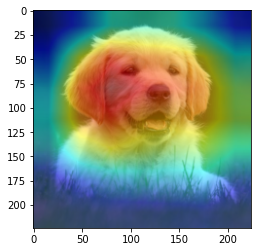

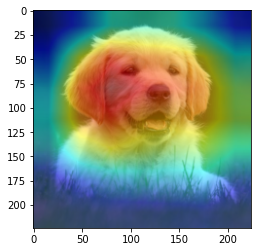

In [43]:
GradCam()(x, model, postprocessing=postprocessing).show()

In [41]:
from einops import rearrange
import torch
import torch.nn.functional as F
from

a = torch.rand((2, 10, 5, 5))

# rear = rearrange(a, 'b c h w -> b (c h w)',)

a = F.interpolate(a, size=(224, 224), mode='bilinear', align_corners=False)
# scaling
# rear.shape
mins = a.min(keepdim=True, dim=1).values
maxs = a.max(keepdim=True, dim=1).values
scaling = (a - mins) / (maxs - mins)
scaling

tensor([[[[0.8032, 0.8032, 0.8032,  ..., 0.0316, 0.0316, 0.0316],
          [0.8032, 0.8032, 0.8032,  ..., 0.0316, 0.0316, 0.0316],
          [0.8032, 0.8032, 0.8032,  ..., 0.0316, 0.0316, 0.0316],
          ...,
          [0.0354, 0.0354, 0.0354,  ..., 0.9403, 0.9403, 0.9403],
          [0.0354, 0.0354, 0.0354,  ..., 0.9403, 0.9403, 0.9403],
          [0.0354, 0.0354, 0.0354,  ..., 0.9403, 0.9403, 0.9403]],

         [[0.9359, 0.9359, 0.9359,  ..., 0.7071, 0.7071, 0.7071],
          [0.9359, 0.9359, 0.9359,  ..., 0.7071, 0.7071, 0.7071],
          [0.9359, 0.9359, 0.9359,  ..., 0.7071, 0.7071, 0.7071],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.2538, 0.2538, 0.2538],
          [1.0000, 1.0000, 1.0000,  ..., 0.2538, 0.2538, 0.2538],
          [1.0000, 1.0000, 1.0000,  ..., 0.2538, 0.2538, 0.2538]],

         [[0.2173, 0.2173, 0.2173,  ..., 0.7678, 0.7678, 0.7678],
          [0.2173, 0.2173, 0.2173,  ..., 0.7678, 0.7678, 0.7678],
          [0.2173, 0.2173, 0.2173,  ..., 0

# Benchmark

In [35]:
from glasses.models import AutoModel, AutoTransform
import torch

In [36]:
model = AutoModel.from_name('vit_base_patch16_224')
model

ViT(
  (embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (1): Rearrange('b e (h) (w) -> b (h w) e')
    )
    (tokens): ViTTokens()
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderBlock(
        (0): ResidualAdd(
          (fn): Sequential(
            (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (1): MultiHeadAttention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (att_drop): Dropout(p=0.0, inplace=False)
              (projection): Sequential(
                (0): Linear(in_features=768, out_features=768, bias=True)
                (1): Dropout(p=0.0, inplace=False)
              )
            )
          )
        )
        (1): ResidualAdd(
          (fn): Sequential(
            (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (1): FeedForwardBlock(
              (0): 

In [38]:
from glasses.models.classification.deit import DeiT
DeiT().embedding.tokens.dist

Parameter containing:
tensor([[[-1.0900e+00,  5.9232e-01, -1.3475e+00, -8.8945e-03,  2.8032e-01,
          -2.5296e+00, -1.2493e+00,  1.9137e-01, -8.4429e-01, -3.9187e-01,
          -1.3274e-01,  1.9846e-01,  2.0594e-01,  3.8294e-01,  1.4616e+00,
           7.3132e-02, -2.6978e-02,  1.2118e-01, -7.7703e-01,  7.8420e-01,
          -1.9390e+00,  2.5998e+00,  1.5004e+00, -1.4453e+00, -1.0452e+00,
          -3.9081e-01,  6.5189e-02, -6.0795e-01, -6.4043e-01, -1.3401e+00,
           5.5202e-01, -6.9359e-01,  1.5587e+00,  6.1924e-01, -4.4311e-02,
           1.2512e+00,  8.5140e-01,  2.0568e+00,  2.7636e-01,  4.0293e-01,
           1.1603e+00,  1.2421e+00,  2.1889e-01, -2.3521e-01, -6.4439e-01,
           9.5910e-01,  1.3049e+00,  2.0507e+00, -1.1315e-01,  1.2872e+00,
           4.0509e-02, -1.9550e-01,  3.4365e-01, -3.1178e-01, -1.2283e+00,
          -3.5690e-02,  5.9273e-02,  8.8650e-01,  8.9549e-01, -5.8535e-01,
           6.3476e-01, -7.6959e-01,  4.5018e-01, -6.3732e-01, -5.4927e-01,
   

In [39]:
import torch
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_distilled_patch16_224', pretrained=True)

Downloading: "https://github.com/facebookresearch/deit/archive/main.zip" to /home/zuppif/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_distilled_patch16_224-df68dfff.pth" to /home/zuppif/.cache/torch/hub/checkpoints/deit_base_distilled_patch16_224-df68dfff.pth


  0%|          | 0.00/333M [00:00<?, ?B/s]

In [11]:
model

DistilledVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(


# Clone

In [14]:
import torch
from glasses.models import AutoModel, AutoTransform, EfficientNetLite
import timm
from transfer_weights import clone_model, deit_clone
from benchmark import benchmark
from glasses.models.classification.vit import ViTTokens

src = torch.hub.load('facebookresearch/deit:main', 'deit_small_distilled_patch16_224', pretrained=True).eval()
dst = deit_clone('deit_small_patch16_224').eval()
# src = timm.create_model('vit_base_patch16_224', pretrained='True')
# dst = AutoModel.from_name('vit_base_patch16_224')
transform = AutoTransform.from_name('vit_base_patch16_224').transform

Using cache found in /home/zuppif/.cache/torch/hub/facebookresearch_deit_main
Using cache found in /home/zuppif/.cache/torch/hub/facebookresearch_deit_main


In [7]:
benchmark(dst.cuda(), transform, 256)

Using downloaded and verified file: ./imagenet_val_targets.pkl


  0%|          | 0/196 [00:00<?, ?it/s]


100%|██████████| 50000/50000 [00:05<00:00, 8977.28it/s]


(0.80258, 0.9512, 113.77364897727966)

In [15]:
benchmark(src.cuda(), transform, 256)

Using downloaded and verified file: ./imagenet_val_targets.pkl


  0%|          | 0/196 [00:00<?, ?it/s]


100%|██████████| 50000/50000 [00:05<00:00, 9045.41it/s]
/home/zuppif/anaconda3/envs/dl/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


(0.80258, 0.9512, 117.3070387840271)

In [12]:
dst.summary()

Layer (type:depth-idx)                        Output Shape              Param #
├─PatchEmbedding: 1-1                         [1, 198, 384]             --
|    └─Sequential: 2-1                        [1, 196, 384]             --
|    |    └─Conv2d: 3-1                       [1, 384, 14, 14]          295,296
|    |    └─Rearrange: 3-2                    [1, 196, 384]             --
|    └─DeiTTokens: 2-2                        [1, 1, 384]               768
├─TransformerEncoder: 1-2                     [1, 198, 384]             --
|    └─ModuleList: 2                          []                        --
|    |    └─TransformerEncoderBlock: 3-3      [1, 198, 384]             1,774,464
|    |    └─TransformerEncoderBlock: 3-4      [1, 198, 384]             1,774,464
|    |    └─TransformerEncoderBlock: 3-5      [1, 198, 384]             1,774,464
|    |    └─TransformerEncoderBlock: 3-6      [1, 198, 384]             1,774,464
|    |    └─TransformerEncoderBlock: 3-7      [1, 198, 384]  

Layer (type:depth-idx)                        Output Shape              Param #
├─PatchEmbedding: 1-1                         [1, 198, 384]             --
|    └─Sequential: 2-1                        [1, 196, 384]             --
|    |    └─Conv2d: 3-1                       [1, 384, 14, 14]          295,296
|    |    └─Rearrange: 3-2                    [1, 196, 384]             --
|    └─DeiTTokens: 2-2                        [1, 1, 384]               768
├─TransformerEncoder: 1-2                     [1, 198, 384]             --
|    └─ModuleList: 2                          []                        --
|    |    └─TransformerEncoderBlock: 3-3      [1, 198, 384]             1,774,464
|    |    └─TransformerEncoderBlock: 3-4      [1, 198, 384]             1,774,464
|    |    └─TransformerEncoderBlock: 3-5      [1, 198, 384]             1,774,464
|    |    └─TransformerEncoderBlock: 3-6      [1, 198, 384]             1,774,464
|    |    └─TransformerEncoderBlock: 3-7      [1, 198, 384]  